# 1. Read in data and preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###  Data Cleaning and Preparation

Before we can analyze the music dataset or build recommender systems, we need to clean and standardize the data.

We start by loading the Spotify dataset, removing unnecessary columns (like extra index fields), and dropping rows with missing values to ensure that our data is clean and consistent. Categorical columns such as track name, artist, and genre are explicitly converted to string type to avoid type mismatches during processing.

A key step in this preparation is the normalization of audio features like `danceability`, `energy`, `loudness`, and `tempo`. Using MinMax scaling, we bring all values into a [0, 1] range. This is important for ensuring that all features contribute equally during clustering, PCA, or machine learning — especially since the original feature scales vary widely.

This cleaned and normalized dataset forms the foundation for all further analysis, such as clustering similar songs or generating explainable recommendations.


In [2]:
# Step 1: Load the dataset
df = pd.read_csv("Spotify Data/train.csv")

# Step 2: Drop unnecessary columns
# 'Unnamed: 0' is just a duplicate index, so we remove it
df.drop(columns=['Unnamed: 0'], inplace=True)

# Step 3: Drop rows with missing values (optional, depends on your use case)
df.dropna(inplace=True)

# Step 4: Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Step 5: Optional - convert categorical data to string type (in case it's inferred wrong)
df['track_id'] = df['track_id'].astype(str)
df['artists'] = df['artists'].astype(str)
df['album_name'] = df['album_name'].astype(str)
df['track_name'] = df['track_name'].astype(str)
df['track_genre'] = df['track_genre'].astype(str)

# Step 6: Optional - normalize audio feature columns (e.g., for ML input)
from sklearn.preprocessing import MinMaxScaler

audio_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

scaler = MinMaxScaler()
df[audio_features] = scaler.fit_transform(df[audio_features])

# Step 7: Display first few rows to verify
print(df.head())

                 track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4   

# 2. Explorative Data Analysis

In [3]:
# ---- Summary Statistics ----
print("Descriptive Statistics:\n")
print(df.describe())

Descriptive Statistics:

          popularity   duration_ms   danceability         energy  \
count  113999.000000  1.139990e+05  113999.000000  113999.000000   
mean       33.238827  2.280312e+05       0.575432       0.641383   
std        22.304959  1.072961e+05       0.176186       0.251530   
min         0.000000  8.586000e+03       0.000000       0.000000   
25%        17.000000  1.740660e+05       0.462944       0.472000   
50%        35.000000  2.129060e+05       0.588832       0.685000   
75%        50.000000  2.615060e+05       0.705584       0.854000   
max       100.000000  5.237295e+06       1.000000       1.000000   

                 key       loudness           mode    speechiness  \
count  113999.000000  113999.000000  113999.000000  113999.000000   
mean        5.309126       0.763407       0.637558       0.087723   
std         3.559999       0.093028       0.480708       0.109568   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000

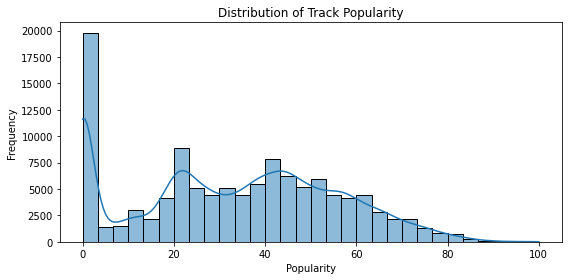

In [4]:
# ---- Popularity Distribution ----
plt.figure(figsize=(8, 4))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

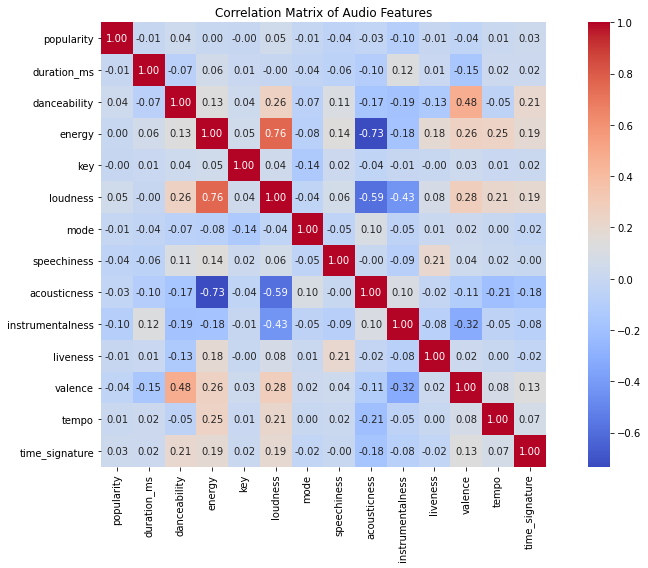

In [5]:
# ---- Correlation Heatmap of Audio Features ----
plt.figure(figsize=(12, 8))
corr_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Audio Features')
plt.tight_layout()
plt.show()

# 3. Spectogram Generation

### Downloading 10-Second Audio Clips from YouTube

This function enables automatic downloading of short song previews directly from YouTube using the `yt_dlp` library. Given a song query (e.g. artist + title), the script:

1. Searches YouTube and downloads the best-quality audio from the first result.
2. Converts the audio to MP3 format using FFmpeg.
3. Trims the file to the first 10 seconds using `pydub`.
4. Saves the clip to a specified path.
5. Deletes the temporary full-length audio file.

This process allows us to collect a consistent dataset of short audio snippets for spectrogram generation and further analysis. Short clips are especially useful for rapid preview, classification, or similarity comparison without processing full songs.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.io import wavfile
from scipy.signal import spectrogram
from spotipy import Spotify
from spotipy.oauth2 import SpotifyClientCredentials

In [7]:
import os
from pydub import AudioSegment
import yt_dlp

def download_10s_clip_youtube(query, save_path):
    try:
        # Set up yt-dlp options to get audio only
        ydl_opts = {
            'format': 'bestaudio/best',
            'noplaylist': True,
            'quiet': True,
            'outtmpl': 'temp.%(ext)s',
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',
                'preferredcodec': 'mp3',
                'preferredquality': '192',
            }],
        }

        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([f"ytsearch1:{query}"])

        # Trim to 10 seconds
        audio = AudioSegment.from_file("temp.mp3", format="mp3")
        audio[:10000].export(save_path, format="mp3")

        # Clean up
        os.remove("temp.mp3")
        print(f"✅ Saved 10s clip: {save_path}")
        return True
    except Exception as e:
        print(f"❌ Failed for '{query}': {e}")
        return False

In [ ]:
for i, row in df.iterrows():
    query = f"{row['track_name']} {row['artists'].split(';')[0]}"
    save_path = f"clips/clip_{i}.mp3"
    os.makedirs("clips", exist_ok=True)
    download_10s_clip_youtube(query, save_path)

Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_0.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_3.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_4.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_5.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_6.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_7.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_8.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_9.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_13.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_14.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_15.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_18.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_23.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_24.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_25.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_26.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_27.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_28.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_29.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_30.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_31.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_32.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_33.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_34.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_35.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_36.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_37.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_38.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely This Christmas KT Tunstall': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_40.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_41.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_42.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_43.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_44.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You and Me on the Rock Brandi Carlile': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_46.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_47.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_48.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_49.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_50.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_51.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_52.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = VS5DPg96fw3j5Tm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = iQuNheoZfl7W_Vk ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_53.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_54.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_55.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_56.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_57.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_58.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_59.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_60.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sky's Still Blue Andrew Belle': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_62.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_63.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_64.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_65.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_66.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_67.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_68.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_69.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EuJN-cwF1IjKF5B ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = am7XmUPBpG7NS50 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_70.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_71.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_72.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_73.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_74.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_75.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_76.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_77.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_78.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_79.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_80.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_81.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Society Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_83.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_84.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_85.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_86.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_87.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely This Christmas KT Tunstall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Knows Five For Fighting': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_90.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_91.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fairytale Of New York KT Tunstall': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_93.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_94.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_95.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_96.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_97.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_98.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_99.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_100.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_101.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_102.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_103.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_104.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_105.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_106.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_107.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_108.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_109.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_110.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_111.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_112.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_113.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_114.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_115.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_116.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_117.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_118.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_119.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_120.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_121.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Do Not Let Me Go Joshua Hyslop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holding On And Letting Go Ross Copperman': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_124.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_125.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_126.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_127.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_128.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_129.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_130.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without You Parachute': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fsd9qatHjIEyjh1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qE9uTSVVe2mg1dL ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_132.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_133.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_134.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_135.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_136.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_137.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_138.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_139.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Do Anything Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_141.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_142.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_143.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_144.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_145.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_146.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_147.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_148.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_149.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_150.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_151.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_152.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_153.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_154.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_155.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_156.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_157.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_158.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Direction Rachael Yamagata': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_160.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_161.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_162.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_163.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_164.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_165.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_166.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_167.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_168.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_169.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_170.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_171.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_172.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mujer con Abanico Agustín Amigó': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the Shadows Amy Stroup': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can You Feel the Love Tonight Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Story Brandi Carlile': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iris Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockabye - Acoustic Version The Mayries': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Need You More Today Caleb Santos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Soul Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let's See What The Night Can Do Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La La La (Something In the Rain, Pt. 2) [Music from the Original TV Series] Rachael Yamagata': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever And Always Parachute': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fine On The Outside Priscilla Ahn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tortured Soul Chord Overstreet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Believe in You JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'At Home Jon Bryant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Portland, Maine Donovan Woods': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holding On and Letting Go Ross Copperman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Flood Joshua Hyslop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hanggang Kailan (Umuwi Ka Na Baby) Angelina Cruz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Out of My League Stephen Speaks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say Something A Great Big World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rise Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'World Spins Madly On The Weepies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stumble Freddie King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paradise Taj Mahal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moonlight, Mistletoe & You Keb' Mo'': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ひまわりの約束 Motohiro Hata': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Since U Been Gone - Acoustic Version Thomas Daniel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One more time,One more chance Masayoshi Yamazaki': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Creep Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Higher Love Todd Carey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hyouriittai YUZU': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Long Will I Love You Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Binibini Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_208.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thinking out Loud Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect / Style Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poison & Wine The Civil Wars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Collide Howie Day': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You And I Ingrid Michaelson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Give Me Your Forever (ft. Billkin) Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Falling in Love at a Coffee Shop Landon Pigg': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breathe (2 AM) Anna Nalick': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Habang Buhay Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Soul Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bulletproof Ben Woodward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spectrum Andrew Belle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Girls Like You - Acoustic Version Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nangangamba Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better Together Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heartbreak Anniversary Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One More Time Around Tyler Ward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say Something A Great Big World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heart Can’t Lose Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Ain't Ever Loved No One - Acoustic Donovan Woods': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empty Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'See You Again, Love Me Like You Do, Sugar - Acoustic Mashup Megan Davies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Reason Tim Halperin': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9EfKZigC-AmQkz_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = VjUdcBm14ABPpXY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fix You Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hand to Hold JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold You in My Arms Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Qca69aQXrh-UMBU ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = azk04hnaQzXWS1P ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Last Dance Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Spark - Bonus Track Joshua Hyslop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'American Beauty Drew Holcomb & The Neighbors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Such A Simple Thing Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Colors Amos Lee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Someone You Loved Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Than Friends (feat. Meghan Trainor) Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flurry Rush Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Choose You Sara Bareilles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Do Adore Mindy Gledhill': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = os52zay6iIxeK1z ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 44JP9WFP5gP7__K ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas Dave Barnes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fuck You Get Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Comes But Once A Year Albert King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Comes But Once A Year Albert King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Ain't Got You - Acoustic John Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Believe - Acoustic John Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iris - Acoustic Adam Christopher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rain - Long Ver. Motohiro Hata': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'C'est si bon Aoi Teshima': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby (Acoustic Version) Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reason YUZU': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like Me Better Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_258.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Thousand Years Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_260.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Someone Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Winner Takes It All - Acoustic Jae Hall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only Time Aaron Espe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Almost Lover A Fine Frenzy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance Monkey Roses & Frey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ocean Parachute': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dream a Little Dream of Me Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back For Good The Mayries': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'OK Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just The Two Of Us Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey There Delilah Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arcade Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yellow Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up Roses & Frey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walking Blind Aidan Hawken': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Headphones Jon Bryant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teenage Dream The Rescues': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Worth Of The Wait Ivan & Alyosha': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Help Falling In Love - Piano Version Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Come Back Again Austin Plaine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love You To Death Chord Overstreet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Someone You Loved - Acoustic Plamina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What a Wonderful World Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Broke Me First Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Long Way Down Joshua Hyslop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Is Love Parachute': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Marigold Phillip LaRue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12:51 krissy & ericka': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'サンサーラ Takehara Pistol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sons and Daughters Allman Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brand New Ben Rector': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gotta Have You The Weepies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '30,000 Feet Ben Rector': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Thousand Years Eddy Tyler': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = CviQbtxQf6fiUwQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -ulkZ8IgYzrwJpb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jolene Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Ceiling Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Front Porch Joy Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Goodbye Lulu Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Three More Days Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Isn't She Lovely - Acoustic Callum J Wright': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Could Still Be Happy Rachael Yamagata': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fix You - Acoustic John Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Yours - Acoustic Lusaint': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Closer Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Sky Full of Stars Mother's Daughter': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don't Believe in Satan Aron Wright': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pills The Perishers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shallow - Acoustic Tyler Ward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Watermelon Sugar - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say You Won't Let Go - Acoustic Matt Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hikare Inochi Kitri': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Call You Mine (Acoustic Piano) Ben Woodward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For Now Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Dream Greg Laswell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Nwantiti Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5SqTcAQ8OHHdsx3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sYeWRWYvCsDtLBt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stars Are on Your Side Ross Copperman': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zuNoc8lFbU9SWtC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vKOrn4rxNYeeHqA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_317.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Superman Joe Brooks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chasing Cars Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calm Me Down Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'KISSして Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Binibini (Last Day On Earth) (feat. James TW) Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left for America Ciaran Lavery': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ramparts John Frusciante': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold On - Acoustic Chord Overstreet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dust to Dust The Civil Wars': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FkqvOibJzpaTWLf ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good night Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'As You Are Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Binibini Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Aint Me Sara Farell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say Something A Great Big World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Lotto Ingrid Michaelson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tamacun Rodrigo y Gabriela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Make It Without You Andrew Belle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dream Priscilla Ahn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Love, Small Moments JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Am Not Alone Priscilla Ahn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stand Your Ground Joshua Hyslop': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = y5kmSnvB_j9uxaH ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 3wFacuRtxRFkt6B ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect Man Front Porch Step': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'あ。っという間はあるさ Takehara Pistol': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = eeQUcs4irnD8i4w ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 3gGZRudNWbN4SK4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tell The World Eric Hutchinson': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1JwrjnVNHf8WCye ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NHnKHFmNTIHWwdS ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ain't No Reason Brett Dennen': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = a5iwaHE1r0XQAIK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = WUPTNSbGYERi8f7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Month from Now Rail Yard Ghosts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What If Five For Fighting': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OWufoEPmn7w4nkk ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pussy Cat The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Polaroid Picture Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Bet On Flying High Matt Costa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Bet On Flying High Matt Costa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Bet On Flying High Matt Costa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mirrors - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'To the Wonder (feat. Kina Grannis) Aqualung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stay - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '太陽さん Ichiko Aoba': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh What A Love Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave The Lights On Meiko': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Won't Let You Down Erin McCarley': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_357.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stargazing Isabella Celander': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Liar Roses & Frey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Is It You Rachael Yamagata': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Down Time Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2002 - Acoustic Amber Leigh Irish': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OtKBnbgatbPghUu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1Hj2alW_vyX5ofF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweeter Jess Penner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heat Waves - Acoustic Daniel Robinson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'アジアの純真 Yosui Inoue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If the World Was Ending - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Comes And Goes (In Waves) Greg Laswell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ながれ星 Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dusk Till Dawn - Acoustic Blame Jones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Wanna Leave You Ben Woodward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Passenger Seat Stephen Speaks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Matt White': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hallelujah Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qOEOZchEfXRqiwC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9DU1BRinMVzjQnu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ashes Madi Diaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '明日の☆SHOW Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me Like You Do Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost Sparks Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who We Are Tristan Prettyman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heart (Original Version) Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It'll Be Alright JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_381.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kabilugan Ng Buwan Mark Oblea': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Keep Breathing Ingrid Michaelson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fast Car Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just the Way You Are Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Ladder Andrew Belle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HELLO (Original Version) Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '接吻 Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tT92VhCpAI7WuLv ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nq_WooJbRe7zOxc ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Keep It Inside Brett Dennen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '明日天気になれ Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'IT'S ONLY LOVE Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'それがすべてさ Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don't Wanna Love Somebody Else A Great Big World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burn It All! RENT STRIKE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carried Me With You Brandi Carlile': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O, Pennsyltucky! Mischief Brew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Believed You, William Blake Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pepperspray Get Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stickup Get Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven - Acoustic Grace George': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soldier's Eyes Jack Savoretti': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jEZJ1CU_yN_8_lO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xl19pTXjqo1bWxy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Asleep Among Endives Ichiko Aoba': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony - Acoustic Thomas Daniel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I Was Your Man Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Save Your Tears - Acoustic Amber Leigh Irish': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Koi Gen Hoshino': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'July Bones Richard Walters': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5NA1L7uZdRxmULF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = cKPr6Ytn-F-Fky3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Autumn Breeze Kaiak': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Save Your Tears Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Still The One - Acoustic Bailey Rushlow': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Loved Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rise Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bohemian Rhapsody - Acoustic John Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'As It Was - Acoustic Amber Leigh Irish': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wish List Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Disaster Chord Overstreet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fake a smile Wayne Mack': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Marigold Aimyon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River Flows In You Sungha Jung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kill Me Pretty Tamio Okuda': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Matter Where You Are Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like You Ben Rector': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Mess I Made Parachute': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dream a Little Dream of Me Zee Avi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here, Right Now Joshua Radin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wonderful Tonight Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Salvation Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wilderness Jon Bryant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '恋人 (Original Version) Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Just Called To Say I Love You Bailey Pelkman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fall on Me A Great Big World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Song To Sing When I'm Lonely John Frusciante': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fF6RbTltviHPDsM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xNuf9LhCUUtzxw0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Drop In the Ocean Ron Pope': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have Yourself a Merry Little Christmas Tres Hermanas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Message (Original Version) Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful In White Matt Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Is a Place on Earth The Mayries': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Passenger Seat (Acoustic) Stephen Speaks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Guaranteed - Humming Version Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hang Me, Oh Hang Me Dave Van Ronk': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Afterglow John Frusciante': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eat the Meek Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Trouble with Wanting Joy Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Are the Best Thing Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boycott Me! Mischief Brew': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xb74hJ2eM9iNPwc ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = iZR423j1uTbdkAP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'To Risk to Live Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Legend of Olog-hai, Pt. 1 The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Christmas For Me Zee Avi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This One's for Johnny Get Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Graveyard - Acoustic Highland Peak': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FAcY2OVnAp7o4FV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = yG1ld09al73383L ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'bouquet Ichiko Aoba': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'こころをこめて Aoi Teshima': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paradise AcousticTrench': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better Parachute': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Laid Matt Nathanson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Same For You Lee DeWyze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2U - Acoustic Version Clementine Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duet Rachael Yamagata': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Say I Do Brandon Chase': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anyone Bailey Jehl': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Start of Time Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Give Me Your Forever Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heat Waves Bailey Jehl': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There She Goes Clementine Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wells Joshua Hyslop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'God Only Knows Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afterglow Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burn The Rain Kurt Cobain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Already Mine Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'きみはぼくのともだち Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Be the Same Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Is Well Austin Basham': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Mistake Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Near Or Far Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without a Light Drew Holcomb & The Neighbors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely With Me Parachute': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time After Time Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Are You To Me Eastmountainsouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Arms Were Always Around You Peter Bradley Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance Me to the End of Love - Bonus The Civil Wars': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_481.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Now That I Found You Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Right Here Waiting Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smokestack Lightnin' Howlin' Wolf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Passenger Seat Stephen Speaks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feels Like Rain (feat. Bonnie Raitt) Buddy Guy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sugar Babe Mance Lipscomb': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blister In The Sun Violent Femmes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Little Blue Pills, Pt. 2 Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paano Ang Simbang Gabi - Kung 'Di Ka Katabi Drei Rana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bob Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Psycho Harley Poe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect Government Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = wApwyej7DZxK2zX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HdcSuL-IGvaeqwx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Fear The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living My Best Life Ben Rector': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Haven't Been Doing So Well Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Legend of Olog-hai, Pt. 2 The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You and Me On The Rock (feat. Lucius) Brandi Carlile': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glitch Get Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Thousand Years - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2 Oceans Trevor Hall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Golden Hour - Acoustic Piano Ben Woodward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without Me Brandon Chase': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You & Me (The Wildfire) Aron Wright': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dancing With A Stranger Sara Farell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pero Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good 4 U (Acoustic) Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'And Then You Greg Laswell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here With Me - Acoustic Daniel Robinson': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_510.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_511.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Far so Good Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_513.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fade into You Andrew Belle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '東京にもあったんだ Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'あの夏も 海も 空も Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '21 Guns Bailey Jehl': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waves Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Running Up That Hill (A Deal With God) - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poison's Gone Kurt Cobain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '18 ~eighteen~ Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Build Me Up Buttercup Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Umbrella - Acoustic Version The Mayries': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Home Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're My Home Joshua Radin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'vs.2013 ~知覚と快楽の螺旋~ Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like Me Better Ysabelle Cuevas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Remedy (I Won't Worry) Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something Stupid Bailey Pelkman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hanap-Hanap Ethan Loukas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Will To Death John Frusciante': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vsNuiK0BYPRmrYl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = IOaHF8qxcOQKGtp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boulevard of Broken Dreams (Acoustic) Adam Christopher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Help Falling In Love Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eloise Penny and Sparrow': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Help Me Sonny Boy Williamson II': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everytime We Touch (Acoustic) Shannon & Keast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let It Be Me Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beer Mia Rollo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Someone Like You Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You've Got a Friend Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Little Light of Mine JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amazing Grace Takehara Pistol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Remnants of What People Used to Be Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ncp8BqX7Z_vRfIB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1_H7RdJXpxXEbfx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Linda Ronstadt AJJ': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unsteady - Acoustic Covers Versions of Popular Songs SANNA NORTH': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heart's Content Brandi Carlile': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Damned The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hot Knives Pigeon Pit': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nickel Plated Get Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Peaches - Acoustic Adam Christopher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You A Great Big World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swimmers Andrew Belle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Live Like We're Dying Kris Allen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody That I Used To Know Lúc': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost Without You Ben Woodward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One more time, One more chance Masayoshi Yamazaki': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'you broke me first The Mayries': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skylight Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Game of Thrones Edy Hafler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Like You and I The Perishers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wanted Man Mat Kearney': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back To You The Mayries': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '何度でも花が咲くように私を生きよう Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scared to Be Lonely Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sappy - Early Demo Kurt Cobain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ancient Light Allman Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = hVlHKTbyG_zdLTK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BO13hMIp7xuocf- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don't Wanna Live Forever (Fifty Shades Darker) - Acoustic Version Sara Farell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Before You Go Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ships In The Night Mat Kearney': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only You Joshua Radin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waver Sakura Fujiwara': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Missing Peace JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '聖域 Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Firework Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Such A Simple Thing - Recorded at Sound Stage Studios Nashville Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sad Theme (From "One Punch Man") Eddie van der Meer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Know What I Want Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Call Me Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'True Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Can't Make You Love Me Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say Anything Tristan Prettyman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All We Are Matt Nathanson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gentle Heart Joshua Hyslop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All My Loving (Original Version) Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'アンダルシアに憧れて Masayoshi Yamazaki': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '想 -new love new world- Masaharu Fukuyama': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Christmas Drei Rana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Green Mountain State Trevor Hall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Di Papakawalan Maris Racal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Go Back Now The Weepies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ウイスキーが、お好きでしょ Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ditches Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Outside Villanova Eric Hutchinson': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = inZwwlBzf_cEJxw ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jdesUb7Mznyq2t4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Timeline Apes of the State': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Never Fall in Love Again Gail Blanco': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stray Cat Strut The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Goodbye Lulu Pt.2 Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jMMcUKQAW3fmWmd ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Days n Daze of Our Lives Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Track Get Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ghost - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '4am Eden Elf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '10,000 Hours - Acoustic Adam Christopher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yellow - Acoustic Amber Leigh Irish': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Air Lúc': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = cdIqH7RdKBc6dN- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8e7lKsGdBVKT1VJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Self Help Anna Hamilton': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = v_0hINQApwfR479 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = eLhkHJnW00S3hMX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blackbird Song Lee DeWyze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Easy On Me - Acoustic Jonah Baker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chasing Cars - Acoustic Bailey Rushlow': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Take My Eyes Off of You Emilie Mover': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fortune - Acoustic William Fitzsimmons': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lot To Learn Vivid Color': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Apologize Bailey Jehl': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'First & Last Zack Tabudlo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold, Cold Feeling Albert Collins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Love Phillip LaRue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shotgun Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HEY! Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have It All Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trouble Sleeping The Perishers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Disaster Jon McLaughlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breathe Again Sara Bareilles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trouble Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memories Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sink Or Swim Tyrone Wells': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tama Na EJ De Perio': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'He's A Pirate (From "Pirates of the Caribbean") Beyond The Guitar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '能古島の片想い - Remastered 2018 Yosui Inoue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitter Heart Zee Avi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Want to Know What Love Is - Acoustic Hannah's Yard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ハンキーパンキー Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ordinary Days JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moon River JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever Like That Ben Rector': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_634.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '一等賞 Takehara Pistol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '音タイム Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_637.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Toulumne Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = KxiYTPq0dh2JHa1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = S0ZjHimPssLyZko ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just The Two Of Us - Acoustic Vendredi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arrythmic Palpitations Chris Cresswell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Boat Chuck Ragan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born Under A Bad Sign - Mono Mix Albert King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nobody Knows Me At All The Weepies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitter Morning Taste Tim Vantol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'DBS Out Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy - (Acoustic Mix) Vendredi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ffeFd9lbIfZJI13 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dungeon Song The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can I Sleep On Your Floor?? Chad Hates George': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Josephine Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'いきのこり●ぼくら Ichiko Aoba': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Careless Whisper Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Look After You Aron Wright': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect Acoustic Guitar Collective': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When the Party's Over Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Longest Night Howie Day': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Photograph Andrew Foy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shame Ciaran Lavery': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iris Bailey Jehl': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -UzKOCawdKGbUVa ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = uLqdWpMXhjvb6G6 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Running Wild Jules Larson': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sxN5xPw2yOUSVKa ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = P8H4NKCoiEA8p4I ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '彼方で Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hazy (Featuring William Fitzsimmons) Rosi Golan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let It Go Colin & Caroline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wanna Be Your Ghost (feat. Ghosts) Gen Hoshino': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '約束の丘 Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Young And In Love Ingrid Michaelson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Plans Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Easy on Me Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tonight You Belong To Me Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Closer Ysabelle Cuevas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Last Breath Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Devil's Backbone The Civil Wars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waltzing Matilda Will Moore': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Girls Chase Boys Ingrid Michaelson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Woman I Love Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Love Me or Die C.W. Stoneking': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '美しき花 Masaharu Fukuyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Isn't She Lovely Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '世界中の誰よりきっと Mone Kamishiraishi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Horse And The Cherry Tree KT Tunstall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drunks Johnnyswim': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coming Home Drew Holcomb': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = CHGuWFIcOf0H6fj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Jg4DuudhJDCp_Ta ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Tore Down Freddie King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Neighbor (Piano Version) JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Will Always Be Yours Ben Rector': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nine on the Bortle Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Redemption Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Other Side Of The World KT Tunstall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Setting Forth Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eulogy Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tarnished Ol' Photograph Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rocksteady Marc Broussard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come on In The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Laugh While You Can The Bridge City Sinners': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Untainted Love Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whiny Bitch Harley Poe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wanna See It Burn Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home for Christmas Mindy Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home for Christmas Mindy Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Amazing Mindy Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Far Does the Dark Go? Anya Marina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'THATS WHAT I WANT (Acoustic) Adam Christopher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dynamite - Acoustic Hannah's Yard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Stop (Wedding Version) SafetySuit': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Mine (The Chase) Meiko': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'パラレル・ラブ Yosui Inoue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Her Go Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Are We Canyon City': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shallow Eddy Tyler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold Each Other (feat. Futuristic) A Great Big World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '別れの予感 Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Was Born To Love You Ray LaMontagne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Naked Heart Aimyon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Days I Will Remember Tyrone Wells': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ICQJHw4cYTGV9bS ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4TcamBm67NPk97t ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smell the Coffee Kaiak': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unlonely Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'See You Again Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ゆめのなか Sakura Fujiwara': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Than You Know - Acoustic Covers of Popular Songs Filip Nordin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Really Matters Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Wanna Know - Acoustic Version The Mayries': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweetest Thing Allman Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Safe Place to Land (feat. John Legend) Sara Bareilles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Your Song Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Billie Jean The Civil Wars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cadillac Assembly Line Melvin Taylor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pirates of the Caribbean Theme Eddie van der Meer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '全て身に覚えのある痛みだろう? Takehara Pistol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Is A Bitch Luther Allison': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'オールドルーキー (再録) Takehara Pistol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You and I Both Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Past Recedes John Frusciante': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Laro Laro Laro Maris Racal': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = z09y6iTDZJW5A2H ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _PcYq9SuydM3_Dl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_733.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Need You Penny and Sparrow': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When It's Gone We The Heathens': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Sent Front Porch Step': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Much Heaven Gail Blanco': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Face the Void Ramshackle Glory': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'V: Fair Trade Death March RENT STRIKE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fate of a Coward Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Start Me To Talkin' Sonny Boy Williamson II': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angel of Death AJJ': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_743.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're a Witch Harley Poe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Non Serviam Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Gathering Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XypXQgJ-aUnHON4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0U6I4CwyupGRLl9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Years Eric Lumiere': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Comfort epershand Control Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Demons Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '愛を伝えたいだとか Aimyon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'FUSHIGI Gen Hoshino': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad News Is Coming Luther Allison': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Mean Love Ethan Loukas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Night Bus Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dark Matter Andrew Belle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Doraemon Gen Hoshino': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_757.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EV8k1zfn0GCNqZ9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_758.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave The Door Open - Acoustic Blame Jones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Careful Michelle Featherstone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Use Somebody - Acoustic Lusaint': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Only Lies Kurt Cobain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What About Us - Acoustic Thomas Daniel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hound Dog Big Mama Thornton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Turn To Stone Ingrid Michaelson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drawn by the Wind (Arr. for Guitar) Joseph Sullinger': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shy From The Light Neulore': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memories (Acoustic) Ben Woodward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She’s The Song Nathan Angelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You Fall in Love Andrew Ripp': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Won’t Give Up Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Suitcase JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stitches Filip Nordin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I 'll Play the Blues for You Melvin Taylor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'PRIDE Mone Kamishiraishi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Power of Love Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arms Of A Woman Amos Lee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seeing Other People Donovan Woods': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'King of Anything Sara Bareilles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost Cause - Acoustic Covers Versions of Popular Songs Covers Culture': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_781.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honey Austin Plaine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like to Be With Me When I'm With You Drew Holcomb & The Neighbors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No More - Live Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = hBGT2Pdoz-czwLG ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _B7yzPRagprn58Z ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On & On Beans on Toast': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = t_RqBd7tuun8IFh ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UxfsUP42IAVXnat ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Million Years Johnnyswim': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'End Of The Road Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Really Sucked, Actually Not Half Bad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Work Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trenchfoot Chuck Ragan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unicron AJJ': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AMTL6qSUqUHHDAK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qjEgVxLdZmrV7Pl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Issues Violent Femmes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Darkest Heart AJJ': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Letter Home Defiance, Ohio': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = Tg_ycHmruveqmJ_DsjD ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Control NORMANDY': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FR27VvLBDXCoxHd ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fall Out Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Gathering Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Time Tomorrow Brandi Carlile': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roll Me Through the Gates of Hell - Acoustic Version Mischief Brew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SUN Gen Hoshino': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet but Psycho - Acoustic Parker Jenkins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm the One - Acoustic Sunset & Highland': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Magic Gabrielle Aplin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost Kris Allen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '黄金の月 Shikao Suga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Would Be You Ben Rector': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'As It Was - Acoustic Instrumental Guus Dielissen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Child O' Mine - Acoustic Jae Hall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beyond The Sea Kina Grannis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have I Told You Lately That I Love You - Acoustic John Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pilots Andrew Ripp': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'さくら - 二〇一九 Naotaro Moriyama': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Homeland Chord Overstreet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Hardest Thing Tyler Ward': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Supermarket Flowers Postcards & Polaroids': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '陽はまた昇る Yu Takahashi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swans Unkle Bob': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Greatest Showman - Rewrite The Stars (Acoustic) The Cameron Collective': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Million Dreams - Acoustic John Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '3636 Aimyon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '君はロックを聴かない Aimyon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tears In Heaven Boyce Avenue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paperweight by Joshua Radin and Schuyler Fisk Joshua Radin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Meant to Be JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paasa Kurei': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Matter Where You Are - Wedding Version Us The Duo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '大安 Hanare Gumi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Now We're Starting Over Again Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the Morning JJ Heller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Babe Little Walter': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What a Time to Be Alive Matt Pless': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Longer I Run Peter Bradley Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Not Sorry - Acoustic Covers Versions of Popular Songs Covers Culture': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Think Twice, It's All Right - Acoustic Jay Filson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Is There Something Suy Galvez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living in the Moment Jason Mraz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Other Side Of The World KT Tunstall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Torches Are Calling Days N Daze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Close to You Gail Blanco': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Far Behind Eddie Vedder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Protest Songs Ankle Grease': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White Worms AJJ': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miranda Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = gRb2h_BIPg_HfYo ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vwm_TO3akRmwzqK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Linoleum Frank Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_846.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_847.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YR5rmv9EFFj7G75 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FeLHks_W6WxzkMQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_848.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_849.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_850.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_851.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_852.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_853.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_854.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_855.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_856.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_857.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_858.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_859.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_860.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = D6qOLI-JHoo2VMf ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sBaot_XiFOvwYap ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_861.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_862.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_863.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_864.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_865.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_866.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_867.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_868.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_869.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_870.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_871.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_872.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_873.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sy9TsAyCAVJd-Kv ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = QmGPP0oSY0Ioq0t ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_874.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_875.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_876.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_877.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_878.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_879.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_880.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_881.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_882.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_883.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_884.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_885.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_886.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_887.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BGBUzkOgRwOerZP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1OyJhM72_T97ilI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_888.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_889.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_890.mp3


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = LDEFmN5iISjix-OUwUW ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = Kj-ww5p9YywplQmg_bs ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_891.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rwHFd-ZaLj8rqOq ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_892.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_893.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_894.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_895.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_896.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_897.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_898.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_899.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_900.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_901.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_902.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_903.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_904.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_905.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_906.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_907.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_908.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_909.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ixK8uPcYywg6zCD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PbaGI5axyt8iPf9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_910.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_911.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moth To A Flame - Acoustic Instrumental Guus Dielissen': [Errno 2] No such file or directory: 'temp.mp3'


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_913.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_914.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_915.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_916.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_917.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_918.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_919.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_920.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_921.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_922.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_923.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_924.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_925.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_926.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_927.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_928.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_929.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_930.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_931.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_932.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_933.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_934.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vWUhR09l4kFF5cM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OL0jk5uSNVsQIB7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_935.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_936.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_937.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_938.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_939.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_940.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_941.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_942.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_943.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_944.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_945.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_946.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_947.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_948.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_949.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_950.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_951.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_952.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_953.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_954.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_955.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_956.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_957.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_958.mp3


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = 2PvURueiKu9-PE_tulB ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_959.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_960.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_961.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_962.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_963.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_964.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_965.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_966.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_967.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = x3u40VgCAS8wIXe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pM9sDagSvJs2E5g ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_968.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_969.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_970.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_971.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_972.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_973.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_974.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tHd4nV0Vk68CmLV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jVeYPzpwRwWn7sA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_975.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_976.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_977.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_978.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_979.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_980.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_981.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_982.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_983.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rWG87E6Mu7Awdda ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ItNNprJWB6Eww6k ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_984.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6moG2ERWw4Iy3wP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xv2qtdsZlEVqhQ6 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_985.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_986.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_987.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_988.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_989.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_990.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_991.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_992.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_993.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_994.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_995.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_996.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = WaiRKITjGTH9M1j ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = e2dwA0qjKt08Q_j ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_997.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AHBgb107BNdybd4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Qg5_PO7ElLo6srV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_998.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_999.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1000.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = LkC7dCE9HTLPARw ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1001.mp3


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = 8GiXOUUEdF2oxgosqJB ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = c6YM_s--B1n0MkltiRm ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1002.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1003.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EqSllITID5cb0Ad ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1004.mp3


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = nfWnNPgBVeNMfKz2tPr ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = JqUP-_-nPlKGg4q-yRS ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1005.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1006.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1007.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1008.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vYnKFmu2kWOn96C ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1009.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1010.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1011.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1012.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1013.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1014.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Jh1c3P2ZD7P3RF2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YMKHIK1dEE0OU_2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1015.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1016.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PCADigZWkyYSm2x ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PjOSDBue1Kx96k7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1017.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1018.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1019.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1020.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1021.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1022.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1023.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = WU4-GCHbb_Yuith ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2HnmrVnIBNyR_Lq ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1024.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1025.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1026.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HWjUMEI1nNeHkiO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pikxzAMjRHZGnjR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1027.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1028.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rYshP2gTXz5PxXa ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Zu73lcdn-bTcJsq ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1029.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1030.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1031.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1032.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1033.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1034.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1035.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1036.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1037.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1038.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1039.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1040.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1041.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1042.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1043.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1044.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1045.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1046.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1047.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1048.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1049.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1050.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1051.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1052.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1053.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1054.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1055.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1056.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1057.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1058.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1059.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1060.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1061.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1062.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1063.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1064.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1065.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1066.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1067.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = TTcS4RTTu9gIIoe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1068.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1069.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1070.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amar Es Algo Más Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Redoma BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Viva (Melô Dos Vileiros) - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1074.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'CertoPeloCertoh BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fat City Strut Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fé Cega, Faca Amolada Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Bala Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chocolate Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mariô - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Demorô - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Panela BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reza Forte BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human Disco Ball Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Dhvr5PdVGjWLL0C ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = a1nqdzDm3D9EdZR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bala na Agulha BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Jardinera Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Makoti Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nontsokolo Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soul Makossa Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Triunfo - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Grajauex - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1BSZXf3lUxyOI6k ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'District Six - Live Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Não Existe Amor Em SP - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Women Of The Sun Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bogotá - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1096.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1097.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = e_imLNbp7R7zUfD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'District Six - Live Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stop That Train Ernest Ranglin': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1100.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1101.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1102.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '4 da Manhã – Deluxe Edition Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Água (Versão Estendida) BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Organdí Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sólo los dos (feat. Ferraz) Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tô pra Onda Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eres Mis Ganas Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bienvenidos A Mi Mundo Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tá Amarrado OQuadro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Agente Russo Nomade Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alfazema BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crece Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alegria por un Zumo de Naranja Con Panela Romperayo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cóccix-ência Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dulce Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ride On Baby - 1977 Version William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La nieve en la bola de nieve Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raminho BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oxe, Como Era Doce BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Uno Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ode To Mauricio Garces Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aquiles por su talón es Aquiles Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Madurar Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Te Lo Juro Por Madonna (Si Omba Ta Gueno) Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Vida É Curta Pra Viver Depois BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bungaloo Punta Cometa Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dança de Airumã BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Barravenida, Pt. 2 BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Desengano da Vista Bixiga 70': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flores Raras Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mercado BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Obá Iná Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Río abajo Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Niño Bomba Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Makoti Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0uTdEMlC8-mL21n ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'District Six - Live Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calamatraca BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1139.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ikeja Roads Tony Allen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La infidelidad de la era informática Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bambezela Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chapéu Panamá BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Makoti Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lion Man - Live Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Lr1SsZOuu-h2hl1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'District Six - Live Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sex Appeal Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Corazón Tatú Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = eGGpA05dBUzfITC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'District Six - Live Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thank You Lord CalledOut Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ai Du (with Ry Cooder) Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bang Data Bang Data': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Educación QUITAPENAS': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'gorila Morbo y Mambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shampoo Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canción Ecológica Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Disco Ball Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There's Music In The Air Letta Mbulu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Back Tony Allen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contigo Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cumbia Elemental Subhira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Acosadora - Radio Edit La Misa Negra': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1U86YiLZJdZHMO2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MlT3QTpBFQXGoku ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'JAJAJA Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enzo Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fuiste un Trozo de Hielo en la Escarcha Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sea - Cara B Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chaltumay Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = CiwdBwnBgj3HUAe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = wX4k2FdlbTX3dj- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Caminante Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = 0X0cLDZsyaZ4P6MXnym ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = eHduRynhhC9a-xiCYml ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Como Ayer Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Barravenida BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Corneteiro Luís BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'De amor y de casualidad Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mango Meat Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Língua Felina – Deluxe Edition Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Como te Gusta (feat. C-Funk & McKlopedia) Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Si Tú Te Vas Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nada menos Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Mara Tomaza El Hijo De La Cumbia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tubarão BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oxe BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tamborero Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Espérame (Extended Mix) Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amerikha Expressa BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jah Jah Revolta BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'King Cobra The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nesse Mundo BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pachamama BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cais Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fancy (feat. Spellbinder) The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1190.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Carnaval Quem É Que Faz? BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rádio África BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Princesa bacana Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wall Street Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human Disco Ball Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cachete a Cachete Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coroné Antonio Bento Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Corneteiro Luís BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aquellos tiempos Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'C.R.E.A.M. El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Grateful Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shout to the Lord CalledOut Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Desire Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tezeta (Nostalgia) Mulatu Astatke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Vibe TJ Cream': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Caçador e a Flecha Caê': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'LadoB Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'YOU Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = cPk6nND-JGv7ZDz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = F8wsTKoRMc6JIK6 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BembaDub BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dilúvio de Solidão Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HRTBH_WHm5XKeq7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = SWu-CE4Hw5WYZgc ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Belongs to You - EDM Remix Sarah Téibo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Gente Timoneki': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No pienses de más Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Codo Con Codo Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Rounds (feat. Happi) Becca Folkes': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MdVYl7JxXAfioAc ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = VvPQut3Jv2-Ch2E ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1216.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'GRACE Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cumbia Cumbia Thiago França': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Quieren Efectos Money Chicha': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lá Vem Você Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Show & Prove Breakestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tristeza Não Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nas Águas Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Menino Mimado Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oxalá Babá Africania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vem Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gracias - Cara B Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Durante Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dame el Mambo Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Venga Mi Vida Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eu Vou no Gueto Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Give us your money (feat. Superthriller) Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Es Fácil Amar Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = GF8dy-Vu9kUB_SmBD2v ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = yEnvpvAHBjo-k525LC- ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Abra Sua Cabeça Abayomy Afrobeat Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1235.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intro Crónica De Un Nacimiento Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Viajero Frecuente del Amor Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 3Lv_xZlB218R_-y ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UUeHKSub4ZMGlIg ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Open Your Eyes Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Magus Mountain The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vixe BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Catraca BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Capucha BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I´ve Got That Milton Pacheco Kinda Feeling - Melancolic Mix Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Truck Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Que Não Me Destrói Me Fortalece BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Camino a La Paloma Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Madre Tierra Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Killer Diller Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Invisible Love Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ah2bXfy2hczOBrR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zcWvZ6DhivSvLd2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kumama Papa - Tiktok refix version Prinx Emmanuel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dove Cymande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Traitor Menahan Street Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last One Standing Monophonics': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tu piel Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Segura Amplexos': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ZSAPcg6FSSHws2Q ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Espiral de Ilusão Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tomorrow Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take My Time Breakestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SHE Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vaivén Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Papaya QUITAPENAS': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rogers Nelson Morbo y Mambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1263.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Esto Con Eso Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Red Hill The Bongo Hop': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1266.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Water No Get Enemy Fela Kuti': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brothers On The Slide Cymande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clout Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Llegaste Tarde Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tal Para Cual Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duck and Cover Orgone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Una canción me trajo hasta aquí Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cumbia Milagrosa La Misa Negra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Direto de Camaçacity Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feitiço Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MKJFToDM1tHGgmh ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2H_sXl_FXv6AME1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arroz Con Frijoles Grupo Fantasma': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Disneylandia - Cara B Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Los De Atrás Vienen Conmigo Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4W2uxEvo2DXXJBi ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Volcán Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pa' Congo The Bongo Hop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Hills The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feitiço Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6xokaPRyjxalVg1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = I3pyjVzLF4U5NFR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1284.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Baby William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canto para Siempre Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Es la Verdad Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'International Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can You Get It Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orunmilá Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lambe-Lambe Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afrorumbachilenera Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Meet You In The Sunshine The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nauliza BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'País Tropical Orquestra Brasileira de Música Jamaicana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Banano´s Bar Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anestesiada (feat. Kinky) Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memoria del cuero Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aquí Nadie Esta Sano (feat. Los Auténticos Decadentes) Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Saci (Remix) BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1301.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hard Up The Bamboos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maasai - Doctor Flake Remix Kutiman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fantastic Man William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There's a New Day Coming Menahan Street Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sticks & Stones TJ Cream': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soul Makossa Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = WlphzDDG00mEjr3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sRyyMvfLS6nvW3K ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raggaxixe Thiago França': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lead the Way Sarah Téibo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Um samba pra John Coltrane Thiago França': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '24/7 Nathanael': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pour la vie Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Le king m'a validé Big Ty': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Mess on My Thing The Poets Of Rhythm': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yègellé Tezeta Mulatu Astatke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mictlán Timoneki': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = QqP-zoehIthQrrO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like a Child - Remix Sarah Téibo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Plan de Vuelo Morbo y Mambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vampires Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Si Estuvieras Aquí Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vivão (vinheta) Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Guayabo QUITAPENAS': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Adiós Batata - Cerrero Dub Mix Son Palenque': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Wilhelm Scream The Bamboos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tujunga Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Why You Love Me Nosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Sweat The Mighty Imperials': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ham Gallery The Poets Of Rhythm': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cerca del mar Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oya Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hora da Decisão Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Carga The Bongo Hop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Filha do Maneco Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Water No Get Enemy Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lord Of The Golden Baboon Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calçada Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Barbatana BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kinkinzazo Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chinchín Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Club Tonight - Cara B Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Plastic Woman Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take 5 - Ao Vivo Na Casa De Francisca Orquestra Brasileira de Música Jamaicana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mundo Sem Memória Abayomy Afrobeat Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Lobo Wganda Kenya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afobado Peito Altivo Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reza Frevo BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monopólio BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can You Get It Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El sur del sur Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = W2qvj72bxJZ8SO135c5 ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = S6DJ3XkkTlP2gK8-TkL ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Okay Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance the Body Music Osibisa': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1352.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Road Song Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hard Talk, Pt. 2 TJ Cream': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Do It Angeloh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come on Home Lijadu Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monsieur le Maire de Niafunké Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tezeta Mulatu Astatke': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1359.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brown Wind and Fire Brownout': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Valle Moreno QUITAPENAS': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silencio Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Adará Abayomy Afrobeat Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tu voyeur Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Speedometer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Incompletos Caê': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Influence of Worship Eddie Neblett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hang Loose Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tu n'as pas de voiture Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Asas OQuadro': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1371.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = bZxtnX4RQgwT0vK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Kt1OXrnEIcj5F4i ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pinga Fogo Nomade Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lua Branca Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jSmbww1ALgb9gWG ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = QZjuOnq57LVEPfj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Adiós Nonino São Paulo Ska Jazz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La huella de tu mirada Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Não Existe Amor em SP (Instrumental) Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Llueve Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bienvenidos A Mi Mundo Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'WILIN' Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slide Show El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lontano lontano - Cara B Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aropador Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Song's For You El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Turn and Burn The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Até de Manhã Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maleducao Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Danny Trejo Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deep in the Sand The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Avi-Vo - Remastered Lafayette Afro Rock Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Dormida Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boca Fofa Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sorry Sorry - Old School Afro Dub Femi Kuti': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chapéu Panamá BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Passeando em Mim Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Logun Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ali Bombaye (Zaire Chant) I Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sabrina (feat. Oscar D'León) Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aquamosh Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Criado Mudou BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For Me Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Batom ATR': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Utrus Horas Orchestra Baobab': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ring the Alarm ST-Saint': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fill My Cup Angeloh': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = e6oudogdfeXbxmx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5bl6b5JlfY63hKs ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Authentic A Mose': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spies Are Watching Me Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mbila - João Selva Remix Les Mamans du Congo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contra el Sol Ocote Soul Sounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rejoice Oba Reengy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Que Tumba Romperayo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Uiyi Guaye Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pernas Voadoras Orquestra Voadora': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blow My Mind - Spanish Remix Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'blanco nigeria Morbo y Mambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = AP670Hcc12aBHsQkbIh ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = fNTiiAJjU0s2pqGT9Ox ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Safe in You Sarah Téibo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Le mariage forcé Star Feminine Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fxP0Dv0LuCJf_ja ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = O30HXlSZZOvqc8z ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Comfort Me Rehmahz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tema Victor Rice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Agoya The Souljazz Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boga Canoero Ondatrópica': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Juaneco Y La Negra Thee Commons': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shattered Winds The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Catraca BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Engasga Gato Kiko Dinucci e Bando Afro Macarrônico': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La luna de espejos Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Simigwa-Do Gyedu-Blay Ambolley': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rQMVwuyfhg5-b0k ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zrzoLJ86A2fDmMB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Is yeelyel The Souljazz Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Haja Axé Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Could've Been So Good The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get It Right Breakestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aló Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Curiche Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shame William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cria de Favela Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Budos Dirge The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Freak Out Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Should Know Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Closer to Me Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reppirt Yad The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Polvo de Inti Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. P-Mosh Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1442.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Sirenito Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La aparecida Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mizin Ebo Taylor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pa'l Norte - Beauty Brain Remix Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reggae Rock Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Que Te Quiere Te Quiere Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ora Iê Iê O Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Todo se transforma Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Villa El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ojah Awake Osibisa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Greyboy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pC6oSAyFbtyj2TO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Are My Heart Rex Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anbessa Akalé Wubé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Old Engine Oil The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amoureux Ilover': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XU4q8yEd5JiZDFY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6vou49xM_V8wyCX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Your Love Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bra Cymande': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rQ12LuoUdpOVPBG ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AnY3plTotSsCo9e ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like a Child Sarah Téibo': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EQ9GD-JmPvUtbEy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 30_4QCXTCG4W1aj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bs80 Morbo y Mambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bim-Bim-Bim Caê': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bonde (with Ry Cooder) Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Leave Me Sarah Téibo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ikeja Roads Tony Allen': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = -2Ah0-5e313267mHQpd ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = cb5OBb4UWaxdizRl7iP ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Revoar Orquestra Voadora': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Original Joy TBabz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ginga Ponteiro in Versão Nomade Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tell Somebody Bout Jesus Jaron Nurse': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = r5SMLvfBzkuJmJ1-ZeU ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = YbtGqbwb86m7HrL2Jt6 ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Abre-Caminho Bantunagojeje': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raminho BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'KNUCKLEHEAD The Sound Stylistics': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jGObVU_XfVycN9F ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sniffin' & Snatchin' The Soul Snatchers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pas la peine Vaudou Game': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Santa Bamba Kiko Dinucci e Bando Afro Macarrônico': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Posed To Be - Instrumental Breakestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duas de Cinco Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Subirusdoistiozin (Instrumental) Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tuntuna Rebajada Romperayo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Al Otro Lado Del Río (342 Amazônia ao Vivo no Circo Voador) Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Femme africaine Star Feminine Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Importance of Elsewhere Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = b8PhGaQ9pxOb13e ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = RlMOVDQA1lceAsi ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mjlm Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jussara Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Proposition The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amendoim Pão de Mel BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aduna Diaroul Niawo Orchestra Baobab': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Story Greatman Takit': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Georgie Famous The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reflertar Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js
         n = QLNXzlYzq-Yzcku5hrW ; player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js
         n = x-gfVseRBV8SRboM7V5 ; player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burundanga Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1492.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _zajnBreh49FISK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ynOgkloWju9B0Ag ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mark of the Unnamed The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Instant Coffee (feat. Kyle Hollingsworth) Euforquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Mess Me Up The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Systema Fobica BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cotidiano Orquestra Brasileira de Música Jamaicana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Henry the Great Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Day Today Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Vuelta Al Mundo Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nomalizo Letta Mbulu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Victory Eben': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sabu Yerkoy Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Move on Up The Dynamics': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zombie Fela Kuti': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dram Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Murkit Gem El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gimme Some Lovin' Matata': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snake Pit - Stove Mix Jungle Fire': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock It The Dynamics': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Musica Alegre Buyepongo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mandjou Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oxe BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tranquilidad QUITAPENAS': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = M2FNUSouM19A0pHVRKP ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = 5WIcn_uxSBtica-hc__ ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Increase Comes From You Oba Reengy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Magic Fever Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Time For Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unqualified Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Africa Havana Paris Ricardo Lemvo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mami Te Extraño Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Conga - Remastered Lafayette Afro Rock Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Before The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = y5wzMns8IyM_Z3i ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rainha das Cabeças Kiko Dinucci e Bando Afro Macarrônico': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Topo do Mundo Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bogotá (Instrumental) Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La trama y el desenlace Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aquecimento Caboclo Roxo Foli Griô Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boom Boom Tarará Ricardo Lemvo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Malaria Ondatrópica': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back in Business Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Naranjada Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dança de Airumã BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sabbath Bloody Sabbath Brownout': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Toll Free Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cántaros Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'An Epic Story Mulatu Astatke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miracle Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Baile Del Sobón Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chama Arteira Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lucro/Descomprimindo (Mulú Remix) BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Moon and The Sun William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oxidados Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afroman Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canette - Bosq Remix Pat Kalla': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Águas de Março Orquestra Brasileira de Música Jamaicana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Linda Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Perla (feat. Rubén Blades & La Chilinga) Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Multi-Viral (feat. Julian Assange, Tom Morello & Kamilya Jubran) Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oranian Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gold Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jesus at the Centre Eben': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '4:ME ST-Saint': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unathi El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '56 Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Many Are Called TJ Cream': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mulato Iconili': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sp3JtX25utg1k4a ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ApWogHBLVjKxD18 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Negra Hektombe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mercy Sharyn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Woso Qyubi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Latinoamérica (feat. Totó la Momposina, Susana Baca & Maria Rita) Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BcUl96RWsMb2NY3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Rysw-gsls4FhDQ8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River Eddie Neblett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Mura Victor Rice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'After Laughter Comes Tears The Dynamics': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cash and Carry - Remix BANTU': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rita La Cumbia Chicharra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Can Stop Us Soothsayers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'EMOTIONS Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tomowa Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spies Are Watching Me - Patchworks Remix Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Asi No Se Puede Muchaches Romperayo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Evolui (Bem Aventurados) OQuadro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pi-di-di-di Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xSEsegUYPYYNJSA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0SN4wQqSAbt7Slb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vuela Junto a Mí Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1574.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walk 4 Ground Gyedu-Blay Ambolley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Exu Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'That Woman (Congo Sanchez Remix) [feat. Alan Evans] Euforquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chicha Negra Money Chicha': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tame the Beats Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intro Crónica De Un Nacimiento Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nowa - Radio Edit The Bongo Hop': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deeper and Deeper Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trail of Tears The Budos Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Wit It Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nación Nueva Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Son de la Loma Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Che Revolution (feat. La Dame Blanche) El Hijo De La Cumbia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Só Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Higher Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Que Não Me Destrói Me Fortalece BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only Now - Bosq Remix Warsaw Afrobeat Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Era de amar Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Five Thirty Ernest Ranglin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Trem Azul Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fiesta de Locos Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Groupie Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human Disco Ball Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Encendedor Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Jnc-3VLVhdILias ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xLQsi5TaF0Go0LG ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On the Border The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Warbé Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = iYaXsma7YgYwgCx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EpzIwH8J6sBZ0fV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gri Gri Bá Dön Höröyá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tearz El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Doudou Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Savane Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Be Mankan Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Atomic Bomb - William Onyeabor vs. Hot Chip William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Crema Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UYnFH2YW9oT7Bx8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5CrJYQiuEVkSOKb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'By My Side Rehmahz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anyway Sharyn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Waddle Lefties Soul Connection': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stay Here Marizu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tiê Sambabook': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hard Talk TJ Cream': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Se Vale To-To Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paisaje lunar Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UC4YxQFFhuYVVPL ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = SdaFnL3hFltolYC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Jesus Row J Prince': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Allema Timba Alogte Oho & His Sounds of Joy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HBkVlvhZ890iQOy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nxB29vBl-KNwa-r ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Save Me From Myself Oba Reengy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beetham Highway Ride Bacao Rhythm & Steel Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Vibration - Village Cuts Remix Soothsayers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tacutun Romperayo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mandrill Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Palermo's Grunch Los Pirañas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chalupa Jungle Fire': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Noma Themba Letta Mbulu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Atómico - Felipe Gordon Remix - Single Edit Jungle Fire': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'la espada de cadorna Morbo y Mambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Des promesses Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Ghost The Bamboos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rusty Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Look at the Smile Pacific Express': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = LYrpLm7Q0a0potZ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = h9igcrTJQNoFKzB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Confirm A Mose': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Do You Want a Man - Heaven & Hell Remix William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Escape from the Catacombs The Sorcerers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ocidentes Acontecem Nomade Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Si Tu Me Quisieras Juanafé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carnaval Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cumbia Del Sol Thee Commons': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Novos Mundos Afrocidade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Sold My Heart to the Junkman Orgone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soleil Couchant The Souljazz Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HZfdW3TLq73kvPn ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = gmnc4kexGJiGkXw ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Motives - What Have We Come Here to Do Church? Eddie Neblett': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pdHnP7aNTE8qFou ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = KiqJ5QlIwsaOvML ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ja Fun Mi - Instrumental King Sunny Ade': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HUxp3C7ZKHE_rpt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7hIAwfYosmHhmDY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Qué Sabemos Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baile De Los Pobres Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drum Song Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Imensidão Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Las Lycras del Avila Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mostro Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ojos Color Sol (feat. Silvio Rodríguez) Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Que Me Gusta Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Prayer (Yahweh) CalledOut Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BN8JQLfcihMIM0D ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nLTeuJc5XWgoyrZ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don't Wanna Stop The Bamboos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Use Me Angeloh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Un Beso de Desayuno Calle 13': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vuelo Antillano La BOA': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Like This - 45 Edit Bacao Rhythm & Steel Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Suffer IFÁ': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = igdf5-yY6hV_ihp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NY8PBWBQwj5ssyR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1659.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forgiveness Eddie Neblett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaiso Noir (Bonus Track) Bacao Rhythm & Steel Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thunderbird Whitefield Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Into the Void Brownout': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Playa Azul Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eru Abayomy Afrobeat Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Domingo Echao Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pangeia BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yennicita El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0naF-loGxijpdi8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nNg1M7yMR5OIk1h ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'C'est le voyage Voilaaa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nasty Hats Orgone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Your Thing / Hey Pocky a-Way Lefties Soul Connection': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stimela (Coal Train) - Black Coffee Remix Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Obatalá Abayomy Afrobeat Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Losin' Ground Cymande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Creator Has a Masterplan The Dynamics': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arepa 3000 Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El valle de las leñas amarillas Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Playsom (Mahal Pita Remix) BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pull Me Through Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tata Masamba Ricardo Lemvo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Baby's Cheating - I Sure Got the Feeling The Bamboos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Karma Sutra Orgone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sorry Sorry - Old School Afro Dub Femi Kuti': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vinheta Baiana BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baie de Sangareya The Shaolin Afronauts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'P.D.T.N. (Prostituto de Transnacional) Newen Afrobeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lady Fela Kuti': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cumbia da Simone Manoel Cordeiro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Thy Neighbour Orlando Julius': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Taking Me Down The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Plan The Poets Of Rhythm': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cumbia Espacial Ondatrópica': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rainha das Cabeças Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vaivén Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pagode Russo Orquestra Brasileira de Música Jamaicana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let's Fall in Love William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pornoshop Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stereo Freeze Jackie Mittoo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Everything Kutiman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Loving Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coconut Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '¿ Quien Es ? La Cumbia Chicharra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good God Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everyday TJ Cream': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = cPLG894Iub8pnAN ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = brqSoZ9HCO2QSwU ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Victory Rehmahz': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = D_8wA97hsT8-lfp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1GapRkqynhxsBpV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fever Elikem Kofi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Pescador Dos Santos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What You Want Angeloh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tikulafe Zé Bigode Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yakuba Whitefield Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amor Orquestra Voadora': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Make the Road By Walking Menahan Street Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qnAIrVkv22EMqWx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NDPKjRwenCGsO2D ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eledumare Limoblaze': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Awo Foli Griô Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Do Your Thing Orgone': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1jylph3ZzZboldp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 38V7fqyCYiZJqfu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Africa Irie Chief Checker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Refuse To Smile Mandrill': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2Tw7YhR5pcgvKJg ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EV2HkDUxdHuEYM4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vai C Bom Zé Bigode Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = lwIlVNpvOrAFJG1WBHb ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ainda Há Tempo Criolo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ketan Gyedu-Blay Ambolley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'WRONGS Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = s695HoqOB92bLI4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zQKX5OhshF8b4ht ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tout est fragile Lo'Jo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Contradict Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Président Pat Kalla': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sissoko The Shaolin Afronauts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Five Points Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Came Up Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For Baby Ooh Cymande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coragem Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yennicita - Alternate Version El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lucro/Descomprimindo BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tuto Bay The Mauskovic Dance Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Surfing Ernest Ranglin': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1735.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boulmamine Orchestra Baobab': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tighten Up The Bamboos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Capucha BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1739.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calamatraca (ÀTTØØXXÁ Remix) BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1741.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1742.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1743.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1744.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1745.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1746.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Edén Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Equipaje Jorge Drexler': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1749.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vGTRn0IeH-yXAAj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6dCs0bcJvYL5Dc1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1750.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'PIMP Bacao Rhythm & Steel Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1752.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1753.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1754.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Pesar La Vida Ocote Soul Sounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1756.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1757.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1758.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1759.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amazing Marizu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Samurai Nomade Orquestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1762.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Sharyn': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1764.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tempos Insanos Maga Bo': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1766.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1767.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1768.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1769.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1770.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1771.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MZLjCHPnyzIBeR6 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xdTnCryapPxvNRt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1772.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1773.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1774.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1775.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1776.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1777.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Busetero Buscapleitos Romperayo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ocho Rios El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1780.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1781.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1782.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1783.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1784.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1785.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fBUsTP5qcMV4con ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = iK8LnY_0T-FP28h ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1786.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1787.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 76cENYlXAM33p84 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XZhV4HZO5O5Zmw8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1788.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1789.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9Z9SYnOq35NOgI1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qzgVth8mak30ITm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1790.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1791.mp3


         player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js
         n = knAu7uSds2jjgMg2prh ; player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js
         n = qJfqp3-yooT3lCJ3UaD ; player = https://www.youtube.com/s/player/25f8ff0a/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1792.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1793.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1794.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1795.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1796.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Man Feriman Metá Metá': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Te Lo Juro Por Madonna (Si Omba Ta Gueno) Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mango Cool Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = aLAozZAkdJxFnLl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = mFhS2TVyaZ3l1Y5 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1800.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1801.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1802.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = oHKid1_ikEc1M8r ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xs7-AqHeVhCAq-3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life of Grace Louis Pascal': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1804.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1805.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PDrYpBYTygXZsZm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jg8A1ugQpTBhLRB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1806.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1807.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rio Grande Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1809.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1810.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7N5uF7D0yb5Xaa1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ii8ccgfy8WItIsJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1811.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1812.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1813.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1814.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1815.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1816.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Culebro Jungle Fire': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Give The Beggar A Chance Monomono': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UwZ5_uPk-JXLH0G ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 554doXx161YpRnc ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1819.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1820.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1821.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1822.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sakonsa Ikebe Shakedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1824.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1825.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1826.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1827.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Woman Experience - Mixed Geraldo Pino': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1829.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Woman To Man Tony Allen': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1831.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ise Nla Tony Allen': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = gBSIQ_Vxd5S9yte ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = TzNuhxRlxR9EAUT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1833.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1834.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1835.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1836.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1837.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1838.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1839.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1840.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vermelhos de Ciclos Samuca e a Selva': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1842.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1843.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1844.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FcUIra47ftIrKLe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Marketplace Hugh Masekela': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1846.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chinese New Year Mulatu Astatke': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1848.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1849.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Th4qSffVlz7_OBK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zkV-9ye09JJWgk7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1850.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1851.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ala Vida El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1853.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1854.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1855.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Faraway A Mose': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1857.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1858.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = eiwvTwZ-_aYq28H ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nFNEhDbMLGTaq_M ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1859.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1860.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1861.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1862.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1863.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tBkTHf1FTjGAZ6F ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Pn04YlJuJXrbk-I ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1864.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1865.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1866.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1867.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Feet Orgone': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1869.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1870.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1871.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1872.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1873.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1874.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1875.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1876.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1877.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1878.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1879.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1880.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vení Pa’ Ca La Misa Negra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Here Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1883.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1884.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1885.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1886.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Way (feat. Darius Scott) Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mind Your Own Business Ebo Taylor': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1889.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1890.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1891.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1892.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1893.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1894.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1895.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1896.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1897.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1898.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Quiero Desintegrar a Tu Novio Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kana Kassy Ali Farka Touré': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = uqQKuYiHeYc1WXJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1901.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1902.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1903.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1904.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1905.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1906.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1907.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2dZESbyIeftx0nX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = gKpfBobtsCRbq74 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1908.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = uJrT7Xlx0NTQv-3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ND4gqR1HabZrs4q ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Manasseh Rehmahz': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ENRTlbqxL9VadL- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NoiYmGRK1sfEx9v ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1910.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1911.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1912.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Grateful Becca Folkes': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1914.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1915.mp3


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = NoIjpEgJKDGKvN04Bup ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Keep It Clean Jaron Nurse': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1917.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1918.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1919.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1920.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1921.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1922.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1923.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = aF-uLzXumszXJPz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XHm8FlN4D6cvKRr ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1924.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1925.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Odo Agye Gye Me The Polyversal Souls': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = E-MeGMKTfVnyzJy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pvjza9L9TOr6Ayv ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Analog Fruit The Mauskovic Dance Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1928.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1929.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cachoeira Africania': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1931.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1932.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = SpAUNHzRGxDhvKN ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ssyz4qCjUfnuXJm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1933.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1934.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1935.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1936.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1937.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1938.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1939.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1940.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Millionaire Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4T0xzxZnqFv783W ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OI5Zz26bLb3McKK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yoro Wganda Kenya': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1943.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1944.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1945.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1946.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Voltaren's Dream Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1948.mp3


         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = PqPRp7uvul0465R8xhz ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js
         n = EhwhEifenwDUfthaq1_ ; player = https://www.youtube.com/s/player/8557dbd7/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1949.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1950.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1951.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1952.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1953.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tire Loma Da Nigbehin Monomono': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1955.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1956.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1957.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blind Love El Michels Affair': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'IN Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 23W0UlOpNgldLQN ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = J3-581U3S60bK-Q ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1960.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1961.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1962.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1963.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1964.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1965.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1966.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1967.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1968.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1969.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One World Lack Of Afro': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1971.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tambalea (feat. Lido Pimienta & Ceci Bastida) Niña Dioz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me Queda Voz Gilles Peterson's Havana Cultura Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tropical Garden Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chérie Nye Vaudou Game': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ba-Kuba Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = SMjiZqJzw7vO34b ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = a0B1NCkvCUc2SnK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me Voy Pa’ Porce La Misa Negra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elle décide Vaudou Game': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You've Made Me So Very Happy featuring Ria Currie Speedometer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shuffering and Shmiling Fela Kuti': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better Change Your Mind - Mixed William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tambour à deux peaux The Souljazz Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cara E' Pasmao' Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Freckles The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fogo (Adubado) BaianaSystem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yo Soy Tu Padre, Yo Te Fabriqué Meridian Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_1987.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'International Stereo (Bassass) Plastilina Mosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soul Fiesta Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Nah Jor'dan Armstrong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yerberito Manu Dibango': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Moon and the Sun William Onyeabor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cuchi-cuchi Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cigar Time The New Mastersounds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dame el Mambo Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hypocrite Antibalas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Gitana Me Ha Dejado - Salsa Electrónica Meridian Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reino Animal Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hopeless Romance Los Amigos Invisibles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daddy Issues The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Little Dark Age MGMT': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Softcore The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweater Weather The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Get Me So High The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Play with Fire (feat. Yacht Money) Sam Tinnesz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something In The Way Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way down We Go KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unstoppable The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smells Like Teen Spirit Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blood // Water grandson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shut Up and Dance WALK THE MOON': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born For This The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tippa My Tongue Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tippa My Tongue Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Californication Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nerve Flip Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Runaway Horses - Abridged The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Summer Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You Were Young The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nerve Flip Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Animals Nickelback': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tippa My Tongue Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Summer Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human - Armin van Buuren Dub Remix The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Told Me The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire - Remastered Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ohms Deftones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ohms Deftones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Higher Ground - Remastered Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Summer Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Great Big Sled The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All My Favorite Songs Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Great Big Sled The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2042.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joy Ride - Night Version The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Limón y Sal Julieta Venegas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas (Baby Please Come Home) The Offspring': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'By the Way Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daddy Issues (Remix) feat. Syd The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reflections The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Else The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Creep Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Reason Hoobastank': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Surprises Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legend The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seven Nation Army The White Stripes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Courtesy Call Thousand Foot Krutch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elliot’s Song - From "Euphoria" An HBO Original Series Dominic Fike': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Losing My Religion R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Azul Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Surviving the Game Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say It Ain't So Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say It Ain't So Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say It Ain't So Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buddy Holly Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buddy Holly Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Labios Rotos - En Vivo Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Island In The Sun Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All My Favorite Songs Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2074.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2075.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Invincible Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bullet With Butterfly Wings - Remastered 2012 The Smashing Pumpkins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2079.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Name Is Jonas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arrullo De Estrellas Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmastime The Smashing Pumpkins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's The End Of The World As We Know It (And I Feel Fine) R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmastime The Smashing Pumpkins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lamento Boliviano Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's The End Of The World As We Know It (And I Feel Fine) R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rotting in Vain Korn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rotting in Vain Korn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Surviving the Game Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Igual Que Ayer Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Primer Dia Sin Ti Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2097.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eterna Soledad Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beach The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stargazing The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Out of My League Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Robbers The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm In Love With You The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Californication Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born For This The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come As You Are Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snow (Hey Oh) Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Revolution The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On My Own Ashes Remain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Not My Time - Acoustic 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'skip.that.party X Ambassadors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Jones Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flaca Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here Without You 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paloma Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kryptonite 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kryptonite 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hanginaround Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Jones Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Yellow Taxi Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Yellow Taxi Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Sick, The Dying… And The Dead! Megadeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony Of Destruction Megadeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bohemio Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tuyo Siempre Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holy Wars...The Punishment Due - Remastered Megadeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Keep My Name Outta Your Mouth The Black Keys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony Of Destruction Megadeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sorry Sack Of Bones Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Gonna Give You Up The Black Keys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Transito Lento Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holy Wars...The Punishment Due - Remastered Megadeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burn The Witch Queens of the Stone Age': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Nor Hell Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cuarteles De Invierno Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enganchate Conmigo Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Algún Lugar Encontraré Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miro Por La Ventana - Remastered 2017 Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Diego Armando Canciones Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Otro Amor En Avellaneda - Remastered 2017 Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afraid The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'feel something Bea Miller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oceans (Where Feet May Fail) Hillsong UNITED': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh Caroline The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here Without You 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snow (Hey Oh) Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Renegades X Ambassadors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Invincible Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heads Will Roll - A-Trak Remix Yeah Yeah Yeahs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Her Şeyi Yak Duman': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2160.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way Down We Go KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way Down We Go KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heads Will Roll - A-Trak Remix Yeah Yeah Yeahs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'アイ・プット・ア・スペル・オン・ユー Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heads Will Roll - A-Trak Remix Yeah Yeah Yeahs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heads Will Roll - A-Trak Remix Yeah Yeah Yeahs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way Down We Go KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Put A Spell On You Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Song 2 - 2012 Remaster Blur': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Over My Head grandson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blood // Water grandson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blood // Water grandson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2177.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Fight Song Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'WE ARE CHAOS Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Jones Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Jones Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You And Me And The Devil Makes 3 Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Put A Spell On You Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You And Me And The Devil Makes 3 Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Dreams (Are Made Of This) Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Dreams (Are Made Of This) Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Dreams (Are Made Of This) Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Dreams (Are Made Of This) Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2193.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2194.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2196.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Como Eran Las Cosas Babasónicos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Song 2 - 2012 Remaster Blur': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Como Eran Las Cosas Babasónicos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tongue Tied Grouplove': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'like that Bea Miller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boku no Sensou Shinsei Kamattechan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Losing My Religion R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everybody Talks Neon Trees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Run for Your Life The Seige': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Adults Are Talking The Strokes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Last Breath Creed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '10,000 Reasons (Bless The Lord) - Live Matt Redman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] iBDW7yO82is: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Dangerous The EverLove': ERROR: [youtube] iBDW7yO82is: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stronger The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zoio De Lula - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sway Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Save Yourself KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way Down We Go KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Want More KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sway Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sway Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Automobile KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cough Syrup Young the Giant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's My Life No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walking Target Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Christmas Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Last Breath Creed': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2224.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Just Wanna Shine Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Card Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Christmas Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mouth for War Pantera': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HandClap - Dave Audé Remix Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Christmas Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Christmas Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HandClap Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Speak No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Middle Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oi To The World No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spiderwebs No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey Baby No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Hole Sun Soundgarden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spiderwebs No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Speak No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spiderwebs No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spoonman Soundgarden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Speak No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Christmas Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oi To The World No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just A Girl No Doubt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Middle Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Plush Stone Temple Pilots': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Hole Sun Soundgarden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mind Over Matter (Reprise) Young the Giant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elliot's Song - From "Euphoria" An HBO Original Series Dominic Fike': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legends Are Made Sam Tinnesz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carnival of Rust Poets of the Fall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legendary Welshly Arms': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Welcome to the Fire Willyecho': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Man Who Sold The World Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hero Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blood // Water - King Kavalier Remix grandson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heart-Shaped Box Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Stop Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moments Like This The Afters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everybody Talks Neon Trees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holiday Rock Neon Trees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holiday Rock Neon Trees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holiday Rock Neon Trees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holiday Rock Neon Trees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2268.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vampires Godsmack': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm A Believer - Radio Edit Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Outro Lugar Detonautas Roque Clube': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cryin' Like A Bitch!! Godsmack': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iron Head Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Girl Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitter Sweet Symphony - Remastered 2016 The Verve': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Girl Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Girl Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Girl Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Superbeast Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dragula Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Girl Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Superbeast Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Girl Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dragula Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Girl Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dragula Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dragula Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dragula Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dragula Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Demon Speeding Rob Zombie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitter Sweet Symphony - Remastered 2016 The Verve': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitter Sweet Symphony - Remastered 2016 The Verve': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cry Baby The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'About You The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legends Are Made Sam Tinnesz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pretty Boy The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Is My Mind? Pixies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fade Into You Mazzy Star': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This fffire - New Version Franz Ferdinand': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Not Living (If It's Not With You) The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The 1975 The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under the Bridge Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Mystic Adam Jensen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Is My Mind? - Remastered Pixies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitter Sweet Symphony The Verve': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Star Smash Mouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Só Por Uma Noite - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flowers In December Mazzy Star': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fade Into You Mazzy Star': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stitches Bullet For My Valentine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Reason Hoobastank': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honeybrains Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shatter - Edit Bullet For My Valentine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soun Tha Mi Primer Amor - Remastered Kinky': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joy To The World (Unspeakable Joy) Chris Tomlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honeybrains Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Noel - Live Chris Tomlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honeybrains Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Winter Snow Chris Tomlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Reason Hoobastank': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tren Al Sur Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Little Drummer Boy Chris Tomlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flowers In December Mazzy Star': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trouble's Coming Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Figure It Out Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honeybrains Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Figure It Out Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trouble's Coming Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sexo Pudor Y Lágrimas Aleks Syntek': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitter Sweet Symphony - Remastered 2016 The Verve': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trouble's Coming Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Solo Ideales La Ley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Figure It Out Royal Blood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '11 Y 6 Fito Paez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amiga Mía Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Estrechez De Corazón Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hit Me Molotov': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Estrechez De Corazón Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Corazones Rojos Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tren Al Sur Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Baile De Los Que Sobran Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Muevan Las Industrias Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unfair The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unsteady X Ambassadors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take on the World You Me At Six': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm In Love With You The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happiness The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'sail away lovelytheband': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dumb Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HandClap Fitz and The Tantrums': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way down We Go KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When We Are Together The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Resort Papa Roach': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lazarus Porcupine Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ghost Town Layto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Looking For Somebody (To Love) The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Part Of The Band The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fighter The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Killing In The Name Rage Against The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everlong Foo Fighters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Say Lauren Daigle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Playground (from the series Arcane League of Legends) Bea Miller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Resistance Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tongue Tied Grouplove': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unstoppable Now The Phantoms': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dark Side Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You And Me Lifehouse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead Man's Arms Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead Man's Arms Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead Man's Arms Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dark Side Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Epiphany Staind': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eyes Wide Open Staind': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead Man's Arms Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'JEKYLL & HIDE Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deep Inside of You Third Eye Blind': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Añejo W Los Caligaris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sobre o Tempo Pato Fu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Headful of Ghosts Bush': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby, It’s Cold Outside Barns Courtney': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Will Tear Us Apart Joy Division': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring On The Holidays TobyMac': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ojos De Video Tape Charly García': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Si Tu No Estas Aqui La Ley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Prisioneros De La Piel La Ley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Need For Christmas TobyMac': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas This Year TobyMac': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yendo De La Cama Al Living Charly García': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Corazones Rojos Los Prisioneros': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A feira O Rappa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Demoliendo Hoteles Charly García': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Void The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brazil Declan McKenna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Otherside Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You And Me Lifehouse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scar Tissue Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How You Remind Me Nickelback': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Karma Police Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Far Away Nickelback': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dark Necessities Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lithium Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost In The Wild WALK THE MOON': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Middle Finger Bohnes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glitter & Gold Barns Courtney': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wintering The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OYK6WWy4dDIDeny ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = O_gKvdZqbhi8pQq ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Kid I Used to Know Arrested Youth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way Maker - Live Leeland': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Our God Chris Tomlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2417.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Fear The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Preço - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Confidence Sanctus Real': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tendo A Lua - Ao Vivo Os Paralamas Do Sucesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vícios E Virtudes - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rocanrol N´n´n´ Las Pastillas del Abuelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Um Cara de Sorte Detonautas Roque Clube': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Atmosphere Joy Division': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Choke I DONT KNOW HOW BUT THEY FOUND ME': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gracias Moderatto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Epic - Radio Edit Faith No More': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gracias Moderatto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hellfire Barns Courtney': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2431.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Rain Blind Melon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Alone Live': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock and Roll The Velvet Underground': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ni Siquiera Entre Tus Brazos Ella Es Tan Cargosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Epic Faith No More': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'War Pigs Faith No More': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sólo Quédate En Silencio Moderatto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Caballero Moderatto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Rain Blind Melon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Rain Blind Melon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Rain Blind Melon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'King for a Day Faith No More': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Quién Fuera Los Bunkers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Rain Blind Melon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ángel Para Un Final Los Bunkers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Al Final De Este Viaje En La Vida Los Bunkers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Quién Fuera Los Bunkers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ángel Para Un Final Los Bunkers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walking On A Dream Empire of the Sun': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fallen Star The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ポラリス BLUE ENCOUNT': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'MUKANJYO Survive Said The Prophet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Compass The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wires The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Devil's Advocate The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kids MGMT': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'broken lovelytheband': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Horns Bryce Fox': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Are You Gonna Be My Girl Jet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flawless The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'High and Dry Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Call It Fate, Call It Karma The Strokes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On And On The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glory The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way Maker - Single Version Leeland': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Higher The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Going Back The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nobody (feat. Matthew West) Casting Crowns': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'War of Change Thousand Foot Krutch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Pretender Foo Fighters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bir Tek Sen Gelmedin Flört': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Great Is Our God Chris Tomlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brujería Los Tipitos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fuimos Amor Esteman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Caleidoscópio - Ao Vivo Os Paralamas Do Sucesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lunita de Tucumán Tan Bionica': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Natural Born Killer Highly Suspect': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back Round Wolfmother': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miss World Hole': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Noche Sensorial Esteman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mil Horas Los Abuelos De La Nada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Woman Wolfmother': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'そういえば今日から化け物になった Creep Hyp': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Difícil Querer Esteman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vuelos Bersuit Vergarabat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mejilla Izquierda Los Caligaris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Como Vez Primera Esteman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sencillamente Bersuit Vergarabat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Soledad Bersuit Vergarabat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clarobscuro La Vela Puerca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Caramelo Bersuit Vergarabat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baila Para Mi La Mosca Tse-Tse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Va A Escampar La Vela Puerca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sin Gamulán Los Abuelos De La Nada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lunes Por La Madrugada Los Abuelos De La Nada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Esperando El Impacto Bersuit Vergarabat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Un Pacto - Live In Buenos Aires / 2001 Bersuit Vergarabat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Balada Del Diablo y La Muerte La Renga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'R.I.P. 2 My Youth The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cherry Flavoured The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tonight You Are Mine The Technicolors': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2503.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'シンデレラ Cidergirl': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nervous The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boku no Sensou - TV Size Shinsei Kamattechan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Why Dominic Fike': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Watch Over You Alter Bridge': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Tear Us Apart Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Island In The Sun Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kryptonite 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stronger The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Awake and Alive Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Pills Weathers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miracle The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arise (From Marvel's "Cloak & Dagger") The Seige': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everybody Hurts R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Twisted MISSIO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fake Plastic Trees Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Money Run Low The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Finish Line Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lord, I Need You Matt Maher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fear No More The Afters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Good Father Chris Tomlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tudo Pro Alto - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aquela Paz Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2527.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Amanhã Detonautas Roque Clube': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2529.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pescador de ilusões - Ao vivo acústico O Rappa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eso Vive Catupecu Machu': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fID6o2ek6TzyFXf ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = R8NZAqHZbNBgXWQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Departamento Bandalos Chinos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Toloache Pa' Mi Negra - En Vivo Panteon Rococo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Demasiado Bandalos Chinos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Youth of the Nation P.O.D.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Ojo Blindado Sumo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wonderful Christmastime The Shins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nueve Enjambre': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vámonos De Viaje Bandalos Chinos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wonderful Christmastime The Shins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wonderful Christmastime The Shins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Santa Monica Everclear': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dime - 2008 Remaster Gondwana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alive - Chris Lord-Alge Mix P.O.D.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Felicidad Gondwana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wonderful Christmastime The Shins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Un Toque Mágico Tex Tex': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rompecabezas De Amor... - Live In Buenos Aires / 2016 Las Pastillas del Abuelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tantas Escaleras - Live In Buenos Aires / 2016 Las Pastillas del Abuelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Type Saint Motel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Céu Azul Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scary Love The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mind Over Matter Young the Giant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Selfless The Strokes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tears Don't Fall Bullet For My Valentine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Victorious The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cult of Personality Living Colour': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burn It to the Ground Nickelback': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Hole Sun Soundgarden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'About A Girl Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White Flag Bishop Briggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Gonna Go Far, Kid The Offspring': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orchestra The Servant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vinheta: Beat Box II / Como Tudo Deve Ser - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '10,000 Reasons (Bless The Lord) [Radio Version] - Radio Version/Live Matt Redman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pontes Indestrutíveis Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mute Drowning Pool': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5BKbZfO3_Ta72EA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FHn5Pl2l17y1s_M ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ella Debe Estar Tan Linda Patricio Rey y sus Redonditos de Ricota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tudo Que Ela Gosta De Escutar - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Se te nota Los Tipitos': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = boErH2uivPLK1kP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = o0sAKiJRtf-myWJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Superlógico Patricio Rey y sus Redonditos de Ricota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hoje - Ao Vivo Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2573.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2574.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2575.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = g_HkNdZvErt6fDH ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -mo6j0JTL7a_UtA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2576.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2577.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Por Onde Você Anda? Detonautas Roque Clube': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2579.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pelantur The Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pela Última Vez NX Zero': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hasta Acá Nos Ayudó Dios! Las Pastillas del Abuelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jingle Bells Matthew West': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Want An Alien For Christmas Fountains Of Wayne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Inferno são os outros Detonautas Roque Clube': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Man In The Santa Suit Fountains Of Wayne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sorted For E's & Wizz Pulp': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come On, Christmas Matthew West': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aunque No Quiero Los Caligaris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Los Ojos Los Rodriguez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dispara Los Rodriguez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Senorita Los Rodriguez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '100 Pajaros Volando Los Rodriguez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Man In The Santa Suit Fountains Of Wayne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Enfermedad Los Rodriguez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rompecabezas De Amor... - Live In Buenos Aires / 2016 Las Pastillas del Abuelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '¿Qué Ves? Divididos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ala Delta Divididos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Quien Te Cantara Interpuesto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Came Home 2 / Valentines The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electric Feel MGMT': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love It If We Made It The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'TOOTIMETOOTIMETOOTIME The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Butterfly Crazy Town': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Passion RAC': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Always Wanna Die (Sometimes) The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alive Empire of the Sun': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cradled in Love Poets of the Fall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lips Of An Angel Hinder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Exit Music (For A Film) Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Middle Jimmy Eat World': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = kYAxUm9DEziNo4i ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0vWjyNALU_Pw_Cd ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weird Fishes/ Arpeggi Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2613.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2614.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2615.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = yPV8YN4SvUUYfMs ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -2S_9UzRsCDMjo2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2616.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2617.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2618.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2619.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2620.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2621.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 3Aq5A-PFStyhCBI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1yMr7gFQ9ic08v7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2622.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2623.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2624.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7dImTr4DmuiJh4A ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = bax8Z4nMwUj7txO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2625.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2626.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jnb1b1ddSHc1FZr ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NETn-S6LdBcJWv0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2627.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2628.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2629.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2630.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2631.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2632.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2633.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2634.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2635.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Want An Alien For Christmas Fountains Of Wayne': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2637.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2638.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2639.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Super Hero Atreyu': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2641.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lourinha Bombril Os Paralamas Do Sucesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2643.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2644.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2645.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2646.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2647.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2648.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2649.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockstar Nickelback': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2651.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2652.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2653.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2654.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2655.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2656.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2657.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2658.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2659.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2660.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2661.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2662.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2663.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2664.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2665.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2666.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2667.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2668.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2669.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2670.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2671.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2672.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2673.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2674.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PZt_hns8ReUq4oe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2675.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2676.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2677.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2678.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2679.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2680.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2681.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2682.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2683.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2684.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2685.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2686.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2687.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2688.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2689.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2690.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2691.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2692.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2693.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2694.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2695.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2696.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2697.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2698.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2699.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2700.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2701.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2702.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2703.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2704.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2705.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2706.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2707.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2708.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2709.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2710.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2711.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2712.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2713.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2714.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2715.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2716.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2717.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2718.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2719.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2720.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2721.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2722.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FC-ybQs6DbcBdM4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = oNt9j791ElufZVq ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blues de la Artillería Patricio Rey y sus Redonditos de Ricota': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2724.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _k2fkylr2U4P4cx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ecAFOaJJqeqy9a- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2725.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2726.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2727.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2728.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2729.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2730.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2731.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2732.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sHdKm12w5Ks3KD1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rzoyDBZZT37EF1Q ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2733.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2734.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2735.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2736.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2737.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2738.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2739.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2740.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don't Wanna Be Me Type O Negative': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2742.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2743.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2744.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2745.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eiti-Leda (Remasterizado 2021) Serú Girán': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2747.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rIoorWi5sg9UvZt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4qaP5YQYGPBEzAw ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2748.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2749.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2750.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2751.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2752.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2753.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2754.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2755.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2756.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2757.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2758.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2759.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2760.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2761.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2762.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2763.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2764.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2765.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2766.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Delusions of Saviour Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2768.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2769.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2770.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2771.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2772.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = U9lhv7sEPcmJs0O ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2773.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2774.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AchPYaB9uZOQCI_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = N2ip8EFPGeQl8mp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2775.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2776.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2777.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2778.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2779.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2780.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2781.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2782.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2783.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AnoPclD0HF_6THX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2784.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2785.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2786.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2787.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2788.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2789.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2790.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2791.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2792.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Halloween Siouxsie and the Banshees': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2794.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = hRhZ7P7WjLgKBJZ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = csOjJqTpcgeItMK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2795.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2796.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2797.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2798.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2799.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2800.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2801.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2802.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2803.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2804.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2805.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2806.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2807.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2808.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2809.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2810.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2811.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2812.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2813.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2814.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Learn to Fly Foo Fighters': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2816.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2817.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = iVW0GzXnan7slUl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MppBc31hiaj5ZO8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2818.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2819.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2820.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2821.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hoje O Céu Abriu NX Zero': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2823.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2824.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PEt5Mi0SlC1y6Iy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = DRjoufKoFBSFNhZ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Arte del Buen Comer Patricio Rey y sus Redonditos de Ricota': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2826.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2827.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2828.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2829.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2830.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2831.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2832.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = VXwk_VqzTejMUW5 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = IIhtgmHNym_NuxY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2833.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2834.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2835.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Para No Verme Más - En Vivo La Vela Puerca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canção Pra Você Viver Mais Pato Fu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spellbound Siouxsie and the Banshees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teardrinker Mastodon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teardrinker Mastodon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spellbound Siouxsie and the Banshees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chica Suburbana La 25': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hasta Que Te Conocí Panteon Rococo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Falacia Enjambre': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9auyQYbnFu1t-U- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = r20iQkvc4Y7dPlp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Escombro En La Ciudad La 25': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Por Amarte Juan Ingaramo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Te Vas a Acordar de Mí Panteon Rococo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teardrinker Mastodon': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = A5P6fXSKC3GJ0Oj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4v1tQtWaq6z_8hQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mezclas Raras Los Gardelitos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Prey The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Change (In the House of Flies) Deftones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like a Stone Audioslave': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How to Disappear Completely Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Best of You Foo Fighters': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2855.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Street Fight Adam Jensen': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2857.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold-Blooded Zayde Wølf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Playground (from the series Arcane League of Legends) Bea Miller': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7sGzlaq8lKdaW2j ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0qT4ZoX4S-m5mEM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walk Saint Chaos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fake as Fu@k Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Could Have Been Me The Struts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eddie Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bella Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roulette Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Akıbet Duman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the Snow Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walk Pantera': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Howlin' for You The Black Keys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reach Out Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legendary Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amor Loco Emmanuel Horvilleur': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tornado Of Souls - Remastered 2004 Megadeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'End of Me Ashes Remain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tuyo siempre Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Ensalada Tan Bionica': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Laberintos División Minúscula': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Antonia Gondwana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tanto (I Want You) - Ao Vivo Skank': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Balada Cuca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carmela - Remasterizado 2008 Los Fabulosos Cadillacs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Radio Kriminal - Remasterizado 2008 Los Fabulosos Cadillacs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Looks That Kill Static-X': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cerveza Las Pastillas del Abuelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vivir Así, Es Morir de Amor La Gusana Ciega': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Static-X': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Christmas Song Newsboys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wicked Ones Dorothy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Impacto Enjambre': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me Gusta Ese Tajo Pescado Rabioso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Noche Sin Luciérnagas Fernando Delgadillo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Want For Christmas Is You Newsboys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cleveland Rocks The Presidents Of The United States Of America': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sanguijuela Enjambre': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'En Tu Día Enjambre': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zafar - En Vivo La Vela Puerca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Absolutismos Las Pastillas del Abuelo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Distancia Panteon Rococo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Melancolía Estelares': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Broken Seether': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nutshell Alice In Chains': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Animal Neon Trees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Dreams (Are Made Of This) Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In My Bones The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bulletproof (with XYLØ) The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2906.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'God Only Knows for KING & COUNTRY': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whispers in the Dark Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enemies The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '22 Gece': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carry Me Home Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La La La La La La La La Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Darkside grandson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Bloom Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afterlife Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Pot TOOL': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stacy's Mom Fountains Of Wayne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Handful Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bag of Grins Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shoot Me a Smile Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Nave Ratones Paranoicos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arrullo De Estrellas Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My God Is Still The Same Sanctus Real': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Totally Inhaler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Luna Conociendo Rusia': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_2926.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wild Child The Black Keys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Man in the Box Alice In Chains': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kendi Evimde Deplasmandayım Yüzyüzeyken Konuşuruz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Últimos Días Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miño Los Bunkers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Te Alejes Tanto De Mí Luis Alberto Spinetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sin Ti No Puede Estar Tan Mal Ximena Sariñana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Te Puedes Matar Los Daniels': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cheer Up Baby Inhaler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Es Poderoso Marilina Bertoldi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tyson Los Caligaris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Melhor Plantar o Bem Detonautas Roque Clube': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ciudad Traicionera Joe Vasconcellos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Payaso Molotov': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Medusa Anthrax': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Será por Eso Caifanes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Indians Anthrax': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Só por hoje / Tenis Roque Detonautas Roque Clube': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Veinticinco Rosas Panteon Rococo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Homografobia Enjambre': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Necesito Tu Amor Fidel Nadal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mundo Agradable Serú Girán': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring The Noise Anthrax': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Type Saint Motel': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zcScGa-gFofOCKO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 73YvP1MOVXwc0QU ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'still feel. half•alive': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time to Pretend MGMT': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Young Folks Peter Bjorn and John': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You Were Young The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonne Rammstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Know My Name - From "Casino Royale" Soundtrack Chris Cornell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'By the Way Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Even Flow Pearl Jam': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bulls On Parade Rage Against The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'DECIME QUE ES VERDAD LOUTA': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deutschland Rammstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely Palaye Royale': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hosanna Hillsong UNITED': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jigsaw Falling Into Place Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seni Senden İnsan Mıyız': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'New Kings Sleeping Wolf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Schism TOOL': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Copperbelly Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Champion The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Derbeder Gece': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = r5TfWH_L69Z2FjT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = GTfWNxPoo9Q-GBD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ella Baila Con Todos Patricio Rey y sus Redonditos de Ricota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Going Down Sick Puppies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ona Gitme Batu Akdeniz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cállame Bandalos Chinos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ciclones Camilo Séptimo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Uma vida só - Ao vivo O Rappa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Montaña Infinita Conociendo Rusia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi gin tonic Andrés Calamaro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maré NX Zero': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Só pra vadiar Charlie Brown Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orkes Sakit Hati Slank': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Razón - En Vivo Los Caligaris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amargo Adios Inspector': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tão Seu Skank': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Maestro - En Vivo Babasónicos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waiting The Adams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ríos de Lava Estelares': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arise Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'De Paso Nomás La 25': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aves Migratorias Skay Beilinson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pendeviejo Los Auténticos Decadentes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sushi en Lata Marilina Bertoldi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sembrando En El Mar Lucybell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Como un Lobo Guasones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nada Pasó Panteon Rococo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Vos Los Caligaris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roots Bloody Roots Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XMqpKKZrjzyz0F- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Ph4qMfjWLhjKH2a ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Murga de la Virgencita Patricio Rey y sus Redonditos de Ricota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canción De Alicia En El País - Remastered 2012 Serú Girán': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daddy Issues The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SAD GIRLZ LUV MONEY Remix (feat. Kali Uchis and Moliy) Amaarae': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Softcore The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweater Weather The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Meet Me At Our Spot THE ANXIETY': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the End Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Numb Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Build a Bitch Bella Poarch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Goes On Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Hell Bella Poarch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unstoppable The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blood // Water grandson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yen Slipknot': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tippa My Tongue Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clint Eastwood Gorillaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Summer Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_3017.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Summer Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nerve Flip Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Runaway Horses - Abridged The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Higher Ground - Remastered Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human - Armin van Buuren Dub Remix The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Great Big Sled The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'By the Way Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You Were Young The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tippa My Tongue Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tippa My Tongue Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Valley of the Pagans Gorillaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Told Me The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Summer Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Great Big Sled The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Summer Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nerve Flip Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clint Eastwood Gorillaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joy Ride - Night Version The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duality Slipknot': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire - Remastered Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Dying Song (Time to Sing) Slipknot': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duality Slipknot': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Little Dark Age MGMT': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Way down We Go KALEO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something In The Way Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What I've Done Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shut Up and Dance WALK THE MOON': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miss You Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miss You Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miss You Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Goes On Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smells Like Teen Spirit Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Hate You Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Hate You Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Hate You Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Goes On Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Goes On Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Goes On Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Goes On Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cowboys Don't Cry Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elliot’s Song - From "Euphoria" An HBO Original Series Dominic Fike': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Placeholder Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Placeholder Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Placeholder Oliver Tree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Animals Nickelback': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stand By Me Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Bomb Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seven Devils Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hail to the King Avenged Sevenfold': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ohms Deftones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Salvador Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Howl Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seven Devils Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Howl Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Girl With One Eye Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Girl With One Eye Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Howl Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You've Got The Love Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Girl With One Eye Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Limón y Sal Julieta Venegas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rotting in Vain Korn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amor Completo Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas (Baby Please Come Home) The Offspring': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seven Devils Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Howl Florence + The Machine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tu Falta De Querer Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hail to the King Avenged Sevenfold': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ohms Deftones': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amárrame Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cuando Era Flor Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Plata Ta Tá Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rotting in Vain Korn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Get Me So High The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Collide (feat. Tyga) Justine Skye': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'CASTLE OF GLASS Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Haunted Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born For This The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Losing My Religion R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say It Ain't So Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Surviving the Game Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say It Ain't So Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey You Disturbed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey You Disturbed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say It Ain't So Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zombie Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Ever Lose My Faith In You Disturbed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buddy Holly Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Records Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buddy Holly Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Invincible Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Island In The Sun Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Land of Confusion Disturbed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All My Favorite Songs Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Holy Night Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmastime The Smashing Pumpkins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amor Completo Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All My Favorite Songs Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey You Disturbed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Surviving the Game Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Antes De Ti Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Surviving the Game Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Ever Lose My Faith In You Disturbed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmastime The Smashing Pumpkins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Name Is Jonas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bullet With Butterfly Wings - Remastered 2012 The Smashing Pumpkins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Buen Amor Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Buen Amor Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paisaje Japonés Mon Laferte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Invincible Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Wish You A Merry Christmas Weezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reflections The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Else The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SAD GIRLZ LUV MONEY Amaarae': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SAD GIRLZ LUV MONEY Remix (feat. Kali Uchis and Moliy) - Slowed + Reverb Amaarae': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_3154.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legend The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dolls Bella Poarch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu (angrier) GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Reason Hoobastank': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ur just horny GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ur just horny GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'god has a sense of humor GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu (chill) GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'indieedgycool GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu (angrier) GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'god has a sense of humor GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu (chill) GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'indieedgycool GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'god has a sense of humor GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abc - The Wild Remix GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abc - The Wild Remix GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abc - The Wild Remix GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'indieedgycool GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abc - The Wild Remix GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'indieedgycool GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu (angrier) GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'indieedgycool GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abcdefu (angrier) GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'abc - The Wild Remix GAYLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Azul Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Haunted Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Labios Rotos - En Vivo Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arrullo De Estrellas Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's The End Of The World As We Know It (And I Feel Fine) R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's The End Of The World As We Know It (And I Feel Fine) R.E.M.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poli / Love - En Vivo Zoé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daddy Issues (Remix) feat. Syd The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring Me To Life Evanescence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Robbers The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six Days - Remix DJ Shadow': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heavy (feat. Kiiara) Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Collide (Sped Up Remix) Justine Skye': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sugar Daddy Qveen Herby': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Akuma no Ko Higuchi Ai': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Transgender Crystal Castles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Meet Me At Our Spot - Live THE ANXIETY': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BURN IT DOWN Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born For This The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dear God Avenged Sevenfold': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'overwhelmed Royal & the Serpent': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Akuma no Ko Higuchi Ai': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Californication Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seven Nation Army The White Stripes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Surprises Radiohead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bubblegum Bitch MARINA': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Courtesy Call Thousand Foot Krutch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On My Own Ashes Remain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Much Freddie Gibbs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Much Freddie Gibbs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Much Freddie Gibbs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Much Freddie Gibbs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Not My Time - Acoustic 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'skip.that.party X Ambassadors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here Without You 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kryptonite 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Planet Zero Shinedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blood Breaking Benjamin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kryptonite 3 Doors Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Planet Zero Shinedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Planet Zero Shinedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sorry Sack Of Bones Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Planet Zero Shinedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Dreams (Are Made Of This) Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Planet Zero Shinedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lamento Boliviano Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Planet Zero Shinedown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Nor Hell Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Bleeding Crown Volbeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Igual Que Ayer Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Primer Dia Sin Ti Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eterna Soledad Los Enanitos Verdes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beach The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stargazing The Neighbourhood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oceans (Where Feet May Fail) Hillsong UNITED': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'New Gold (feat. Tame Impala and Bootie Brown) Gorillaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm In Love With You The 1975': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Good Inc. Gorillaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chop Suey! System Of A Down': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Battle Symphony Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snow (Hey Oh) Red Hot Chili Peppers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somewhere I Belong Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Revolution The Score': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Step Closer Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Faint Linkin Park': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come As You Are Nirvana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Invincible Skillet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'アイ・プット・ア・スペル・オン・ユー Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long December Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Jones Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Put A Spell On You Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hanginaround Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'WE ARE CHAOS Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Jones Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Jones Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You And Me And The Devil Makes 3 Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Yellow Taxi Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beautiful People Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Yellow Taxi Counting Crows': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You And Me And The Devil Makes 3 Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Fight Song Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Put A Spell On You Marilyn Manson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Sick, The Dying… And The Dead! Megadeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] m4Y2cs3u4Kk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Turn Me Out - Dylan Rhymes Remix Meat Katie': ERROR: [youtube] m4Y2cs3u4Kk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] swOcBtWiz7w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shot You Down Audio Bullys': ERROR: [youtube] swOcBtWiz7w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nSkKWVkF5yE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Boxer The Chemical Brothers': ERROR: [youtube] nSkKWVkF5yE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TgZOdZG3-CE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You've Changed Datsik': ERROR: [youtube] TgZOdZG3-CE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V_nKTezI880: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Tourists The Prodigy': ERROR: [youtube] V_nKTezI880: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] W8spjgnkIT0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Container Park The Chemical Brothers': ERROR: [youtube] W8spjgnkIT0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] L1GwgauoKyw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somali Funk Stanton Warriors': ERROR: [youtube] L1GwgauoKyw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dwcvnPvOI1c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zero Datsik': ERROR: [youtube] dwcvnPvOI1c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Qe9vdnNQAhc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back On A Mission CIRRUS': ERROR: [youtube] Qe9vdnNQAhc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] sXMhGADyMxE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Escape Velocity The Chemical Brothers': ERROR: [youtube] sXMhGADyMxE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Xu3FTEmN-eg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Galvanize - Edit The Chemical Brothers': ERROR: [youtube] Xu3FTEmN-eg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ygT7GWnlEnM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Painkiller Freestylers': ERROR: [youtube] ygT7GWnlEnM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _XsS5Bjxn1c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ruffneck 09 - Excision & Datsik Remix Ctrl-Z': ERROR: [youtube] _XsS5Bjxn1c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ygT7GWnlEnM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Painkiller Freestylers': ERROR: [youtube] ygT7GWnlEnM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] G8I95HSxu10: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Struck By The Sound Audio Bullys': ERROR: [youtube] G8I95HSxu10: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fr-kGMf9-f0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beauty Queen Hybrid': ERROR: [youtube] fr-kGMf9-f0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vFIlKTGXD38: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave Home - Radio Edit The Chemical Brothers': ERROR: [youtube] vFIlKTGXD38: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Uql3mAPuxdg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Run with the Wolves The Prodigy': ERROR: [youtube] Uql3mAPuxdg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2vgKflZ2HlU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back to Flow Krafty Kuts': ERROR: [youtube] 2vgKflZ2HlU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fXXuq4VGgBo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under The Influence The Chemical Brothers': ERROR: [youtube] fXXuq4VGgBo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] saZVNLMMmmo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sometimes I Feel So Deserted The Chemical Brothers': ERROR: [youtube] saZVNLMMmmo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2fZApyjNPD4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Laisse les parler (Radio Edit) Tayo': ERROR: [youtube] 2fZApyjNPD4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vuWAO9QSG2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony - Original Mix Hybrid': ERROR: [youtube] vuWAO9QSG2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mpc Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Full Throttle - Original Mix The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have Some Fun - Club Mix Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Security Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire - Sunrise Version The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '4 Bit Uberzone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chalice Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dancehall Thrilla Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Running from the Thoughts Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 6 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey Boy Hey Girl The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Sound Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lively Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fun with the System - Bonus Track Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10536.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 10 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breaker Beats Pt. 1 Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Translation 1: 12" Original The Future Sound Of London': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lords of Motion (Breaks Remix) [Aquasky Vs. Masterblaster] Aquasky': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boomin' Back Atcha Freq Nasty': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rude Bwoy - Aphrodite Remix Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Could I Be Dreaming? Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reality Check (ft. Tenor Fly) Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weekend Song (7" Version) Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gave You Time Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cracks - Flux Pavilion Remix Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something to Trust Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Speakers and Tweeters Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Story (vs Finally) - Tim Deluxe Radio Mix Layo & Bushwacka!': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Into the Sun Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Motion - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Boys - Ben Snow & Jappa Remix Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heavyweight Sound (feat. RD) Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B SIDE Shade k': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fx Yo Speed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gotcha Plump DJs': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10558.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sunny Daze - Original Mix Keith Mackenzie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rise & Shine Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calabass Huda Hudia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crisis Huda Hudia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weasley Shade k': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Make'Em Touch - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost in the Crowd (feat. Fashawn, Zion I) Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let's Bounce Plump DJs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elixir - Shade K Remix Shade k': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brick City Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Umbrella Shade k': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Break Ya King - Dub Edit Shade k': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Love Suga7': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Are We Here (Who Are They?) Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dominate Drumattic Twins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amorphous Form Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dont Be So Drumattic Drumattic Twins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Impossible and Overwhelming Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10577.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bang On! Propellerheads': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Acid Pants Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Make Me Feel - Under This Remix Deibeat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Philly (Jamorphous) Fluke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tag Ur It DJ Icey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slid - Scat And Sax Edit Fluke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O.K. Fluke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midlander (There Can Only Be One...) Bentley Rhythm Ace': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shifting Gears - Stanton Warrior Remix Plump DJs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slid Fluke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ripped - Breaks Mix Huda Hudia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dubassex (Wish You Were Here) Rabbit In The Moon': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ntFPf7a2sSZgvyv ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MwujQOSutILzIHM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fear <Rez edit><area 05> Adam Freeland': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mad Cat Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hi-Potent Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Smoke - Deekline & Ed Solo vs System Mix Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Believe in the Funk Ed Solo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Give You That (feat. Obi & Real Elements) A.Skillz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slid Fluke': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kick It - Mixed The Breakfastaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No No No - Serial Killaz Remix Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sensi - Original Mix Ed Solo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Another World The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Story Layo & Bushwacka!': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roadblox The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Day Is My Enemy The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wild Frontier The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Good (Start The Dance) - Edit The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bounce Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Choke - Original Hybrid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bang Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Papua New Guinea The Future Sound Of London': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gimme That Punk - Radio Edit Audio Bullys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Pills Won't Help You Now The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Myself On Track Audio Bullys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Setting Sun The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dynamite Audio Bullys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Go Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stand Up The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh Yeah! Propellerheads': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fuel My Fire The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Up Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Up2U - Huxley Remix Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Not Another Drugstore The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Kling To Me I'll Klong To You The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eve Of Destruction - KOKOKO! Remix The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Over You Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'About Your Love Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Diamond Sky The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The One (feat. Laura Steel) [Danny Byrd Remix] Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kuana - Remaster Aquasky': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue - Extended Mix Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10630.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Twist Me Up Audio Bullys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elektrobank - Demo / 3/6/96 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 4 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ruff in the Jungle Bizness - Uplifting Vibes Remix The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spitfire - Future Funk Squad's 'Dogfight' Mix The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 4 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breathe - The Glitch Mob Remix The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shake It Up (Neon Steve Remix) - Mixed Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Pressor Force Mass Motion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scream My Name Amb': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 9 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Meet At Last Layo & Bushwacka!': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Are In Control - Original Hybrid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Machines of the Subconscious The Future Sound Of London': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Salmon Dance - Crookers 'Wow' Mix The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 6 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smack My Bitch Up - Noisia Remix The Prodigy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 10 The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shoot Me Down - Original Mix Stanton Warriors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Square Feet Noisia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Other Worlds Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For Silence Paul Hartnoll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Little Fling - Original Mix Noisia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire Like This Hardknox': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Badder Badder Schwing Freddy Fresh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stop & Panic CIRRUS': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Hate The 808 (feat. Lafa Taylor) Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kick It Complex Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = e2eAdE6rl0fVUVB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = eIpTVWCdM7gtord ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Powerlord Krafty Kuts': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = GvdOS9KiIz7C5PQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = uL3Xc55KjSR2yWs ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Step to This Krafty Kuts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stomp Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teleport Massive - 2010 Remaster Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'MAH The Chemical Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Lyrica Freddy Fresh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Got The Feeling Krafty Kuts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish I Was A Hipster WCL-F Remix - West Coast Lo-Fi Remix Bassnectar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Come a Time - We Will Die Remix Edit Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Resistance is Futile Hardknox': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Final Day Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Quality Seconds Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get So ill Krafty Kuts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Money Controls Me Krafty Kuts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kingdom Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fBAtbP4I5kNP4ul ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sNB1cbUrdhn6CLI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Your Fears Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Satan - 30 Something Years Later Mix Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dressing up in Other People's Clothes - Bonus Track Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Open Mind - Exclusive Remix Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snapshot Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tiny Foldable Cities (Kareful Remix) - Bonus Track Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ghetto Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spread Love Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The American Way The Crystal Method': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Do This Krafty Kuts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaiju - Bonus Track Orbital': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Down Massive Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ride with It Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electroshock Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Camberwell Carrot Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ruffneck Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Darkside Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Straight At Yer Head Lionrock': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ganja - Deekline & Kleu Remix - Mixed Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Matter Of Fact Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Morse Code Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only a Dream Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mad Cat Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Far Freestylers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Watching Windows Roni Size': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cruise Control Dub Pistols': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _4bOdmUNmv-Vmld ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dustup Noisia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concussion - Mefjus Remix Noisia': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10702.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Die Young - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tommy's Theme - Original Noisia': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = wZrssnWeyTVCgGz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = lgirSewAHDYa7iH ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'STARS DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tear Down The Club - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trip Like I Do The Crystal Method': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get In Front - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Strictly deep Digital Base': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drop The Bomb - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'High Roller The Crystal Method': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '20 Four 7 Savage - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roll It Up The Crystal Method': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'With Me - Original Mix DJ Fixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Keep Hope Alive The Crystal Method': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Ye8XNc95768NDqV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vX07a1uDVkzZ2Rg ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'London Massive Aphrodite': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hit You Wit It - KMFX Remix Curtis B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'T Spot Bentley Rhythm Ace': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sp ace2feel - Dub Rennie Pilgrem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Dust Off Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blackbeat - Instrumental Version Apollo 440': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duppy Destroyers - Jungle Roller Mix Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Call Me Local - Mixed Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfida - Original Mix Deekline': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 93aynFA_nG5j5o8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = kRS11PsGZgKgjUP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mind That Gap Bentley Rhythm Ace': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10727.mp3


ERROR: [youtube] BJ5B2da1CIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Combustion - Original Mix Colombo': ERROR: [youtube] BJ5B2da1CIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZTMdxtbaqR0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swing Along - Album Edit Colombo': ERROR: [youtube] ZTMdxtbaqR0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kPno5xUW9Cc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All The Way Up Deekline': ERROR: [youtube] kPno5xUW9Cc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yGmZIubn4jk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'God Only Knows Amb': ERROR: [youtube] yGmZIubn4jk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fX5bdo24UEo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Run The Dancehall - Edit Deekline': ERROR: [youtube] fX5bdo24UEo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PACx4RNveEM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel the Funk - Original Mix Tony Faline': ERROR: [youtube] PACx4RNveEM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GH_vKehhWCs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Handz Up - Stanton Warriors Remix Deekline': ERROR: [youtube] GH_vKehhWCs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XzvbLoEpj6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Telequinesis - Original Mix Colombo': ERROR: [youtube] XzvbLoEpj6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DV9XpYClXcs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heavyweight Sound - Phibes Remix Beat Assassins': ERROR: [youtube] DV9XpYClXcs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hHsfJMLmPMA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Right Now Amb': ERROR: [youtube] hHsfJMLmPMA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RU3KdBtEi9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Broken Glass The Crystal Method': ERROR: [youtube] RU3KdBtEi9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fbT-ijnFuG4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Welcome To The Jungle - Continuous DJ Mix, Pt. 1 Deekline': ERROR: [youtube] fbT-ijnFuG4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] J3dzbOiPWt4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'VIP Sound - Benny Page Remix Deekline': ERROR: [youtube] J3dzbOiPWt4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XMeZLcATL4g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honor Amb': ERROR: [youtube] XMeZLcATL4g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9K0Esm0FAM0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let's Dance Rabbit In The Moon': ERROR: [youtube] 9K0Esm0FAM0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CwgzSCtwmFw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bangarang - Edit Deekline': ERROR: [youtube] CwgzSCtwmFw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] swVYsf6ol0w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bam Bam - Benny Page & Deekline Remix - Mixed Deekline': ERROR: [youtube] swVYsf6ol0w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] zYz7IG7pVrs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bounce and Rebound - Beat Assassins Remix Deekline': ERROR: [youtube] zYz7IG7pVrs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XXCEcrTYmOQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bound Too Long The Crystal Method': ERROR: [youtube] XXCEcrTYmOQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NONPPgxTQ34: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mass Distraction The Breakfastaz': ERROR: [youtube] NONPPgxTQ34: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gA4wEB6h37E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Twisted - Tom Real & Rogue Element Remix Rob Le Pitch': ERROR: [youtube] gA4wEB6h37E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JpHmkV2RRSo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bass Shaker VIP - Original Mix Deekline': ERROR: [youtube] JpHmkV2RRSo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] iC07TEZtKEc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Charlie's Angels 2000 - Apollo 440 w/o Dialog Apollo 440': ERROR: [youtube] iC07TEZtKEc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TcRGbkkHH4I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coffee Guau': ERROR: [youtube] TcRGbkkHH4I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Q1A0DDEY4e0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loco Elite Force': ERROR: [youtube] Q1A0DDEY4e0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] qlrdpBt8qp8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hot Rock Boy Splitloop': ERROR: [youtube] qlrdpBt8qp8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wVcIflZw4gE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rawk! DJ Icey': ERROR: [youtube] wVcIflZw4gE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vbnydP9fonc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spheres Plump DJs': ERROR: [youtube] vbnydP9fonc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hRd30PsAoBk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A quien le bailo yo Baymont Bross': ERROR: [youtube] hRd30PsAoBk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] T0wTCcJ2-nk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better? Propellerheads': ERROR: [youtube] T0wTCcJ2-nk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YjS3SSjRnZM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trigger Warning Ed Solo': ERROR: [youtube] YjS3SSjRnZM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] OYOpssRJApQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Squirt Fluke': ERROR: [youtube] OYOpssRJApQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] eGNct5IM8uY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intermission Plump DJs': ERROR: [youtube] eGNct5IM8uY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lbiKfZZRIJ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Always RIP - Eddie K & Minus Remix Ed Solo': ERROR: [youtube] lbiKfZZRIJ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Nk_rtCQDaM4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'U Gotta Step Into Drumattic Twins': ERROR: [youtube] Nk_rtCQDaM4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1B0p-lv1ciU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deep Inside Future Funk Squad': ERROR: [youtube] 1B0p-lv1ciU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lLLmSxggbTI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lockin' DJ Icey': ERROR: [youtube] lLLmSxggbTI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oW2sE8tRiwU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stingray DJ Icey': ERROR: [youtube] oW2sE8tRiwU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cnOkYb1GyPw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Apple - Mixed Plump DJs': ERROR: [youtube] cnOkYb1GyPw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xYnLDugTivA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weighed Down Plump DJs': ERROR: [youtube] xYnLDugTivA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] z-NhZUIM0lg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Much DJ Icey': ERROR: [youtube] z-NhZUIM0lg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] K4H_v13Jt5k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Champion Lover - Ed Solo 2020 Remix Ed Solo': ERROR: [youtube] K4H_v13Jt5k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cn0vKoQRRlY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Audio Damage Future Funk Squad': ERROR: [youtube] cn0vKoQRRlY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] s9Y6fB8xYQQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shifting Gears Plump DJs': ERROR: [youtube] s9Y6fB8xYQQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] EVOO_tRrniY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Need A Dollar - Mixed Ed Solo': ERROR: [youtube] EVOO_tRrniY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NQ_IIYyuip8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'City To City - Original Mix Ed Solo': ERROR: [youtube] NQ_IIYyuip8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Qa2kNA9pMz4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stiletto The Rogue Element': ERROR: [youtube] Qa2kNA9pMz4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] uoOUy8ogOaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Isolate - Eshericks Remix Future Funk Squad': ERROR: [youtube] uoOUy8ogOaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7PiWOUT9ytk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Audio Assault General Midi': ERROR: [youtube] 7PiWOUT9ytk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SdZeBwaPMzM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Zapper (Zap VIP) DJ Icey': ERROR: [youtube] SdZeBwaPMzM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6NJ6P7Is_60: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bass Switch DJ Baby Anne': ERROR: [youtube] 6NJ6P7Is_60: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hmiDSu7Fl2E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Dreamt Music DJ Icey': ERROR: [youtube] hmiDSu7Fl2E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] m06h_sB5Xx4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mixtress DJ Baby Anne': ERROR: [youtube] m06h_sB5Xx4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Yn4EMSoGrvI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh Yeah Fluke': ERROR: [youtube] Yn4EMSoGrvI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DAQISes7iXU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Absurd Fluke': ERROR: [youtube] DAQISes7iXU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 35Tqq0svaMI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Freaks In The House DJ Icey': ERROR: [youtube] 35Tqq0svaMI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BDCJCtq17y0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tempo - Tribute Mix by Tenor Fly Ed Solo': ERROR: [youtube] BDCJCtq17y0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VFJMc2Ko06k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Funky Beats - Mutantbreakz & Dj Bross Remix Baymont Bross': ERROR: [youtube] VFJMc2Ko06k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kukdDfiOv5E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Krupa Apollo 440': ERROR: [youtube] kukdDfiOv5E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Yeob3X2JCzg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bermuda Fluke': ERROR: [youtube] Yeob3X2JCzg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] d-oo5ymsKTI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stadium Parking Lot - Instrumental Version Apollo 440': ERROR: [youtube] d-oo5ymsKTI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6wq2_Ouj9yM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spin Round Stylee Ed Solo': ERROR: [youtube] 6wq2_Ouj9yM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] MsFf-z28xgk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Backbreaker The Rogue Element': ERROR: [youtube] MsFf-z28xgk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Z_UUCM0VkJA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thumper DJ Baby Anne': ERROR: [youtube] Z_UUCM0VkJA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _rFkqQoqHas: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I Was a Yout - King Hydra Remix Ed Solo': ERROR: [youtube] _rFkqQoqHas: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tWMRHLYnRKE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No No No - Serial Killaz Remix Ed Solo': ERROR: [youtube] tWMRHLYnRKE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] uE2w8WuvTFU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Your Life - Jesswah Remix Ed Solo': ERROR: [youtube] uE2w8WuvTFU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] s2rydLjGWQI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Top Rankin - Original Mix Ed Solo': ERROR: [youtube] s2rydLjGWQI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kJCCYKJBOJs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Welcome To The Jungle Vol. 2 - Continuous DJ Mix, Pt. 2 Ed Solo': ERROR: [youtube] kJCCYKJBOJs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4AESc1EyJQ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Body Movin'/Probe Medley DJ Baby Anne': ERROR: [youtube] 4AESc1EyJQ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JPjCJqSMAU4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bongo Bong - Original Mix Ed Solo': ERROR: [youtube] JPjCJqSMAU4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] d-oo5ymsKTI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stadium Parking Lot - Instrumental Version Apollo 440': ERROR: [youtube] d-oo5ymsKTI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LHlCEzIpwhM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hunter Theme Noisia': ERROR: [youtube] LHlCEzIpwhM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Kfrus0k11v8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Story - Radio Edit Layo & Bushwacka!': ERROR: [youtube] Kfrus0k11v8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1hDDECads8A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swoon - Boys Noize Summer Remix The Chemical Brothers': ERROR: [youtube] 1hDDECads8A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LduJBDg4wGM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Invisible Sun The Prodigy': ERROR: [youtube] LduJBDg4wGM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] AybGKskqF-I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Galaxy Bounce The Chemical Brothers': ERROR: [youtube] AybGKskqF-I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Uql3mAPuxdg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Run With The Wolves The Prodigy': ERROR: [youtube] Uql3mAPuxdg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] AXQTMhVRRxY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jericho The Prodigy': ERROR: [youtube] AXQTMhVRRxY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PXI5n0BRKvQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dogstar 2022 - Main Mix Hybrid': ERROR: [youtube] PXI5n0BRKvQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YefOL7E_l5o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Give Me a Signal (feat. Barns Courtney) The Prodigy': ERROR: [youtube] YefOL7E_l5o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DQa1BsHpXlE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire - Sunrise Version The Prodigy': ERROR: [youtube] DQa1BsHpXlE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 30p2UWAegeQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Is Sweet The Chemical Brothers': ERROR: [youtube] 30p2UWAegeQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] N4Lr9wVU2m0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Sunshine Underground The Chemical Brothers': ERROR: [youtube] N4Lr9wVU2m0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] iFc4H9axxC0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Destroid 6 Put it Down - Mightyfools Remix Bassnectar': ERROR: [youtube] iFc4H9axxC0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IxhpSEibFjg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Giant The Chemical Brothers': ERROR: [youtube] IxhpSEibFjg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WhgA9leSs6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sinequanon - Original Hybrid': ERROR: [youtube] WhgA9leSs6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] eoe1QeGqT2U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Doesn't Matter - Alt Mix / 28/9/96 The Chemical Brothers': ERROR: [youtube] eoe1QeGqT2U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] aA-43Jbi26o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Universe Sent Me The Chemical Brothers': ERROR: [youtube] aA-43Jbi26o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nWWzcsVkM0s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Out Of Control - Radio Edit The Chemical Brothers': ERROR: [youtube] nWWzcsVkM0s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bbVN0SG8d28: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elektrobank - Demo / 3/6/96 The Chemical Brothers': ERROR: [youtube] bbVN0SG8d28: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7wzR_BVFsUU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Free Yourself The Chemical Brothers': ERROR: [youtube] 7wzR_BVFsUU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0rmQf2sB_BA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Visible Noise - Original Hybrid': ERROR: [youtube] 0rmQf2sB_BA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] sYsXKhBknyM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eve Of Destruction The Chemical Brothers': ERROR: [youtube] sYsXKhBknyM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] aFQMPk81YrA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Voodoo People - Wonder Remix The Prodigy': ERROR: [youtube] aFQMPk81YrA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vuWAO9QSG2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Finished Symphony - Original Hybrid': ERROR: [youtube] vuWAO9QSG2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gaqCJqadvb4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'X-Files DJ Icey': ERROR: [youtube] gaqCJqadvb4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Hd3-Peh4IWM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dawn (feat. Janai) Stanton Warriors': ERROR: [youtube] Hd3-Peh4IWM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ifXbJrQqEtM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swoon - Lindstrom & Prins Thomas Remix / Edit The Chemical Brothers': ERROR: [youtube] ifXbJrQqEtM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Cp9eqgIvHtQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drained Out Audio Bullys': ERROR: [youtube] Cp9eqgIvHtQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IRMlomPsqlU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold On - Mixed Stanton Warriors': ERROR: [youtube] IRMlomPsqlU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jkbl6GGL0V8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Know Your Enemy - Original Hybrid': ERROR: [youtube] jkbl6GGL0V8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9-LD3a28ePE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Day Is My Enemy The Prodigy': ERROR: [youtube] 9-LD3a28ePE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HmI5YUl74iU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daisy Chains Audio Bullys': ERROR: [youtube] HmI5YUl74iU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] h1fqZYFhKuo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Winning Style Propellerheads': ERROR: [youtube] h1fqZYFhKuo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -VzzX9qnN7A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smiling Faces Audio Bullys': ERROR: [youtube] -VzzX9qnN7A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wxoQdLhiZBE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Made Like That Audio Bullys': ERROR: [youtube] wxoQdLhiZBE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Cd5yY9VYttQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Began In Afrika - Radio Edit The Chemical Brothers': ERROR: [youtube] Cd5yY9VYttQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lH2onCphCVc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fantasy Force Mass Motion': ERROR: [youtube] lH2onCphCVc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 78CJ_ygCpP4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Long (feat. Lily McKenzie) Stanton Warriors': ERROR: [youtube] 78CJ_ygCpP4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] M_1PtizdUlQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bounce - Uberzone Original Mix Uberzone': ERROR: [youtube] M_1PtizdUlQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] sTuWvM_-EfU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come With Us - Fatboy Slim Remix The Chemical Brothers': ERROR: [youtube] sTuWvM_-EfU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BpGpTCqjwUs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Salmon Dance - Heavily Smoked By The Glimmers The Chemical Brothers': ERROR: [youtube] BpGpTCqjwUs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 72jjWfiNG14: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spitfire - Nightbreed Mix The Prodigy': ERROR: [youtube] 72jjWfiNG14: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] plLaK4QWKdE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breathe - Zeds Dead Remix The Prodigy': ERROR: [youtube] plLaK4QWKdE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Vj6pytOIZGw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 9 The Chemical Brothers': ERROR: [youtube] Vj6pytOIZGw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FPfLI0nQVt4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slowmotion Fluke': ERROR: [youtube] FPfLI0nQVt4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] g0CAk-mlr1U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Good (Start The Dance) - Bad For You Mix The Prodigy': ERROR: [youtube] g0CAk-mlr1U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ft-faO6tnNI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shot You Down - Audio Bullys Remix Edit; Feat. Nancy Sinatra Audio Bullys': ERROR: [youtube] ft-faO6tnNI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NDP4mxsDKH4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 2 The Chemical Brothers': ERROR: [youtube] NDP4mxsDKH4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] qeEi6tc4_Jo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 4 The Chemical Brothers': ERROR: [youtube] qeEi6tc4_Jo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] B5cNQzroaiI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electronic Battle Weapon 5 The Chemical Brothers': ERROR: [youtube] B5cNQzroaiI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nOmQhkzXv5Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holla - VIP Mix OnDaMiKe': ERROR: [youtube] nOmQhkzXv5Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ONkkGB7n7Vg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tiny Foldable Cities - Edit Orbital': ERROR: [youtube] ONkkGB7n7Vg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mGg2vGuZDOg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Halcyon & On - Jon Hopkins Remix Orbital': ERROR: [youtube] mGg2vGuZDOg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9SIKTaZ_zyo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wordless Noisia': ERROR: [youtube] 9SIKTaZ_zyo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gKJwTYp2Rm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Caps Lock Noisia': ERROR: [youtube] gKJwTYp2Rm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fDiZKekiU9c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Juicy - Original Mix OnDaMiKe': ERROR: [youtube] fDiZKekiU9c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0O5FzZZajKA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Playboy Suga7': ERROR: [youtube] 0O5FzZZajKA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mPyNvtomhZc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nice & Easy (feat. Rodney P) Bassnectar': ERROR: [youtube] mPyNvtomhZc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Zo2V8Y-PeUw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boats N Hoezz - Original Mix OnDaMiKe': ERROR: [youtube] Zo2V8Y-PeUw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pwDDIexyNw8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Illuminate Orbital': ERROR: [youtube] pwDDIexyNw8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bV-hSgL1R74: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Halcyon Orbital': ERROR: [youtube] bV-hSgL1R74: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] H_UubjaPnbU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Facade VIP Noisia': ERROR: [youtube] H_UubjaPnbU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 44dBk0SoCGc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Up Up Up - Original Mix OnDaMiKe': ERROR: [youtube] 44dBk0SoCGc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kf_gHivdMFI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Deaded - Machinedrum Remix Noisia': ERROR: [youtube] kf_gHivdMFI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ppb_NZrf_Cs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Be Bad Shade k': ERROR: [youtube] ppb_NZrf_Cs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] K_N9unWN-n0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Left/Right': ERROR: [youtube] K_N9unWN-n0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ouxyMWTy68o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lose Control Shade k': ERROR: [youtube] ouxyMWTy68o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PX5wC0Ukurc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hagrid Shade k': ERROR: [youtube] PX5wC0Ukurc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rw8lduo8n0M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Left - Journeys By Djs Remix Orbital': ERROR: [youtube] rw8lduo8n0M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xmMeHHrKOYo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gloria - Bassline Mix OnDaMiKe': ERROR: [youtube] xmMeHHrKOYo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] E_WG4nR9vJ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Giving Up On Love Suga7': ERROR: [youtube] E_WG4nR9vJ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mUMV6jvDMb4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost Call The Brainkiller': ERROR: [youtube] mUMV6jvDMb4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bJ0cF4HuZVc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wastyle - Original Shade k': ERROR: [youtube] bJ0cF4HuZVc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YrZUYgIyydg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fajitas (feat. Wahuu) Yo Speed': ERROR: [youtube] YrZUYgIyydg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BBWO4nu__G4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'D-Funktional Mekon': ERROR: [youtube] BBWO4nu__G4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BGYZp3QqhqE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'P.H.U.K. Orbital': ERROR: [youtube] BGYZp3QqhqE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] szzgKrpi9dw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Lies Huda Hudia': ERROR: [youtube] szzgKrpi9dw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DpZRIgN-Jo8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Got Fun A.Skillz': ERROR: [youtube] DpZRIgN-Jo8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] QjXG6z0J11w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Semi Detached Orbital': ERROR: [youtube] QjXG6z0J11w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NkUjwN9dxm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '4Gee$ Krafty Kuts': ERROR: [youtube] NkUjwN9dxm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4WH0bFYg3Wo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anomaly Noisia': ERROR: [youtube] 4WH0bFYg3Wo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Aa9aK9TG14c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Easy Serv Orbital': ERROR: [youtube] Aa9aK9TG14c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4f95g-b8Brg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Day Weekend A.Skillz': ERROR: [youtube] 4f95g-b8Brg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1j2CAoIQwoY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dayz - Benny L Remix Roni Size': ERROR: [youtube] 1j2CAoIQwoY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _-FgX9-0dog: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Noise (feat. Donnis) - Rise At Night Remix Bassnectar': ERROR: [youtube] _-FgX9-0dog: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cwI0gbGEyuI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brown Paper Bag Roni Size': ERROR: [youtube] cwI0gbGEyuI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yC9dyZOMw2M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contact - Trolley Snatcha Remix Noisia': ERROR: [youtube] yC9dyZOMw2M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Ke-fWqUEhQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Analogue Test Oct 16 - Bonus Track Orbital': ERROR: [youtube] Ke-fWqUEhQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZYrPMOsxbq0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Big Moment Orbital': ERROR: [youtube] ZYrPMOsxbq0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4dPvJtn80cE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Gets Better Ed Solo': ERROR: [youtube] 4dPvJtn80cE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ArEx1vQgnBQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black & Blue Freestylers': ERROR: [youtube] ArEx1vQgnBQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Vj_t5jls-0k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Sound Freestylers': ERROR: [youtube] Vj_t5jls-0k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YISLSj9_MQU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cracks - Demus Remix Freestylers': ERROR: [youtube] YISLSj9_MQU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Aq4PanCxBY8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Your Own (feat. Cathy Burton) A.Skillz': ERROR: [youtube] Aq4PanCxBY8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] uWoeOHht6kQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hi-Potent Roni Size': ERROR: [youtube] uWoeOHht6kQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FJmtjjFc82Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'System Check Roni Size': ERROR: [youtube] FJmtjjFc82Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oUTAUDKbYNk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soundboy - Riddim Punks Vocal Remix Dub Pistols': ERROR: [youtube] oUTAUDKbYNk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fv7eavojrbw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold up Your Hands Freestylers': ERROR: [youtube] fv7eavojrbw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Ii1Y98ziXYA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Morse Code Roni Size': ERROR: [youtube] Ii1Y98ziXYA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BvayzVzX2VY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mad Cat Roni Size': ERROR: [youtube] BvayzVzX2VY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] EgSm_Ezq74A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cyclone Dub Pistols': ERROR: [youtube] EgSm_Ezq74A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] shar45vhqd0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Made In Colombo': ERROR: [youtube] shar45vhqd0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lqnQZSIR3OM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Superconductor Overseer': ERROR: [youtube] lqnQZSIR3OM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] o8RPDunBVow: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glitter Mint Royale': ERROR: [youtube] o8RPDunBVow: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] n2H2N0AM68M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh No! Deekline': ERROR: [youtube] n2H2N0AM68M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0Su17W9JcAw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold Up Deekline': ERROR: [youtube] 0Su17W9JcAw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9akMp1CHgyg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nine Ways - Shadow Child Remix JDS': ERROR: [youtube] 9akMp1CHgyg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] blj-RzK7PQo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Lucky - Nick The Lot Remix Deekline': ERROR: [youtube] blj-RzK7PQo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Zh748Nq5oXw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Light It Up Deekline': ERROR: [youtube] Zh748Nq5oXw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CyjF7eACQJA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vibes Krafty Kuts': ERROR: [youtube] CyjF7eACQJA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] QUQB8-kh4tU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bangarang - ScattyOne Remix Deekline': ERROR: [youtube] QUQB8-kh4tU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 96mz6ruM_kE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Disco - Original Mix DJ Fixx': ERROR: [youtube] 96mz6ruM_kE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] H-MfcSOngGM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Feeling - Original Mix Baobinga': ERROR: [youtube] H-MfcSOngGM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YqFlgip1rF8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Half a Cell CIRRUS': ERROR: [youtube] YqFlgip1rF8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ft9XWJu1S48: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daily Operation - Mixed DJ Mutiny': ERROR: [youtube] ft9XWJu1S48: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0bLSAzs2SqA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take Cover Pronobozo': ERROR: [youtube] 0bLSAzs2SqA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _bm34vQ75A0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swordpen - Original Mix ED209': ERROR: [youtube] _bm34vQ75A0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _rjCqpSHAfk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mosh Pit - Edit Deekline': ERROR: [youtube] _rjCqpSHAfk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZJce3Bggfkw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without You Deekline': ERROR: [youtube] ZJce3Bggfkw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tJXRAm5IS1o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Patchwork Guilt Paul Hartnoll': ERROR: [youtube] tJXRAm5IS1o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NWJNbFUtdIc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2 Freaks - Unreleased Dub Mix Rennie Pilgrem': ERROR: [youtube] NWJNbFUtdIc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] khrFoKL3o_k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy The Breakfastaz': ERROR: [youtube] khrFoKL3o_k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6XdrvpRZT7k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Abba Zabba CIRRUS': ERROR: [youtube] 6XdrvpRZT7k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] egCE3Evv-J8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flow Krafty Kuts': ERROR: [youtube] egCE3Evv-J8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] S8mV6p0Qs74: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Station 21 - Original Mix Colombo': ERROR: [youtube] S8mV6p0Qs74: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] S2HNkFmd7aU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Sound - Blapps Posse Remix Freestylers': ERROR: [youtube] S2HNkFmd7aU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WiYNXJZjxB4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More The Crystal Method': ERROR: [youtube] WiYNXJZjxB4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lw7QSI7de5I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jungle Champion Freestylers': ERROR: [youtube] lw7QSI7de5I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pWrX14w78RQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mad on the Road Dub Pistols': ERROR: [youtube] pWrX14w78RQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PiuIU7LCyho: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sound Sweet Dub Pistols': ERROR: [youtube] PiuIU7LCyho: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] d-anPnl3S3A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rollercoaster Krafty Kuts': ERROR: [youtube] d-anPnl3S3A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] G9niYuqCKUs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boom Banging (feat. Pavan) Krafty Kuts': ERROR: [youtube] G9niYuqCKUs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ci84x1zfE6E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Widow (feat. Uberzone) - Original Rennie Pilgrem': ERROR: [youtube] ci84x1zfE6E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6xyeNG9CN9U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Stop - 12" Club Mix Freestylers': ERROR: [youtube] 6xyeNG9CN9U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9xXEN8e_ZTQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come Around - Edit Deekline': ERROR: [youtube] 9xXEN8e_ZTQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3kEvGXV1i9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crossing Wires 002 - Continuous DJ Mix Timo Maas': ERROR: [youtube] 3kEvGXV1i9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Awy9_KqnzmY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Comin' Back The Crystal Method': ERROR: [youtube] Awy9_KqnzmY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NxfqSDqTbNg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Fine Freestylers': ERROR: [youtube] NxfqSDqTbNg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] o0T4UmI3gnk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reality Check (ft. Tenor Fly) Freestylers': ERROR: [youtube] o0T4UmI3gnk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oyQ8zUencSE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waiting Freestylers': ERROR: [youtube] oyQ8zUencSE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mgRQtQcUoXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Phenomenon One Freestylers': ERROR: [youtube] mgRQtQcUoXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4-Dnh9xT-H0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Camberwell Carrot - Ed Solo Remix - Mixed Dub Pistols': ERROR: [youtube] 4-Dnh9xT-H0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dPQh5LO_MMc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beat It Down Freestylers': ERROR: [youtube] dPQh5LO_MMc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] K0Q4qqWCA6g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La La La Dub Pistols': ERROR: [youtube] K0Q4qqWCA6g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XDY_2MCziCI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dynamite Love Krafty Kuts': ERROR: [youtube] XDY_2MCziCI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] P8_9COqAIDM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Anthem Dub Pistols': ERROR: [youtube] P8_9COqAIDM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3IWl77o3l50: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bentley's Gonna Sort You Out Bentley Rhythm Ace': ERROR: [youtube] 3IWl77o3l50: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 5KyKbyi9__A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midnight - Mixed The Breakfastaz': ERROR: [youtube] 5KyKbyi9__A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] n2v_g33wAFw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You'll Never Find (Dub) Dub Pistols': ERROR: [youtube] n2v_g33wAFw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UWK11LeCOrg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bass Shakers 2015 - Continuous DJ Mix, Pt. 1 Lady Waks': ERROR: [youtube] UWK11LeCOrg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_10950.mp3


ERROR: [youtube] lu7SdaFJOVA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'First Day - Radio Edit Timo Maas': ERROR: [youtube] lu7SdaFJOVA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] siS-d1bwKxA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Papua New Guinea - 7" Original The Future Sound Of London': ERROR: [youtube] siS-d1bwKxA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Z3nNMR_2Hhs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All The Way Up - Original Mix - Mixed Deekline': ERROR: [youtube] Z3nNMR_2Hhs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] E2YLCoq8tII: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weapons of Mad Distortion The Crystal Method': ERROR: [youtube] E2YLCoq8tII: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Fl5_GGPvotI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pickle Head Deekline': ERROR: [youtube] Fl5_GGPvotI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XJNmWJPDJiw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alone - Save The Rave Remix Guau': ERROR: [youtube] XJNmWJPDJiw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RkFKbd0LraY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ain't Talkin' 'Bout Dub Apollo 440': ERROR: [youtube] RkFKbd0LraY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] P5Q8F3kEuE0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good influences Digital Base': ERROR: [youtube] P5Q8F3kEuE0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] EgbUP4jbHOY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mind Control Nick Thayer': ERROR: [youtube] EgbUP4jbHOY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] zGcBcGInSew: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shifter (feat. MC Chickaboo) Timo Maas': ERROR: [youtube] zGcBcGInSew: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] t51_q7XKwqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Run This - Original Mix DJ Fixx': ERROR: [youtube] t51_q7XKwqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 620nKuITEvc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Destiny Calls JDS': ERROR: [youtube] 620nKuITEvc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UQbinBE0uiQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flamenkao - Radio Edit Colombo': ERROR: [youtube] UQbinBE0uiQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] t4c8eozWh9s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Break You Down Ed Solo': ERROR: [youtube] t4c8eozWh9s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZwwkJ2C9hD4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Subsonic Ed Solo': ERROR: [youtube] ZwwkJ2C9hD4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ngYM0QRP5Qw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Remember - Original Mix Ed Solo': ERROR: [youtube] ngYM0QRP5Qw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SaPvIn19GhE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Green Light Ed Solo': ERROR: [youtube] SaPvIn19GhE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3Uaxo7iqdRg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Underworld Aphrodite': ERROR: [youtube] 3Uaxo7iqdRg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jK0n2P2NrAw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snow Over Arizona - Bassbin Twins Edit Stone Lions': ERROR: [youtube] jK0n2P2NrAw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dVj35lPR9sE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yo! Future - Instrumental Version Apollo 440': ERROR: [youtube] dVj35lPR9sE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3QtidKi3DrE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nugatory - Original Mix Colombo': ERROR: [youtube] 3QtidKi3DrE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LcUEPwQMU7A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '5, 4, 3, 2, 1, Blast! - Original Mix Colombo': ERROR: [youtube] LcUEPwQMU7A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] MeGNTiy9RSE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Assignment Space Aphrodite': ERROR: [youtube] MeGNTiy9RSE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rgE9t91-of8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Jah - Nick The Lot Remix - Edit Ed Solo': ERROR: [youtube] rgE9t91-of8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4KON5vU3qlU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Can Be My Night - Original Mix Ed Solo': ERROR: [youtube] 4KON5vU3qlU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6XYplDisDW4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Storm The Castle The Crystal Method': ERROR: [youtube] 6XYplDisDW4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] sffumvYH_LQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ragtopskodacarchase Bentley Rhythm Ace': ERROR: [youtube] sffumvYH_LQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gnkTL6mP4Ug: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let the Bass Go - Original Mix Colombo': ERROR: [youtube] gnkTL6mP4Ug: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] n8fsziq_8jU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock The Beat - Original Mix Colombo': ERROR: [youtube] n8fsziq_8jU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] r-1K4iY4XIs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Out of Body Experience - Burning Spear Rabbit In The Moon': ERROR: [youtube] r-1K4iY4XIs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tuP8Mvpn3_A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Machine In The Ghost - Instrumental Version Apollo 440': ERROR: [youtube] tuP8Mvpn3_A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VgO773b31xQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kai The Future Sound Of London': ERROR: [youtube] VgO773b31xQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] z_Xe4Kpxrgg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Were Riding High - Alternative Version Timo Maas': ERROR: [youtube] z_Xe4Kpxrgg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3kEvGXV1i9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crossing Wires 002 - Continuous DJ Mix Timo Maas': ERROR: [youtube] 3kEvGXV1i9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3yT3DU-do04: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My DJ Bass - Original Mix Deekline': ERROR: [youtube] 3yT3DU-do04: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3r36n06qJ8M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Have Explosive - 7'' Edit The Future Sound Of London': ERROR: [youtube] 3r36n06qJ8M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] m2tsHIDWElI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Papua New Guinea (Blue States Full Length Mix) The Future Sound Of London': ERROR: [youtube] m2tsHIDWElI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] l-HkVfkxZsY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Infectious - Distortionz Vip Mix ED209': ERROR: [youtube] l-HkVfkxZsY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BPqi4dw7Jfg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calm Down (feat. Icp) Amb': ERROR: [youtube] BPqi4dw7Jfg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] x26u00lYfYs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Groovy Moves - Plaza De Funk Remix Break The Box': ERROR: [youtube] x26u00lYfYs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] o6PYEcmcO5s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just Believe Ed Solo': ERROR: [youtube] o6PYEcmcO5s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FsWOlNa2gU8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Welcome To The Jungle - Continuous DJ Mix Pt. 2 Deekline': ERROR: [youtube] FsWOlNa2gU8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0AduzQsjoMI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Papua New Guinea - Andrew Weatherall Single Mix The Future Sound Of London': ERROR: [youtube] 0AduzQsjoMI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rgyy368um9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Steam - Original Mix Deekline & Wizard': ERROR: [youtube] rgyy368um9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cv43OSpig4s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Rock The Mic - Instrumental Version Apollo 440': ERROR: [youtube] cv43OSpig4s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ey3_xs6IcnQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soundboy - Original Mix Lady Waks': ERROR: [youtube] ey3_xs6IcnQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NHEzLbhKwms: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good To Have That Feeling Deekline': ERROR: [youtube] NHEzLbhKwms: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Xhlf857v-gA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Welcome To The Jungle Vol. 2 - Continuous DJ Mix, Pt. 1 Ed Solo': ERROR: [youtube] Xhlf857v-gA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] J7K-BlSBWes: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Papua New Guinea (Andrew Weatherall Full Length Mix) The Future Sound Of London': ERROR: [youtube] J7K-BlSBWes: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -hzFTJDJGkQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love In The Dark Adele': ERROR: [youtube] -hzFTJDJGkQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] a2giXO6eyuI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Set Fire to the Rain Adele': ERROR: [youtube] a2giXO6eyuI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jb5g4UFHmfQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Ask Adele': ERROR: [youtube] jb5g4UFHmfQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] X-yIEMduRXk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Easy On Me Adele': ERROR: [youtube] X-yIEMduRXk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hLQl3WQQoQ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Someone Like You Adele': ERROR: [youtube] hLQl3WQQoQ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DeumyOzKqgI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skyfall Adele': ERROR: [youtube] DeumyOzKqgI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DDWKuo3gXMQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When We Were Young Adele': ERROR: [youtube] DDWKuo3gXMQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] niG3YMU6jFk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh My God Adele': ERROR: [youtube] niG3YMU6jFk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rYEDA3JcQqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rolling in the Deep Adele': ERROR: [youtube] rYEDA3JcQqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fk4BbF7B29w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Send My Love (To Your New Lover) Adele': ERROR: [youtube] fk4BbF7B29w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11010.mp3


ERROR: [youtube] YQHsXMglC9A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hello Adele': ERROR: [youtube] YQHsXMglC9A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LIm0iz7pONY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only Love Can Hurt Like This - Slowed Down Version Paloma Faith': ERROR: [youtube] LIm0iz7pONY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1R7utXKO9uA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lights Are On Tom Rosenthal': ERROR: [youtube] 1R7utXKO9uA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PaKr9gWqwl4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only Love Can Hurt Like This Paloma Faith': ERROR: [youtube] PaKr9gWqwl4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TJAfLE39ZZ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back To Black Amy Winehouse': ERROR: [youtube] TJAfLE39ZZ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tDEzmaZHuS0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here Comes The Sun - Remastered 2009 The Beatles': ERROR: [youtube] tDEzmaZHuS0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NrgmdOz227I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yesterday - Remastered 2009 The Beatles': ERROR: [youtube] NrgmdOz227I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] QDYfEBY9NM4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let It Be - Remastered 2009 The Beatles': ERROR: [youtube] QDYfEBY9NM4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 451oexmeGKY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wishing on a Star Seal': ERROR: [youtube] 451oexmeGKY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YdGad64abWM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'acting like that YUNGBLUD': ERROR: [youtube] YdGad64abWM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oOWBsmgjmPo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'parents YUNGBLUD': ERROR: [youtube] oOWBsmgjmPo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 02T6xLNXEE0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Funeral YUNGBLUD': ERROR: [youtube] 02T6xLNXEE0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vgz-7dEgbKk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lean On Me Seal': ERROR: [youtube] vgz-7dEgbKk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SJs9Lsq55yI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life On Mars? - Live At A Bowie Celebration 2021 YUNGBLUD': ERROR: [youtube] SJs9Lsq55yI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 02T6xLNXEE0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Funeral YUNGBLUD': ERROR: [youtube] 02T6xLNXEE0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] l_t65jrwhx8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sugar Man Paolo Nutini': ERROR: [youtube] l_t65jrwhx8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CkA4xcIAvuw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Request Paolo Nutini': ERROR: [youtube] CkA4xcIAvuw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ELKbtFljucQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iron Sky Paolo Nutini': ERROR: [youtube] ELKbtFljucQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] O4irXQhgMqg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paint It, Black The Rolling Stones': ERROR: [youtube] O4irXQhgMqg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] k9yAKrNHg44: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Autumn Paolo Nutini': ERROR: [youtube] k9yAKrNHg44: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CkA4xcIAvuw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Request Paolo Nutini': ERROR: [youtube] CkA4xcIAvuw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mIoQh4tTKn8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chamber Music Paolo Nutini': ERROR: [youtube] mIoQh4tTKn8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BM5rNhgw0ro: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Growing Up Beside You Paolo Nutini': ERROR: [youtube] BM5rNhgw0ro: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] O4irXQhgMqg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paint It, Black The Rolling Stones': ERROR: [youtube] O4irXQhgMqg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sympathy For The Devil The Rolling Stones': ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] F4-cG0S-7qk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Numpty Paolo Nutini': ERROR: [youtube] F4-cG0S-7qk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] eOk4_QHN4bs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Night on Bald Mountain (From "Natural Born Killers") London Symphony Orchestra': ERROR: [youtube] eOk4_QHN4bs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sympathy For The Devil The Rolling Stones': ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11039.mp3


ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sympathy For The Devil The Rolling Stones': ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sympathy For The Devil The Rolling Stones': ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] plcBJBCFSiQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Three German Dances, K.605: No. 3 in C, Trio "Die Schlittenfahrt" Academy of St. Martin in the Fields': ERROR: [youtube] plcBJBCFSiQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tuk1NnnMQBA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beast Of Burden - Remastered 1994 The Rolling Stones': ERROR: [youtube] tuk1NnnMQBA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RbmS3tQJ7Os: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gimme Shelter The Rolling Stones': ERROR: [youtube] RbmS3tQJ7Os: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Hx1AD-htGMU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fool To Cry - Remastered 2009 The Rolling Stones': ERROR: [youtube] Hx1AD-htGMU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DW9czZfH_EM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Much Blood - Remastered The Rolling Stones': ERROR: [youtube] DW9czZfH_EM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dW5fvqkWNTM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Start Me Up - Remastered 2009 The Rolling Stones': ERROR: [youtube] dW5fvqkWNTM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bWatYnxJg9I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living In A Ghost Town - Alok Remix The Rolling Stones': ERROR: [youtube] bWatYnxJg9I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sympathy For The Devil - 50th Anniversary Edition / Remastered 2018 The Rolling Stones': ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 08DjMT-qR9g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chasing Pavements Adele': ERROR: [youtube] 08DjMT-qR9g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2m6nGyM8kTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '11 Minutes (with Halsey feat. Travis Barker) YUNGBLUD': ERROR: [youtube] 2m6nGyM8kTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] A_MjCqQoLLA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey Jude The Beatles': ERROR: [youtube] A_MjCqQoLLA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3-Yh6rnOchs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kiss from a Rose Seal': ERROR: [youtube] 3-Yh6rnOchs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jDvYDzFOK9A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Drink Wine Adele': ERROR: [youtube] jDvYDzFOK9A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 45cYwDMibGo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come Together - Remastered 2009 The Beatles': ERROR: [youtube] 45cYwDMibGo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] w6VpznmUoaM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can I Get It Adele': ERROR: [youtube] w6VpznmUoaM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YBcdt6DsLQA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In My Life - Remastered 2009 The Beatles': ERROR: [youtube] YBcdt6DsLQA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NgNqpsWE-o0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Water Under the Bridge Adele': ERROR: [youtube] NgNqpsWE-o0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Man4Xw8Xypo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blackbird - Remastered 2009 The Beatles': ERROR: [youtube] Man4Xw8Xypo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] C1G3jmtoOfk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rumour Has It Adele': ERROR: [youtube] C1G3jmtoOfk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7_weSk0BonM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bleeding Love Leona Lewis': ERROR: [youtube] 7_weSk0BonM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] v1HDt1tknTc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Want To Hold Your Hand - Remastered 2015 The Beatles': ERROR: [youtube] v1HDt1tknTc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mQER0A0ej0M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey Jude - Remastered 2015 The Beatles': ERROR: [youtube] mQER0A0ej0M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] O4irXQhgMqg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paint It, Black The Rolling Stones': ERROR: [youtube] O4irXQhgMqg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9x5WY_jmsko: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ob-La-Di, Ob-La-Da - Remastered 2009 The Beatles': ERROR: [youtube] 9x5WY_jmsko: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Khpzs-7WWeA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Ok Tom Rosenthal': ERROR: [youtube] Khpzs-7WWeA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] N4bFqW_eu2I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'House of the Rising Sun The Animals': ERROR: [youtube] N4bFqW_eu2I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oOWBsmgjmPo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'parents YUNGBLUD': ERROR: [youtube] oOWBsmgjmPo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nrIPxlFzDi0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '(I Can't Get No) Satisfaction - Mono Version The Rolling Stones': ERROR: [youtube] nrIPxlFzDi0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RbmS3tQJ7Os: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gimme Shelter The Rolling Stones': ERROR: [youtube] RbmS3tQJ7Os: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] P1b8z1h_rIs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wild World Yusuf / Cat Stevens': ERROR: [youtube] P1b8z1h_rIs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2RicaUqd9Hg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Twist And Shout - Remastered 2009 The Beatles': ERROR: [youtube] 2RicaUqd9Hg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FJ5qYNy8BS0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orchestra The Servant': ERROR: [youtube] FJ5qYNy8BS0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] B_RQv7OMJFI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Norwegian Wood (This Bird Has Flown) - Remastered 2009 The Beatles': ERROR: [youtube] B_RQv7OMJFI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YHz0KYb7wV8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mirage (Don’t Stop) Jessie Ware': ERROR: [youtube] YHz0KYb7wV8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SH900hV0Xe0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tonight Tonight Celeste': ERROR: [youtube] SH900hV0Xe0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HkHN9kvvfg0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life on Mars? (Uncut) Seal': ERROR: [youtube] HkHN9kvvfg0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] QRTNm6GLJYI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baba O'Riley The Who': ERROR: [youtube] QRTNm6GLJYI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RYs6qsW9NVg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kyrie For The Magdalene Richard Harvey': ERROR: [youtube] RYs6qsW9NVg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Cq7vKWK3FIU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honor Him - From "Gladiator" Soundtrack Gavin Greenaway': ERROR: [youtube] Cq7vKWK3FIU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] F2PltPL8olI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Life - Edit Michael Kiwanuka': ERROR: [youtube] F2PltPL8olI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4sg1p74_fcM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hand in Hand - From "Black Widow"/Score Lorne Balfe': ERROR: [youtube] 4sg1p74_fcM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ncwi7mmzrVI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Please - Single Edit Jessie Ware': ERROR: [youtube] ncwi7mmzrVI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] S2xbXdgXjnY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Funny Familiar Forgotten Feelings Tom Jones': ERROR: [youtube] S2xbXdgXjnY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 20N1x_8gOcM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For the Love of You Seal': ERROR: [youtube] 20N1x_8gOcM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] k-HdGnzYdFQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Not Unusual Tom Jones': ERROR: [youtube] k-HdGnzYdFQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] zTcu7MCtuTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Don't Know Me by Now Simply Red': ERROR: [youtube] zTcu7MCtuTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rjOhZZyn30k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Put Your Records On Corinne Bailey Rae': ERROR: [youtube] rjOhZZyn30k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 62iNIUZxbpQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come to My Aid - 2008 Remaster Simply Red': ERROR: [youtube] 62iNIUZxbpQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yG07WSu7Q9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holding Back the Years Simply Red': ERROR: [youtube] yG07WSu7Q9w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WtznhhKOW5k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fool for Your Loving Whitesnake': ERROR: [youtube] WtznhhKOW5k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oTIscYp_VKw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Christmas Corinne Bailey Rae': ERROR: [youtube] oTIscYp_VKw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Qlu15O6AORA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Fire Simply Red': ERROR: [youtube] Qlu15O6AORA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] k1s28gmLicc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Danse macabre, Op. 40 Philharmonia Orchestra': ERROR: [youtube] k1s28gmLicc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yIaWRpnfZ6U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here I Go Again 87 - 2018 Remaster Whitesnake': ERROR: [youtube] yIaWRpnfZ6U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] y7ZEVA5dy-Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mercy Duffy': ERROR: [youtube] y7ZEVA5dy-Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hZq1lzfgQ_s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Holy Child Dusty Springfield': ERROR: [youtube] hZq1lzfgQ_s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WtznhhKOW5k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fool for Your Loving Whitesnake': ERROR: [youtube] WtznhhKOW5k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VIRxb7I7RrI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Only Want To Be With You - Mono Dusty Springfield': ERROR: [youtube] VIRxb7I7RrI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] uB1D9wWxd2w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Return of the Mack Mark Morrison': ERROR: [youtube] uB1D9wWxd2w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NuEghDO_j0o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Little Heart - Radio Edit Michael Kiwanuka': ERROR: [youtube] NuEghDO_j0o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] aMZ4QL0orw0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love & Hate Michael Kiwanuka': ERROR: [youtube] aMZ4QL0orw0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rjOhZZyn30k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Put Your Records On Corinne Bailey Rae': ERROR: [youtube] rjOhZZyn30k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] KRFHiBW9RE8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Forget You Noisettes': ERROR: [youtube] KRFHiBW9RE8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tQw1_sX9ipc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't You Remember Adele': ERROR: [youtube] tQw1_sX9ipc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0yBnIUX0QAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dancing in the Moonlight Toploader': ERROR: [youtube] 0yBnIUX0QAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] M37slfD3MRg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Falling Skies (feat. Charlotte Lawrence) YUNGBLUD': ERROR: [youtube] M37slfD3MRg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fI9ztgoZ5yQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tissues YUNGBLUD': ERROR: [youtube] fI9ztgoZ5yQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HuS5NuXRb5Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eleanor Rigby The Beatles': ERROR: [youtube] HuS5NuXRb5Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tnrTN7s-p6Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Insomnia Craig David': ERROR: [youtube] tnrTN7s-p6Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Db9ciJPIaEU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Million Years Ago Adele': ERROR: [youtube] Db9ciJPIaEU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0yBnIUX0QAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dancing in the Moonlight Toploader': ERROR: [youtube] 0yBnIUX0QAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] EyHKuyGsu4U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Let Me Down - Remastered 2009 The Beatles': ERROR: [youtube] EyHKuyGsu4U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UelDrZ1aFeY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something - Remastered 2009 The Beatles': ERROR: [youtube] UelDrZ1aFeY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4kbs9RHIb7s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Promise Ben Howard': ERROR: [youtube] 4kbs9RHIb7s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3SojhAemf34: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Turning Tables Adele': ERROR: [youtube] 3SojhAemf34: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VePaI3jX4Sk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Solo Tom Rosenthal': ERROR: [youtube] VePaI3jX4Sk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HtUH9z_Oey8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Strawberry Fields Forever - Remastered 2009 The Beatles': ERROR: [youtube] HtUH9z_Oey8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] P6zaCV4niKk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Father And Son Yusuf / Cat Stevens': ERROR: [youtube] P6zaCV4niKk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YFDg-pgE0Hk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'While My Guitar Gently Weeps - Remastered 2009 The Beatles': ERROR: [youtube] YFDg-pgE0Hk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 8HgpUuItyZE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Still Got The Blues Gary Moore': ERROR: [youtube] 8HgpUuItyZE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DZyYapMZSec: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Through The Fire And Flames DragonForce': ERROR: [youtube] DZyYapMZSec: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RcZn2-bGXqQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angie The Rolling Stones': ERROR: [youtube] RcZn2-bGXqQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] N4KvafPbauw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Help! - Remastered 2009 The Beatles': ERROR: [youtube] N4KvafPbauw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oOWBsmgjmPo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'parents YUNGBLUD': ERROR: [youtube] oOWBsmgjmPo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _YOvQNgpfXY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bittersweet Lianne La Havas': ERROR: [youtube] _YOvQNgpfXY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4Mtjq7B0Z6Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paper Thin Lianne La Havas': ERROR: [youtube] 4Mtjq7B0Z6Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HuS5NuXRb5Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eleanor Rigby - Remastered 2009 The Beatles': ERROR: [youtube] HuS5NuXRb5Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] MVS3crqBzSA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elusive Lianne La Havas': ERROR: [youtube] MVS3crqBzSA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dW5fvqkWNTM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Start Me Up - Remastered 2009 The Rolling Stones': ERROR: [youtube] dW5fvqkWNTM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] KmbCOMM8peo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Behind Blue Eyes The Who': ERROR: [youtube] KmbCOMM8peo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lyrEsJLQa-c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say a Little Prayer - Live Lianne La Havas': ERROR: [youtube] lyrEsJLQa-c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _YOvQNgpfXY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bittersweet Lianne La Havas': ERROR: [youtube] _YOvQNgpfXY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] D_ExSUvjOSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Fight Lianne La Havas': ERROR: [youtube] D_ExSUvjOSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] D_ExSUvjOSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Fight Lianne La Havas': ERROR: [youtube] D_ExSUvjOSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] D_ExSUvjOSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Fight Lianne La Havas': ERROR: [youtube] D_ExSUvjOSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wBkNUTHPWZA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gone Lianne La Havas': ERROR: [youtube] wBkNUTHPWZA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XR0umasv034: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost & Found Lianne La Havas': ERROR: [youtube] XR0umasv034: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _Xw7qKZxUA8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midnight (Solo) Lianne La Havas': ERROR: [youtube] _Xw7qKZxUA8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] G5QPirQITZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dreams Gabrielle': ERROR: [youtube] G5QPirQITZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -QKj62RKBrM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Always Like This Bombay Bicycle Club': ERROR: [youtube] -QKj62RKBrM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FUZrAJHDJyg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Noëls sur les instruments, H 531, 534: 1. Vous qui désirez sans fin The English Concert': ERROR: [youtube] FUZrAJHDJyg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tuvWaQ6seiA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Want For Christmas Joss Stone': ERROR: [youtube] tuvWaQ6seiA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 8UsJkStOiWA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fury Of The Storm DragonForce': ERROR: [youtube] 8UsJkStOiWA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tuvWaQ6seiA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Want For Christmas Joss Stone': ERROR: [youtube] tuvWaQ6seiA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7cQ4jNDRTOo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Right Now Free': ERROR: [youtube] 7cQ4jNDRTOo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GrUA6hXFk3E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Variations on an Original Theme, Op. 36 "Enigma": Var. 9, Adagio "Nimrod" (Arr. J. Meisl for String Quartet) Edward Elgar': ERROR: [youtube] GrUA6hXFk3E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7iM5dymBBI4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enigma Variations, Op. 36: IX. Nimrod Edward Elgar': ERROR: [youtube] 7iM5dymBBI4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6VAnIEHimAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Military Marches, Op. 39 "Pomp and Circumstance": No. IV in G Major - 2013 Remaster Edward Elgar': ERROR: [youtube] 6VAnIEHimAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] zIF70l1zUKU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Little Love Adele': ERROR: [youtube] zIF70l1zUKU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Sn3-1kvv6u4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bloodstream Stateless': ERROR: [youtube] Sn3-1kvv6u4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nOubjLM9Cbc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Little Heart Michael Kiwanuka': ERROR: [youtube] nOubjLM9Cbc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] P5lmb5-tnM0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Days Craig David': ERROR: [youtube] P5lmb5-tnM0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DAMM8JVbr8g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say You Love Me Jessie Ware': ERROR: [youtube] DAMM8JVbr8g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nr6ebfGgvqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dumbledore's Farewell Nicholas Hooper': ERROR: [youtube] nr6ebfGgvqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vjtbafmOjcY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Night Parking (with Erroll Garner) Interlude Adele': ERROR: [youtube] vjtbafmOjcY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IpPIK4T068s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Test Drive - From How To Train Your Dragon Music From The Motion Picture John Powell': ERROR: [youtube] IpPIK4T068s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] C8QJmI_V3j4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'By Your Side Sade': ERROR: [youtube] C8QJmI_V3j4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 5tc0gLSSU1M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'And I Love Her - Remastered 2009 The Beatles': ERROR: [youtube] 5tc0gLSSU1M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 5jd-AhBwcCQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Die A Little YUNGBLUD': ERROR: [youtube] 5jd-AhBwcCQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nCOrv_fpOtQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Opening Titles David Arnold': ERROR: [youtube] nCOrv_fpOtQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ltcW6kviX6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The World Is Mine (Whole World Ahead) Samm Henshaw': ERROR: [youtube] ltcW6kviX6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yV_76cm2BWU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loki Green Theme Natalie Holt': ERROR: [youtube] yV_76cm2BWU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -fsCc7Be1H0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Remedy Adele': ERROR: [youtube] -fsCc7Be1H0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] n2gCRK-f1pM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Kingdom of Dreams (Main Title Theme) David Buckley': ERROR: [youtube] n2gCRK-f1pM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 90M60PzmxEE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Across The Universe - Remastered 2009 The Beatles': ERROR: [youtube] 90M60PzmxEE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LdajVoRgx3w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All My Loving - Remastered 2009 The Beatles': ERROR: [youtube] LdajVoRgx3w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] aGPTfxdw_lw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lucy In The Sky With Diamonds - Remastered 2009 The Beatles': ERROR: [youtube] aGPTfxdw_lw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WoBLi5eE-wY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Michelle - Remastered 2009 The Beatles': ERROR: [youtube] WoBLi5eE-wY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TngViNw2pOo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Layla Derek & The Dominos': ERROR: [youtube] TngViNw2pOo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rI2-cq5Gf_I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let It Be - Remastered 2015 The Beatles': ERROR: [youtube] rI2-cq5Gf_I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -osxVLurOYA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Lune Billie Marten': ERROR: [youtube] -osxVLurOYA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tuk1NnnMQBA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beast Of Burden - Remastered 1994 The Rolling Stones': ERROR: [youtube] tuk1NnnMQBA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rnrG7M69emY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Olalla Blanco White': ERROR: [youtube] rnrG7M69emY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] OWlKZ6C7cDY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only Love Ben Howard': ERROR: [youtube] OWlKZ6C7cDY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] k-HdGnzYdFQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Not Unusual Tom Jones': ERROR: [youtube] k-HdGnzYdFQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] x8ccDb6n5Wg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Old Pine Ben Howard': ERROR: [youtube] x8ccDb6n5Wg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Xv7vQPuH_nE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Valerie - Live At BBC Radio 1 Live Lounge, London / 2007 Amy Winehouse': ERROR: [youtube] Xv7vQPuH_nE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RhfHed14cNc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey Jude - Remastered 2009 The Beatles': ERROR: [youtube] RhfHed14cNc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 73fXtFZVkkQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thank You for Asking - Acoustic Foy Vance': ERROR: [youtube] 73fXtFZVkkQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] b-I2s5zRbHg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Know I'm No Good Amy Winehouse': ERROR: [youtube] b-I2s5zRbHg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yIaWRpnfZ6U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here I Go Again - 2018 Remaster Whitesnake': ERROR: [youtube] yIaWRpnfZ6U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LHrJ_mN3wDQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sapling Foy Vance': ERROR: [youtube] LHrJ_mN3wDQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LHrJ_mN3wDQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sapling Foy Vance': ERROR: [youtube] LHrJ_mN3wDQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 73fXtFZVkkQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thank You for Asking - Acoustic Foy Vance': ERROR: [youtube] 73fXtFZVkkQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1IoMTmJ7SKw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Burns Foy Vance': ERROR: [youtube] 1IoMTmJ7SKw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Il1CIIdtOAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coco Foy Vance': ERROR: [youtube] Il1CIIdtOAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lJD2OtTaywo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wild Horses - 2009 Mix The Rolling Stones': ERROR: [youtube] lJD2OtTaywo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Il1CIIdtOAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coco Foy Vance': ERROR: [youtube] Il1CIIdtOAE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sympathy For The Devil - 50th Anniversary Edition The Rolling Stones': ERROR: [youtube] GgnClrx8N2k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xqe6TF2y8i4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pink Moon Nick Drake': ERROR: [youtube] xqe6TF2y8i4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TngViNw2pOo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Layla Derek & The Dominos': ERROR: [youtube] TngViNw2pOo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] o6xGqi5itxs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Show Me The Way Peter Frampton': ERROR: [youtube] o6xGqi5itxs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NZEc51heXsA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Layla - 40th Anniversary Version / 2010 Remastered Derek & The Dominos': ERROR: [youtube] NZEc51heXsA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] toOShA7omUk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Heart Asks Pleasure First Michael Nyman': ERROR: [youtube] toOShA7omUk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1EjKJuaLZO0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Wind - Remastered 2021 Yusuf / Cat Stevens': ERROR: [youtube] 1EjKJuaLZO0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] toOShA7omUk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Heart Asks Pleasure First Michael Nyman': ERROR: [youtube] toOShA7omUk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UfsbnewzIVE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the Bleak Midwinter (Arr. Kanneh-Mason) Gustav Holst': ERROR: [youtube] UfsbnewzIVE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IOrD-OPgCMA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'MGV (Musique à Grande Vitesse) 1993 (for the inauguration of the TGV North European line): 5th Region Michael Nyman': ERROR: [youtube] IOrD-OPgCMA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TJAfLE39ZZ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back To Black Amy Winehouse': ERROR: [youtube] TJAfLE39ZZ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dJg4_rL9h7Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One And Only Adele': ERROR: [youtube] dJg4_rL9h7Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9Y06jakOV_g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Miss You Adele': ERROR: [youtube] 9Y06jakOV_g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NErTy9yW3Sg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Meet Me In The Middle - From The "Fifty Shades Of Grey" Soundtrack Jessie Ware': ERROR: [youtube] NErTy9yW3Sg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 08DjMT-qR9g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chasing Pavements Adele': ERROR: [youtube] 08DjMT-qR9g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] D2wGILCBwHA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Toothpaste Kisses - Bonus Track The Maccabees': ERROR: [youtube] D2wGILCBwHA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ghGBuROVSKo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fallout Lorne Balfe': ERROR: [youtube] ghGBuROVSKo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VJDJs9dumZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'While My Guitar Gently Weeps The Beatles': ERROR: [youtube] VJDJs9dumZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] p-abNGP1BK4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Will - Remastered 2009 The Beatles': ERROR: [youtube] p-abNGP1BK4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1Wkll4JwZ2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cursive Billie Marten': ERROR: [youtube] 1Wkll4JwZ2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oPmMUZbnc3o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Is A Game Adele': ERROR: [youtube] oPmMUZbnc3o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6c1BThu95d8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She's A Rainbow The Rolling Stones': ERROR: [youtube] 6c1BThu95d8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 148x0wiZdw4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Know You (feat. Bastille) - Vigiland Remix Craig David': ERROR: [youtube] 148x0wiZdw4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] iGHhYoO3--k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Game is On David Arnold': ERROR: [youtube] iGHhYoO3--k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fI9ztgoZ5yQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tissues YUNGBLUD': ERROR: [youtube] fI9ztgoZ5yQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nNK54e3fM-U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smooth Operator - Single Version Sade': ERROR: [youtube] nNK54e3fM-U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9BznFjbcBVs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh! Darling - Remastered 2009 The Beatles': ERROR: [youtube] 9BznFjbcBVs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2AxRO7EJX9I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cry Your Heart Out Adele': ERROR: [youtube] 2AxRO7EJX9I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yoHS2T32Z5o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold On Adele': ERROR: [youtube] yoHS2T32Z5o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] EjvO2y6Evhw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duck Shoot Rupert Gregson-Williams': ERROR: [youtube] EjvO2y6Evhw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wvUQcnfwUUM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the Summertime Mungo Jerry': ERROR: [youtube] wvUQcnfwUUM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] r_4us480K9M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Is This Love - 2018 Remaster Whitesnake': ERROR: [youtube] r_4us480K9M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fTTsY-oz6Go: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Really Got Me The Kinks': ERROR: [youtube] fTTsY-oz6Go: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0C58ttB2-Qg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'With A Little Help From My Friends - Remastered 2009 The Beatles': ERROR: [youtube] 0C58ttB2-Qg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PoUf7cP61gY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have We Met Before? Tom Rosenthal': ERROR: [youtube] PoUf7cP61gY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wlI8_QrIwX0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vanilla Baby Billie Marten': ERROR: [youtube] wlI8_QrIwX0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] v8UdgrZlm6g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Hard Day's Night - Remastered 2009 The Beatles': ERROR: [youtube] v8UdgrZlm6g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Ef9QnZVpVd8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Can't Always Get What You Want The Rolling Stones': ERROR: [youtube] Ef9QnZVpVd8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YdGad64abWM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'acting like that (feat. Machine Gun Kelly) YUNGBLUD': ERROR: [youtube] YdGad64abWM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oxwAB3SECtc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Saw Her Standing There - Remastered 2009 The Beatles': ERROR: [youtube] oxwAB3SECtc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11903.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11904.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11905.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11906.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11907.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = wkwfFisV4DlNtYP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qxviRPaEC1hFC43 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11908.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11909.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Keaton Henson': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11911.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ab-WUpvwghwD4kn ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PCAL4gV1MU4qMrP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11912.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11913.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11914.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11915.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11916.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11917.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11918.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11919.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11920.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11921.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11922.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11923.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11924.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11925.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11926.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11927.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11928.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11929.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Me Mine - Remastered 2009 The Beatles': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11931.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11932.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2jgKqRIRCiP0Car ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Pdihqrn3onSYKYE ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11933.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11934.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11935.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11936.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11937.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11938.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11939.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11940.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11941.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11942.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11943.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 3afw7I9VNb2uPq4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11944.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11945.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11946.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11947.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11948.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11949.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11950.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jpp60XGhsrHo-At ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qFTMeTdmPKcltOl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11951.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11952.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11953.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11954.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11955.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11956.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ekfIFyzsBva3J_K ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YEuBhyKUWde4Kb8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11957.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11958.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11959.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11960.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11961.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11962.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11963.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Gewz0cPRylpVqhH ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nxCVIfHFCCmnTVm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11964.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11965.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11966.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11967.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11968.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11969.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11970.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11971.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11972.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11973.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11974.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11975.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11976.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rw8mdeg0gVA-6Rn ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = lpDOH3BjLoUD7CL ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11977.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11978.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11979.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11980.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11981.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11982.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11983.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11984.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11985.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11986.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'With These Hands Tom Jones': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11988.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = gzX8OhDt17GORzP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rw33y-JxCB1RvO8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11989.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11990.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11991.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11992.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11993.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = mpExpnKBbv3ViaO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = yA75nOxH8qUdNyy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11994.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11995.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11996.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11997.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NaiqKo3wFB-QH4- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11998.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_11999.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12000.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Zok2bWtSvczFQtt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9QR1tucn-ue5DIi ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12001.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tGtkS0k7-DQzYbH ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = GbnwiZuxVEoW_lu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12002.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12003.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12004.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12005.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UbhJ65ge9CXK6Da ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = a3hVilA2E3hOst_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12006.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YCvEcQG-7YHE4Gu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YwJTB-osk_eDRvN ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12007.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12008.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12009.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12010.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ZEsLSySceS_im8s ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5cOK2qh6bYY9D31 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12011.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12012.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12013.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = K32DNlZ9WZpYQhk ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rH29o1kNSwVxFXF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12014.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12015.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _qeWqYTl-T2_r3x ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 896BWLoeU2cUuRd ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12016.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12017.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12018.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12019.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12020.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12021.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = C-1km8f58bleIkO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AalUEoBAbSrpLCY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12022.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12023.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Have to Say I Love You in a Song Ekin Cheng': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12025.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12026.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12027.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = G_2gfQByLb8A0wxKv ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = FA8zys0SedLtvi8HY ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '憂傷的嫖客 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '如愿 Faye Wong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '我不適合聚會 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '富士山下 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '十年 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _JHS8HMjcZ2iSg3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Z0KPzSkbFgTLlj- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '孤勇者 - 《英雄聯盟:雙城之戰》動畫劇集中文主題曲 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '每次你走的時分 - Live my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '必殺技 Leo Ku': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '海闊天空 Beyond': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Paradise Kelly Chen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '單車 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '愛一個人好難 William So': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '獨家記憶 Jordan Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '體會 Kelly Chen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '上弦月 Andy Hui': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '二等天使 Wilfred Lau': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12044.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '夏日傾情 Leon Lai': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '她比我醜 Kelly Chen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '戀愛頻率 Andy Hui': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '脆弱 Kay Tse': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12049.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FErpaCie_bLSn1S ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = GqQaN4l0a7jzHr5 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '羅生門 Juno Mak': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '人類不宜飛行 Dear Jane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '好久不見 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '特別的人 Khalil Fong': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = JfZ_2dZs-u1DhA3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pSYUtA6eq8Z8LBD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '今夜雪糕 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '光輝歲月 Beyond': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12056.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12057.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '只收一半 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '你說之後會找我 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '那陣時不知道 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '20GB my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = d9dHYvt5Pt73kXzg4 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = _XWB_M_-iFveraHww ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '再殺一個人 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '忘記他 Shirley Kwan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '反對無效 MC 張天賦': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '最佳損友 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '散步之年 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '愛情轉移(國) Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '你瞞我瞞 Jason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12069.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = D6QrfINLH44KNg8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Wnw__1n3LSRu_98 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '回到中學的暑假 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '少女的祈禱 Miriam Yeung': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12766.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12767.mp3


ERROR: [youtube] sT8v1HV0hrU: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It’s OK To Be Sad Janice Vidal': ERROR: [youtube] sT8v1HV0hrU: Sign in to confirm your age. This video may be inappropriate for some users.


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12769.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12770.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12771.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12772.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12773.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12774.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12775.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12776.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12777.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12871.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12872.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12873.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12874.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12875.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fBvfJv-_pRN6XHM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = uSLqHgzxSDUCnoe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12876.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12877.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12878.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12879.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12880.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12881.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12882.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12883.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12884.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12885.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12886.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12887.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12888.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12889.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8RQxdf5HMr4lXIz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PKauWYtyiL4PtL2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12890.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12891.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12892.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12893.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12894.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12895.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12896.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12897.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12898.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12899.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = thjtXPBTJAa8QoC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = dokd-Gck6vxB2h1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12900.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12901.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12902.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12903.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9YlaGGfnU_76X3N ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pTwJDho8wbsgLDR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12904.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12905.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12906.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12907.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12908.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12909.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12910.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12911.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '鯨落 陳卓賢 Ian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '遙遠的她 Jacky Cheung': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12914.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '到此為止 Dear Jane': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Cx-4UPJbd7PcBMj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vrmgWpyB8iAAV74 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Children Song Endy Chow': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '鐵了心愛你 Andy Lau': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '吃虧的愛情 尤雅': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '美麗之最 Justin Lo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Little Fires Everywhere Vincy Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '秋風吹謝了春紅 - 修復版 麗莎': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = lHKJ2133m6ryPty ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = g7nkn5_zUaquvPb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '風箏 陳秀雯': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '小木偶的話 - (劇集 "愛回家" 插曲) 林師傑': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '真我的風采 Andy Lau': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '搜神記 Joey Yung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '沉默的眼睛 Jacky Cheung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '兄妹 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Miss You Andy Lau': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AUvMSy14Eq-mdGb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = IAdFpe5_oqqVgIi ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '年末感恩 JW': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take A Breath Jay Fung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '漁火閃閃 Albert Au': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '一觸即發 - 劇集 “同盟” 主題曲 Ruco Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = M7yCXZYZFI3VrlX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = N7C7A5SDMAhT5g2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '無人像你 Charmaine Fong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '我的驕傲 Joey Yung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '患難建真情 Shirley Kwan': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = dmMOjEma4qmmp3K ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '故鄉的雨 張偉文': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '微塵 Teddy Robin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '長夜MY LOVE GOODNIGHT Sally Yeh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '先哭為敬 Joyce Cheng': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EeSZQMpfqeauUrC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '帝女花之香夭(Live) 張偉文': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '女神 Joyce Cheng': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '就算世界無童話 Janice Vidal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '天真 Louis Koo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '車匙 Jason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '司機 Shawn Yue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I WANNA HOLD YOU FOREVER Aaron Kwok': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '緋聞男女 Don Li': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '情人知己 Sally Yeh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '怎麼你不找我 Kayee Tam': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '盛夏的果實 Karen Mok': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '月半小夜曲 Hacken Lee': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xar2TYrIdlAupg9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = RWQeOEZblqXZh8x ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '直到人類滅亡 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '怪你過份美麗 Leslie Cheung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '巴士光年 吳林峰': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '幸福摩天輪 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '愛不疚 - (劇集 "溏心風暴之家好月圓" 片尾曲) Raymond Lam': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '早班火車 Beyond': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '風的形狀 Yoyo Sham': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '笑容入我眼 劉珺兒': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '月映之審判者 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '今天只做一件事 Eason Chan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '共同望銀河那時 C AllStar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '山旮旯 Jay Fung': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Indie悲歌 my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coka, I'm Fine my little airport': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '卿卿我我 葉玉卿': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '脫骹的華爾茲 Dear Jane': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = VVER3z97Mcd3y1W ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9EETUSdol-u-muO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '願死也為情 柳影虹': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FZPb4X2zd7XuSNq ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zBsJo_0xbdd0qmU ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '我和春天有個約會 劉雅麗': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '蘭花草 沈雁': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '浮躁 Faye Wong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '沉默是金 Leslie Cheung': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1KH5YI1ugLPgoXz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = F3K-X1E8f4K5tJn ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_12973.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '好歌獻給你 Roman Tam': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '蓮花好 沈雁': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '依然相愛 Hacken Lee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eyes On Me Faye Wong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '獨一無二 AGA': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Huggin' & A Luvin' - Chocolate Puma Remix Gershon Jackson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Sexy Shuffle Mark Farina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On & On - Vocal Album Mix Jesse Saunders': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Neon Human Felix Da Housecat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cha Cha Cha Cha (Japanese Version) - Remix '92 Mark Farina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's All Right - Eric Kupper Remix [Mixed] Sterling Void': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = E5a8CnM21QfYaSh ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's A Crime - Caribou Mix Virgo Four': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Stop The House - Basement Mix Thompson & Lenoir': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get over U - Director's Cut Mix - Sami Dee Edit Frankie Knuckles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'House of Om - Mark Farina - Continuous Mix Mark Farina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gabriel - Tamborine Dub Roy Davis Jr.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hunting Season Felix Da Housecat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Watching Cars Go By - Sasha Remix Felix Da Housecat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Right Thing Frankie Knuckles': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AITeP2lQifKlGR_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _woSseZkCbXbgXP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Runaway Girl - Cube's Recovery Mix 2009 Sterling Void': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Get Down - Original Mix Paul Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Acid Tracks Phuture': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XUEnnyxmaV3lcoO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jack Your Body - 1986 Club Mix Steve "Silk" Hurley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bitches dj funk': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Express Steve Poindexter': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Can Make You A Big Freak Paul Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 73rz1lapnErpiKL ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nGGPmESgJi2ghqt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Satisfy (Mihalis Safras Remix) Cajmere': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HRMumfLYiIfSrzC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = LkkIFC0JIQMwggm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Too Far Ron Trent': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FfC6uNM2kbnmTbR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UplBr3PF-3r_q21 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Satisfy - Tiger Stripes and Pleasurekraft Mix Cajmere': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Behind Eddie's Groove Fast Eddie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Y All Stole Them Dances - Original Mix Paul Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'C.V.O. Trance Glenn Underground': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xl5B4jRqsb9_2Oa ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qVnqMD5Y1tKSEMu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Man on Fire Glenn Underground': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Mqi2WokytzDh5Gx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7wMl6OAXFT5TX4H ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '100% of Dissin You - Armando's Dis Mix Armando': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Space Clash DJ Sneak': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It’s Alright - DEL-30 Remix Marshall Jefferson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ass 9 Hunnit Fitty DJ Sneak': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = mUdYwCLSME5L3Id ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5zzi2BghY8Uguwt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Put Love Where You Want It Ten City': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = R1Tdhz3K_71Xk8V ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = VRTLSf-9AbUDC3A ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Traveler Ron Trent': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel It Too Ten City': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = myRB8Qw9nvDRHcJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = bNhhv7THlapOW_l ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'City Beat Ron Trent': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nJm213SmRV9--u0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 10rbVS39rKVFaH9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Superficial People Ten City': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = y5h5vHGYubyn-Yg ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_13444.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Can't Get Down - Luke Solomon's Extended Clubland Remix Mike Dunn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Lives Felix Da Housecat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Can't Get Down - Luke Solomon's Clubland Remix Mike Dunn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brinca - The Definitive Vocal Mix Ralphi Rosario': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In The Night Ralphi Rosario': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Turn Up The Bass - Fast Eddie Scratch It Up Mix Tyree Cooper': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't You Know - Live Bass Mix Aaron Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chords - Addiction Remix Aaron Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Need U 2 C - Matt Kerr vs. Dash Tortoriello Jazz Mix Aaron Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'School Robert Hood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Em DJ Skull': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pattern St. Robert Hood': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = I4LazGfmrwwwbJl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qStQQgmBtu6xwil ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go to Work Bad Boy Bill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unsaid (feat. Tamra Keenan) Bad Boy Bill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fiber Robert Hood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Partytime Pal Joey': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_13461.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dancin (feat. Luvli) - Original Mix Aaron Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tN4VlL0KFLZ-hPP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ruUknczXCAyNIp3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oye Mami Bad Boy Bill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time To Jack - Vocal Mix Chip E.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Liebeslied (Widmung), S. 566 Franz Liszt': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16327.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16328.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nocturne No. 6 in D flat, Op. 63 Gabriel Fauré': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16330.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16331.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16332.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16333.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PM41ZKT0xECUgek ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = N1auuTv1L8huRiY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16334.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Echorus Philip Glass': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Yv1QTf14FC-M8QCMg ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16336.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5oys2WE4tZW4aMD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = L7ILtZ9uHT2XpiH ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16337.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16338.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16339.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = IucAKn7pIlnj9mwho ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = uBF9kSer8ITyiVHHL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16340.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spinnerlied aus dem Fliegenden Holländer, S. 440 (After Wagner's WWV 63) Franz Liszt': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16342.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glassworks: Opening Philip Glass': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 2 in B-Flat Minor, Op. 36: I. Allegro agitato Sergei Rachmaninoff': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16345.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16346.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Prelude in G Minor, Op. 23, No. 5 - Live at Philharmonie, Berlin / 2018 Sergei Rachmaninoff': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16348.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16349.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16350.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Pq_VRYETi9XjCrd ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = S3hbd1Mhmi_4NrT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16351.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16352.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16353.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16354.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chinna Kannan M. Balamuralikrishna': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16356.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16357.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kandha Sasti Kavasam Soolamangalam Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nee Allaal Deivamillai Revival Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sinfonia (After Bach, BWV 248) Joep Beving': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16361.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16362.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16363.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crisantemi Giacomo Puccini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attila - Che più s'indugia Giuseppe Verdi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Songs Without Words, Op. 62: No. 6, Allegretto grazioso in A Major "Spring Song" Felix Mendelssohn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under a Glass Moon Dream Theater': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = E7ym2JGt7cC4Odb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = saOCh4UE0EksiEi ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16368.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16369.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16370.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16371.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = guQ4BsVv45TGuOI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = KmHocUvgXdX9Q4q ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16372.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = hRzWUfm_CnleqBdVv ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = RG8Ryreg7GXYr24qZ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16373.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16374.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attila - Che non avrebbe il misero Giuseppe Verdi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 9 In E Minor, Op. 95, B. 178 "From The New World": 3. Molto vivace Antonín Dvořák': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Echo of Songs, B. 152: No. 4, O naši lásce nekvete to vytouzené stestí Antonín Dvořák': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16378.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La bohème, SC 67: O soave fanciulla Giacomo Puccini': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = DHFzTFi5MTUFsy8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = U-JZocx4cmRunK3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16380.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16381.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16382.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16383.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = t0ht1CByh6mCDq7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16384.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xZ15K3dweWRo0IR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PzPo6B8vtPbb1xt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16385.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16386.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pièce en forme de Habanera, M. 51 (Arr. Catherine for Violin and Piano) Maurice Ravel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Turandot, SC 91: Nessun dorma Giacomo Puccini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nabucco: Va, pensiero, sull'ali dorate - Edit Giuseppe Verdi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = yWB2EXxp92hoZz0Kg ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16390.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16391.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Le tombeau de Couperin, M. 68: III. Forlane. Allegretto Maurice Ravel': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Ur_1N51zSF0kmLk ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MYLcRWG-LpKbLIm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Violin and Cello in C Major, M. 73: II. Très vif Maurice Ravel': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16394.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = X1nf5zGxKaGHUKz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = LIP5MWPYgO1dXPO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16395.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = THUWHcnlXKub3Vox7 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 3hYgKKMOxph6-f94g ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16396.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 90j30iysbATrtjA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = R_mAkdwIy9cXUF0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16397.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16398.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BbECaZ7UfPjtskr ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Q2doIUZyc-DjnxG ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tzigane, M. 76 (Version for Violin & Orchestra) [Live] Maurice Ravel': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16400.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16401.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16402.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16403.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16404.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stotra - Bhawani Shankarau Vande Veena Sahasrabuddhe': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16406.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16407.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = f434VkuLOEiud-A9n ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = tGHclAU4cpKbRnNRi ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maruthamalai Maamaniye Madurai Somasundaram': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hourglass Jiří Horák': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16410.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Govinda Govinda Priya Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16412.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kurai Onrum Illai M. S. Subbulakshmi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aamhi Vithlache Warkari Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divenire Ludovico Einaudi': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16416.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16417.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16418.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16419.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = doVWamhPpXRGcBM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = TG-geEHOxku_4vo ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16420.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Q79vcz9wYM0fTXZa_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = zd6a-poJ5zgA1sULW ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16421.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lullaby RIOPY': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Merry Christmas Mr. Lawrence (Arr. for Piano) Ryuichi Sakamoto': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16424.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ifc17NfeM4-uJ4L ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = gWqA4UrVZ2D9c6V ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16425.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16426.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = njP8xxvKSNESZfs ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = JkLb7y9M9Vml7EX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Trio No. 2 in E Minor: IV. Allegretto – Adagio Dmitri Shostakovich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wrecking Ball - Solo Piano Version Stephan Moccio': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16429.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 2JuQjULxrP2-fkbL3 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = MpGRzW1GXIZHJUeBx ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16430.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16431.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16432.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16433.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16434.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EN5XgLZNu8yVT7W ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = s90WM7sVZYsVTgm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16435.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16436.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8bI9T53OP-u-du6 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = g_FarNVdhzTOxgW ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16437.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16438.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16439.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = d5Gzdn1IAvTT_0V ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UkbD8yQ8nHNgVZX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16440.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16441.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16442.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16443.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = oVZr2zuvfnoFBJe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = twufk-hihtpQlAo ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'String Quartet in B-Flat Major, Op. 1 No. 1, Hob. III:1 "La chasse": III. Adagio Joseph Haydn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carmen: "Habanera" Georges Bizet': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lieutenant Kijé, Symphonic Suite, Op. 60: IV. Troïka Sergei Prokofiev': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trumpet Concerto in E Flat, H.VIIe/1: 3. Finale. Allegro Joseph Haydn': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16448.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16449.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Call Me Joker Hildur Guðnadóttir': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16451.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Madhukaitava Vidhwangsi Tushar Dutta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Koushalyecha Ram Bai Manik Varma': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6_jcQ9B-L4-TRsP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = iBdF3vGRiXsk21q ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tillana - Kamas - Adi Malladi Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16455.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16456.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16457.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16458.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16459.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Una Mattina Ludovico Einaudi': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16461.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16462.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16463.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Hqo7XIPOVU0jIo5 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = JS6ubAt-MBTTmcD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16464.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YOJRCslK0wB2tTm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -MNAaqK304QNuAg ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16465.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pk1TnyAdg3VgGqQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16466.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16467.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16468.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16469.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MRGvEv3wf57u8Wh ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -euQScFtaGnepR9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16470.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16471.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16472.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16473.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8PlTp9yUdRjzjnA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YGKTakG3HSKJ6CJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16474.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16475.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16476.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16477.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16478.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Gently Flutters Dustin O'Halloran': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _kihNSVGhNelc2P ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ERqo_PXRAbwwule ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonate, Op. 5: I. Adagio Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16481.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zD1U-xrDTKYpGMf ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = yO_eQcFqV78HQzh ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16482.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = bVzfiDdVejhg6UttI ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = p1-rZkXqjaw_1spdB ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16483.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1sqs66z87FLWPpT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = W7M1FpM4HF7cm4E ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16484.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonate, Op. 5: III. (Adagio) Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16486.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16487.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16488.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1MMxF64bqtrzXDF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = d0teGCNzZxONlRA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso in G Minor, Op. 6, No. 8, "Fatto per la Notte di Natale": III. Adagio - Allegro - Adagio Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AGA5wEUrjbqAZVI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6w_VTeJRqbsug9r ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enigma Variations, Op. 36: IX. Nimrod Edward Elgar': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jqgoGJv-BjFx4PGJ1 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = TRMqv2r5JOOlb1FdX ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso in G Minor, Op. 6, No. 8, "Fatto per la Notte di Natale": III. Adagio - Allegro - Adagio Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso In G Minor, Op. 6, No. 8, MC 6.8 "Fatto per la Notte di Natale": 5. Pastorale (Largo) Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Military Marches, Op. 39 "Pomp and Circumstance": No. IV in G Major - 2013 Remaster Edward Elgar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso In G Minor, Op. 6, No. 8, MC 6.8 "Fatto per la Notte di Natale": 5. Pastorale (Largo) Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xNNfi7iANmVpq6H ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = W0t3ECo7vQm7Ii9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso in G Minor, Op. 6, No. 8, "Fatto per la Notte di Natale": III. Adagio - Allegro - Adagio Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nIVg1mBtV7OYDuA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MQ7gJOah_hzgTv2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso in G Minor, Op. 6, No. 8, "Fatto per la Notte di Natale": III. Adagio - Allegro - Adagio Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = h1ztNT4ph_gOz4l ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NZuBm3GbO05AD4o ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso in G Minor, Op. 6, No. 8, "Fatto per la Notte di Natale": I. Vivace - Grave Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso In G Minor, Op. 6, No. 8, MC 6.8 "Fatto per la Notte di Natale": 5. Pastorale (Largo) Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Concerto grosso In G Minor, Op. 6, No. 8, MC 6.8 "Fatto per la Notte di Natale": 5. Pastorale (Largo) Arcangelo Corelli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bhor Bhaye Bade Ghulam Ali Khan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ongi Ulagalanda Sikkil Gurucharan': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = wy5SIQhO7OxyShF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 1uZjLcgFgf06fob ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Durga Kavach Gundecha Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alhaiya in France Niladri Kumar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Santoor Shivkumar Sharma': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Innam En Manam - Charukesi - Adi Lalgudi G. Jayaraman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tu Astis Tar Sanjeev Abhyankar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Guruguha Padapankaja T. M. Krishna': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16508.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afterthought Elliott Jacqués': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thillana - Dhanashree - Adi Rajhesh Vaidhya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Humen Tumse Pyar Kitna Parveen Sultana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Indrayani Kathi Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rue des trois frères Fabrizio Paterlini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sreeman Narayana Bombay Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mazhai - From "Kaalidas" Sudha Ragunathan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raga Baïragi-Bhaïrav - Drut Tîn-Tal Ram Narayan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sri Lakshmi Ashtakam Mambalam Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16518.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ram Ram Jai Raja Ram Ram Ram Jai Sita Ram Rattan Mohan Sharma': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River Flows in You Yiruma': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NbOzzpe7ZJwZ4sj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PMGDmaoc4u0U6SF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lalana Rahul Deshpande': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = LT6e2ljtuSsRvE_Um ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = DQYAEsPHeGXOp9Vhy ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaadhalikka Neramillai Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gnossienne No. 1 Erik Satie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaasikku Pogum Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sivanukku Isainthathu Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clair de Lune, L. 32 Claude Debussy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tchaikovsky: Swan Lake, Op. 20, Act II: No. 10, Scene. Moderato Pyotr Ilyich Tchaikovsky': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Another Day Dream Theater': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nocturne No. 2 in E-Flat Major, Op. 9 No. 2 Frédéric Chopin': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OMObtKdp7YbCp2k ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'L'Apprenti Sorcier Orchestre Symphonique de Montréal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Danse Macabre, Op. 40, R.171 Orchestre Symphonique de Montréal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Danse Macabre, Op. 40, R.171 Orchestre Symphonique de Montréal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Toujours, jamais - From Les Demoiselles de Rochefort / The Young girls of Rochefort Akira Kosemura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Revelation: Music in Pure Intonation: Night Vigil II Michael Harrison': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Varam Nan Unai Nithyasree Mahadevan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lieutenant Kijé, Symphonic Suite, Op. 60: IV. Troïka Chicago Symphony Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16537.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In A Sentimental Mood Duke Ellington': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16539.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jezus Malusieńki (Reworked by Hania Rani & Dobrawa Czocher) Hania Rani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Romeo and Juliet, Op. 64 / Act I: No. 13, Dance of the Knights Boston Symphony Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jezus Malusieńki (Reworked by Hania Rani & Dobrawa Czocher) Hania Rani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jezus Malusieńki (Reworked by Hania Rani & Dobrawa Czocher) Hania Rani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fratres Arvo Pärt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Be Hope Hania Rani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Beatitudes Arvo Pärt': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = fwV4yuOx023nUG- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Das Lied von der Erde: No. 2, Der Einsame im Herbst Gustav Mahler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the Bleak Midwinter (Arr. Kanneh-Mason) Gustav Holst': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In A Sentimental Mood Duke Ellington': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ramacandram T. M. Krishna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nanak Aaya Pandit Jasraj': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rasm -E- Ulfat Sikha Gaya Koi Begum Akhtar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ae Mohabbat Tere Anjaam Pe Rona Aya Begum Akhtar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sargam Surge Purbayan Chatterjee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Best For You Nana Ou-Yang': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thunga Theera S. Sowmya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shukalambharadharam M. Balamuralikrishna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shri Vishnu Dhyanam Kishori Amonkar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lakshmi Ashtothram M. S. Subbulakshmi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Anx1VVCdgGzw9fb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NHnPllct441AF6j ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Always Loved Kristoffer Wallin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jogiya Hariprasad Chaurasia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tirtha Vithal Kshetra Vithal Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sajna Barse Rashid Khan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thiruchenduril Radha Jayalakshmi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aata Kothe Dhave Man Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = iAoW6O00f7AhSef ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bagatelle No. 25 in A Minor, WoO 59 "Für Elise" Ludwig van Beethoven': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lakshmi Ashtakam Bombay Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Taal Bole Chipalia Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Murugane - Gsivachidambaram Sirkazhi G. Sivachidambaram': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cornfield Chase - Piano-Cello Version Michael Forster': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sri Meenakshi Pancharatnam M. S. Subbulakshmi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold My Hand The Piano Lover': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bolava Vitthal Pahava Vitthal Jayateerth Mevundi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vivaldi Variation (Arr. for Piano from Concerto for Strings in G Minor, RV 156) Antonio Vivaldi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rasiya Bickram Ghosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jo Achyutananda Priya Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rang Bickram Ghosh': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = kxwGm_cHF8Xdno2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = asHJy6zHRSGBRT2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bhupali Hariprasad Chaurasia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chinnanchirukiliye M. L. Vasanthakumari': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Primavera Ludovico Einaudi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Isaiyaai Thamizhaai Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = u9WbAbH3WHcHqZQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 97LhRZ_S9Umm-6Z ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaivalya Gaan Rahul Deshpande': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 09OLnrau0euEtxT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ADTmLx0Bv1Y4130 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lacrimosa Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kiss the Rain Yiruma': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16585.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 25 in G Minor, K. 183: I. Allegro con brio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = mNkzdbotlB5HGPf ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 21 in C Major, K. 467: II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaakkum Kadavul Revival Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Nutcracker, Op. 71, TH.14: Overture Royal Concertgebouw Orchestra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fantaisie-Impromptu In C-Sharp Minor, Op. 66 Frédéric Chopin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Antiche danze ed arie per liuto, Suite No. 3, P. 172: 3. Siciliana. Andantino Ottorino Respighi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cantus in Memoriam of Benjamin Britten Arvo Pärt': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = PUyC_0mhnT45HwbEL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jllusg8oXPuma7qms ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Richard Wagner / Die Meistersinger von Nürnberg - Overture Richard Wagner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Antiche danze ed arie per liuto, Suite No. 3, P. 172: 3. Siciliana. Andantino Ottorino Respighi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paride ed Elena, Wq. 39: O del mio dolce ardor Christoph Willibald Gluck': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = wpNpuXwE5ldfxGW ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = yPrsUNh88P5lpzQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Fairy Queen, Z. 629: See, even Night herself is here Henry Purcell': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16597.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Antiche danze ed arie per liuto, Suite No. 3, P. 172: 3. Siciliana. Andantino Ottorino Respighi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2 Bourrées for Piano Duet (Arr. A. Moffat for Piano Solo) Henry Purcell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaun Gali Parveen Sultana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yaad Piya Ki Aaye Shobha Gurtu': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Subrahmanyam T. M. Krishna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ezhumalai Irukka K. B. Sundarambal': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = IrDk05nGnliBCdV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vYCfWWaKqQuuVxr ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kanada Raja Pandharicha Rahul Deshpande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Box of Memories Josh Kramer': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = mr2f8HTfUwXh-vLBx ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = hmlP-O_V38CfqXl1L ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bol Ke Lab Azaad Hain Rashid Khan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Malainindea Thiruk Kumara T. R. Mahalingam': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vel Muruga Pithukuli Murugadas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bhaja Govindam M. S. Subbulakshmi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kaya Hi Pandhari Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chanting of the Gayatri Mantra 108 Times Pandit Jasraj': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aata Kothe Dhave Man Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vasudev Sut Dev Rattan Mohan Sharma': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intimeeda Sukka Podise Vedavathi Prabhakar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slokam Mambalam Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fracture Stephan Moccio': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nadariyum Noorumalai Pithukuli Murugadas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kakkai Chiraginile - Desh - Adi - Live Sanjay Subrahmanyan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paripaalayama - Behag - Adi - Live Sanjay Subrahmanyan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ilam Neela Mizhikal Sreevalsan J. Menon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aggini Endrariyayo M. S. Subbulakshmi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ariyathu Ariyathu K. B. Sundarambal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tu Sukhkarta Tu Dukh Harta Vasantrao Deshpande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nama Ramayana - Ragamalika - Mssubbulakshmi M. S. Subbulakshmi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tHO2I1hEwaIYORY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OGHIiUNwpc3LawI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mahisaasura Mardhini In Tamil - Language: Tamil; Genre: Amman-Durga Bombay Sisters': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wind Song Ludovico Einaudi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8DI68B1crzKPud0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0DgqbhGbr8Ge4Ka ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Radhadhar Madhu Milind Rahul Deshpande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maze Maaher Pandhari - Pandit Bhimsen Joshi Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = bH9CZF22webRSWX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Four Seasons - Winter in F Minor, RV. 297: I. Allegro non molto Antonio Vivaldi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ganpati Atharvasheersham Kedar Pandit': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scene Eight: The Spirit Carries On Dream Theater': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Carnival of the Animals, R. 125: XIII. The Swan (Arr. for Cello and Piano) Camille Saint-Saëns': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River Flows in You - Orchestra Version Yiruma': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XIPUj2PUFXYI2e9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nYUxbG81fSONIMq ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Engiruntho Vanthaan Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aanai Mugathaan Revival Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chuzhi Pottu Revival Sirkazhi Govindarajan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Requiem, K. 626: Lacrimosa Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moonlight Sonata (First Movement from Piano Sonata No. 14, Op. 27 No. 2) Ludwig van Beethoven': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'dark tree Carlos Cipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hymn Luke Howard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dappled Light Luke Howard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orfeo Ed Euridice: Dance of the Blessed Spirits (Act II) Christoph Willibald Gluck': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Le streghe, Op. 8, MS 19 (Arr. F. Kreisler for Violin & Piano) Niccolò Paganini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Violin Concerto No. 2 in B Minor, Op. 7, MS. 48: III. Rondo à la clochette, 'La campanella' Niccolò Paganini': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = JFZ44FqWlCV-kFOuN ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = qwYA7A1-ZvmSiItFU ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holberg Suite, Op. 40: I. Präludium (Allegro vivace) Edvard Grieg': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Suite in E Minor, RCT 2: V. Le rappel des oiseaux (Live in Japan, 2022) Jean-Philippe Rameau': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pièces de clavecin avec une méthode, Suite in D Major, RCT 3: No. 17, Les cyclopes (Live in Japan, 2022) Jean-Philippe Rameau': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Il barbiere di Siviglia: Una voce poco fa... Io sono docile Gioachino Rossini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Boutique fantasque, P.120 - Arr. Respighi: 14. Galop Gioachino Rossini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shree Sukt Pandit Jasraj': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Majha Bhav Tujhe Charani Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maayanai Sikkil Gurucharan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stargaze Sarah Watson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clearly Roger Eno': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Majhe Maher Pandhari Bhimsen Joshi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Muddugare Yesoda - Sowmya S. Sowmya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gratitude at 432 Hz Rakesh Chaurasia': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = kHrYAlqfaSWHY-Q ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pa, Pa, Pa - From "The Magic Flute" Soundtrack Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 18 in D Major, K. 576 "Hunt": II. Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 16 in C Major, K. 545 "Sonata facile": II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mozart: Piano Concerto No. 20 in D Minor, K. 466: I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = IxReNPPjVT4xqqD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = yuJm8seEuYRoSFR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 16 in C Major, K. 545 "Sonata facile": I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Le Carnaval des Animaux, R. 125: 7. Aquarium Pascal Rogé': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = dJmxd6qcM3e-_Trc_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = SHT7x4EfwgykEZEHG ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gogol Chilly Gonzales': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White Keys Chilly Gonzales': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = DPHwlNGsRQj83om ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = dLSSG5Lp-OEkyub ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lullaby George Gershwin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Les petits riens, K.app.10 (ballet): 11. Agité Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = lyOzkArD51eA9Wxuu ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = TZXo_5rK0oBc2kMrp ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Serenade in G, K.525: 1. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Variations on "Willem van Nassau" in D, K.25: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16670.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 30 in D Major, K. 202: IV. Presto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265: 8. Variation VII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8t50vLGClkVyuAu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = zJmEkXHjEbtQKop ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16673.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16674.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16675.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations on "Mio caro Adone" by Salieri in B, K.180: 3. Variation II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265/300e: Var. 9 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations in F, K.54: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16679.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16680.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16681.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16682.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Three Preludes: II. Allegro con Moto ‘Blue Lullaby’ George Gershwin': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16684.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '10 Variations in G, K.455 on "Unser dummer Pöbel meint" by C.W. Gluck: 3. Variation II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16686.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E flat, K.481: 3g. Variation 6 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canon in C, K.508A Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘Je suis Lindor’ from ‘Le Barbier de Séville’ by A.L. Baudron in E, K.354: 12. Variation XI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Four Contredanses K.267: No. 4 in D Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265/300e: Var. 8 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations in G minor for Piano & Violin on "Hélas, j'ai perdu mon amant" K.360: Var. II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16694.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in F, K.13 - for Harpsichord and Violin: 3. Menuetto I-II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Modulierendes Präludium, K.deest Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Les petits riens, K. App. 10 (Ballet): Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 15 in B Flat Major, K.287: Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Four Contredanses K.267: No. 1 in G Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mozart: Piano Concerto No. 20 in D Minor, K. 466: III. Allegro assai Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 3 in B-Flat Major, K. 281: II. Andante amoroso Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 18 in B-Flat Major, K. 456: II. Andante un poco sostenuto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = frKD15tugUxhAb_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BVpHxzJUOFq5ber ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 15 in B-Flat Major, K. 450: II. (Andante) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 26 in D Major, K. 537 "Coronation": II. (Larghetto) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano 4 Hands in C Major, K. 19d: III. Rondo (Allegretto) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E Minor, K. 304: II. Tempo di minuetto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OaAFR4BqEYxTboC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UphX5HQhm43Mss4 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 27 in B-Flat Major, K. 595: 2. Larghetto - Live Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16708.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on a Minuet by J.P. Duport in D, K.573: 3. Variation II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Minuet in F, K.1d Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16711.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on an Allegretto in B Flat, K.500: 8. Variation VII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 22 in C, K.162: 3. Presto assai Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 7. Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265: 11. Variation X Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E flat, K.481: 3f. Variation 5 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in A, K.305: 2e. Variation 4 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.571: No. 5 in B Flat Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations in G minor for Piano & Violin on "Hélas, j'ai perdu mon amant" K.360: Var. I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 33 in B-Flat Major, K. 319: 2b. Andante moderato - Pt. 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Andante and allegretto for Piano and Violin in C, K.404: 2. Allegretto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 25 in G minor, K.183: 1. Allegro con brio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16725.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16726.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fantasia in C minor, K.475: Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Die Zauberflöte, K. 620 / Zweiter Aufzug: Marsch der Priester Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16729.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 40 In G Minor, K.550: 1. Molto allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.571: No. 4 in G Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'String Quartet No. 9 in A, K.169: 4. Rondeaux (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = RldKLjEqdf2B-fZ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0Wr6XkEZOdJ9W5_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16733.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Ein Weib ist das herrlichste Ding’ by B. Schack in F, K.613: 4. Variation III Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Overture and Three Contredanses, K.106: Contredanse No. 3 in B Flat Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16736.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16737.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E flat, K.481: 3f. Variation 5 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16739.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16740.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Come un agnello’ by Sarti in A, K.460: 1.Theme Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 22 in C, K.162: 3. Presto assai Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 11 in D, K.251 "Nannerl-Septett": 4b. Menuetto (Tema con variazioni): Var. I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16744.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '14 “Interval” Canons K. 508a/3-8 & K. Deest: Canons Nos. 11-14, K.508a/7-8 & K. Deest Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Idomeneo, re di Creta, K.366 / Act 3: Marcia - Live Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ELzfSpyrPcmvRBkPe ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 8-W08oQWP3BfDCHOX ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ma che vi fece... Sperai vicino, K.368: 1. Andantino Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don Giovanni, ossia Il dissoluto punito, K.527 - Arr. for 8 wind instruments by Johann G. Triebensee (1746-1813) - Act 1: "Madamina, il catalogo è questo" Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Minuets, K.65a: No. 5 in C Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 93qo8F5zSIpXTox ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 1 in C Major, K. 279: III. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 23 in A Major, K. 488: II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 9 in E-Flat Major, K. 271 "Jeunehomme": I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Popoli di Tessaglia... Io non chiedo, eterni dei, K. 316 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Pmy0JUiAWFpJiwu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 7 in C Major, K. 309: III. Rondeau (Allegretto grazioso) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 8 in C Major, K. 246 "Lützow": II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -ZigfHnQ0ktvX4P ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vU_khC7apsTn6vg ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16756.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 25 in C Major, K. 503: III. Allegretto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 3 in D major, K. 40: 2a. Andante - Pt. 1 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'String Quartet No. 9 in A, K.169: 4. Rondeaux (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16760.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 16 in D Major, K. 451: I. Allegro assai Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trio No. 2 in D Minor, K. 442: II. Andantino. Tempo di minuetto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qkzWXSwdsrhllE9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NnkOd1h8ZJtqGQt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16763.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Les petits riens, K.app.10 (ballet): No. 9 Andantino Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 4. Variation III Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16766.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16767.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16768.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nine Variations in D, K.573 on a minuet by J.P. Duport: 7b. Variation VI - Pt. 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 11 in A Major, K. 331: 1b. Variation 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16771.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Minuets K. 105 (attribution doubtful): No. 4 in G Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EQT2Mu69qkkVHMJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 11 in A Major, K. 331: I. Variation 1 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 5 in B flat, K.22: 3. Molto Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento in E flat, K.166: 4. Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16776.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16777.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16778.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 12b. Variation XI : Adagio - Pt. 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 7. Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Die Zauberflöte, K. 620 / Zweiter Aufzug: Marsch der Priester Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Die Entführung aus dem Serail, K. 384: Overture (Arr. for Wind Ensemble) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 11 in D, K.251 "Nannerl-Septett": 4c. Menuetto (Tema con variazioni): Var. II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eight Minuets K.315g - orch. Erik Smith: No. 7 in A Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 11 in D, K.251 "Nannerl-Septett": 4a. Menuetto (Tema con variazioni): Tema Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16786.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations in G minor for Piano & Violin on "Hélas, j'ai perdu mon amant" K.360: Var. VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Serenade in G Major, K. 525 "Eine kleine Nachtmusik": 2a. Romance (Andante) - Pt. 1 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Les petits riens, K.app.10 (ballet): No. 14 without indication, attr. to Mozart Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 9. Variation VIII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Les petits riens, K.app.10 (ballet): 3. Gavotte (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16792.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ascanio in Alba, K.111 / Part 1: Andante grazioso Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ASigYAVD_ZT6ZFF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = saaka4i0Q4QNBD5 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Le nozze di Figaro, K.492 / Act 3: (La marcia) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 German Dances, K. 509: No. 3 in E-Flat Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jMKVTKgF7wEC59D ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento in D Major, K. 136: I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in F, K.46e: 1. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nmKAykOT3G1IVlz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5KwaSIK5CqMZdm2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contredanse in G, K.610 "Les filles malicieuses" Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 4 in E-Flat Major, K. 282: 1b. Adagio - Pt. 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in B-Flat Major, K. 500 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 8 in A Minor, K. 310: III. Presto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 12 in A Major, K. 414: I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = eWpp9keOmZOIFxN ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jQfLYeL1Pjwh1VT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Variations on "Willem van Nassau" in D, K.25: 1. Theme: Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = dPc3Cd15_OFVFd0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2njYSFvQ5CcJjnF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 3 in D Major, K. 40: II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on "Je suis Lindor", K. 354/299a Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Kg062uJezGmjjqa ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5ngQB1Um--cwn9d ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Requiem in D minor, K.626: 3. Sequentia: Lacrimosa Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 6 in B-Flat Major, K. 238: III. Rondeau (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in F, K.377: 2c. Variation 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = to2DIGCu1jkpLav ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OT-MchT58g9eGK9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Serenade in G, K.525: 1. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 8. Variation VII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.509: No. 1 in C Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 25 in G minor, K.183: 1. Allegro con brio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 16 in D Major, K. 451: III. Rondeau (Allegro di molto) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16814.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16815.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'String Quartet No. 9 in A, K.169: 4. Rondeaux (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 6. Variation V Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nine Variations in D, K.573 on a minuet by J.P. Duport: 7b. Variation VI - Pt. 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Q21GcUS9QVvGIKX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento in D Major, K. 136: I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = AkVSAi7DZ3PCt8p ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2DM3QhrX6pd_k1D ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 16 in C Major, K. 545 "Sonata facile": III. Rondo. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16821.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Modulierendes Präludium, K.deest Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '10 Variations in G, K.455 on "Unser dummer Pöbel meint" by C.W. Gluck: 7. Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 11 in A Major, K. 331: I. Variation 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on a Minuet by J.C. Fischer in C, K.179: 4. Variation III Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 3. Variation II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 16 in C Major, K. 545 "Sonata facile": III. Rondo (Allegretto) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six Contredanses K. 462: No. 4 in D Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Serenade in G Major, K. 525 "Eine kleine Nachtmusik": 2d. Romance (Andante) - Pt. 4 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ma che vi fece... Sperai vicino, K.368: 3. Recitativo - Andantino Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in F, K.377: 2a. Tema con variazioni: Tema Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in G, K.379: 2a. Tema con variazioni: Tema Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4ypTSA7LZjdxRwO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = aFzLkzR6ayGl2kS ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ma che vi fece... Sperai vicino, K.368: 1. Andantino Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 48 in D, K.120: 2. Andante grazioso Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘Je suis Lindor’ from ‘Le Barbier de Séville’ by A.L. Baudron in E, K.354: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eight Minuets K.315g - orch. Erik Smith: No. 7 in A Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on a Minuet by J.P. Duport in D, K.573: 8. Variation VII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 15 in B Flat Major, K.287: Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations on "Mio caro Adone" by Salieri in B, K.180: 5. Variation IV Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16841.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265: 9. Variation VIII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = zkyModg2dx_cEYrH1 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = bugafOHP6kzRWRWst ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Minuet in F, K.2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 5 In B Flat Major, K.22: 3. Allegro molto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The London Sketchbook, K. 15a-ss (arr. and/or orch. E. Smith) - Divertimento in B flat: 2. [Presto], K.15ll Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265: 13. Variation XII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16847.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 11. Variation X Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The London Sketchbook, K. 15a-ss - Divertimento in G minor: 2. (Andante), K.15q Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 4 in E-Flat Major, K. 282: I. Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 17 in B-Flat Major, K. 570: II. Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YJsBJ3cwYEaxrgW ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 15 in F Major, K. 533: II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 2 in F Major, K. 280: I. Allegro assai Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 82r4509tuhzjMCk ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 1 in C Major, K. 279: III. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations on "Mio caro adone", K. 180/173c Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8uxiTsp19HddHWj ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -VqO1TqERd4078E ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16856.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = hxNvm_Zu6b62KGP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano 4 Hands in G Major, K. 357: II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NyvtuAjsAGYdsco ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5mfxnUDBIouOWuB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 19 in F Major, K. 459: I. Allegro vivace Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on a Minuet by J.P. Duport in D, K.573: 8. Variation VII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on a Minuet by J.C. Fischer in C, K.179: 13. Variation XII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in F, K.377: 2c. Variation 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.571: No. 5 in B flat Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on a Minuet by J.C. Fischer in C, K.179: 11. Variation X Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations on ‘Salve tu, Domine‘ by Paisiello in F K.398: 5. Variation IV Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Menuette, K.315a: Menuetto 7 in A Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 4 in E-Flat Major, K. 282: 1e. Adagio - Pt. 5 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony in D Major K. 135: 3. Molto allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Variations on "Willem van Nassau" in D, K.25: 8. Variation VII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don Giovanni, K.527 / Act 1: "Madamina, il catalogo è questo" Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '14 “Interval” Canons K. 508a/3-8 & K. Deest: Canons Nos. 11-14, K.508a/7-8 & K. Deest Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La clemenza di Tito, K.621 / Act 1: Marcia (I) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16872.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 5 In B Flat Major, K.22: 3. Allegro molto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 11 in D, K.251 "Nannerl-Septett": 4c. Menuetto (Tema con variazioni): Var. II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Minuets K. 105 (attribution doubtful): No. 5 in G Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 5. Variation IV Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 German Dances, K. 509: No. 2 in G Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on a Minuet by J.C. Fischer in C, K.179: 6. Variation V Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 11 in A Major, K. 331: 1d. Variation 4 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Andante and allegretto for Piano and Violin in C, K.404: 2. Allegretto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Ein Weib ist das herrlichste Ding’ by B. Schack in F, K.613: 1. Theme Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Les petits riens, K.app.10 (ballet): No. 11 Larghetto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = RTpMERL3dPQzt9K ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8cnleqoPwXzG-nw ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16883.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 1. Theme Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Minuet in D, K.94 (Orch. Erik Smith) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contredanse in C, - "La Bataille", K.535 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Ein Weib ist das herrlichste Ding’ by B. Schack in F, K.613: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘La belle Françoise’ in E flat, K.353: 7. Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jqFxIojX8_uPTZm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 12 in F Major, K. 332: II. Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 5 in B flat, K.22: 3. Allegro molto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in F, K.377: 2f. Variation 5 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 11 in D, K.251 "Nannerl-Septett": 4d. Menuetto (Tema con variazioni): Var. III Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2 Canons in F for 2 voices in 1, K508a: Nos. 1-2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16895.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16896.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 7 in D, K.45: 4. (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flute Quartet in D major, K.285 - Arr. for accordion and strings Richard Galliano: 2a. Adagio - Pt. 1 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contredanse in E flat, K.607 "Il Trionfo delle Donne" Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mozart: Piano Concerto No. 20 in D Minor, K. 466: III. Allegro assai Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 3 in B-Flat Major, K. 281: II. Andante amoroso Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 18 in B-Flat Major, K. 456: II. Andante un poco sostenuto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Ne_UFM0NIBCcrRT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = JMDvhqTCASz1sx7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 15 in B-Flat Major, K. 450: II. (Andante) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 26 in D Major, K. 537 "Coronation": II. (Larghetto) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano 4 Hands in C Major, K. 19d: III. Rondo (Allegretto) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E Minor, K. 304: II. Tempo di minuetto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = LTVWXRvj5DtaYih ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XgJecOlVhW0V7kP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 27 in B-Flat Major, K. 595: 2. Larghetto - Live Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16908.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on a Minuet by J.P. Duport in D, K.573: 3. Variation II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Minuet in F, K.1d Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on an Allegretto in B Flat, K.500: 8. Variation VII Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 22 in C, K.162: 3. Presto assai Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 7. Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265: 11. Variation X Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E flat, K.481: 3f. Variation 5 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in A, K.305: 2e. Variation 4 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Minuets K. 105 (attribution doubtful): No. 4 in G Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.571: No. 5 in B Flat Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations in G minor for Piano & Violin on "Hélas, j'ai perdu mon amant" K.360: Var. I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 33 in B-Flat Major, K. 319: 2b. Andante moderato - Pt. 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 2. Variation I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Andante and allegretto for Piano and Violin in C, K.404: 2. Allegretto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 25 in G minor, K.183: 1. Allegro con brio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16925.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on an Allegretto in B Flat, K.500: 11. VariatiIon X Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fantasia in C minor, K.475: Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Die Zauberflöte, K. 620 / Zweiter Aufzug: Marsch der Priester Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16929.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 40 In G Minor, K.550: 1. Molto allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.571: No. 4 in G Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'String Quartet No. 9 in A, K.169: 4. Rondeaux (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2Q-qzuOQQepOCaJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = E4DjZGIk-vHzNlk ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16933.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Ein Weib ist das herrlichste Ding’ by B. Schack in F, K.613: 4. Variation III Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Overture and Three Contredanses, K.106: Contredanse No. 3 in B Flat Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16936.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16937.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E flat, K.481: 3f. Variation 5 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16939.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16940.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Come un agnello’ by Sarti in A, K.460: 1.Theme Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento No. 11 in D, K.251 "Nannerl-Septett": 4b. Menuetto (Tema con variazioni): Var. I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ascanio in Alba, K.111 / Part 1: Andante grazioso Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '14 “Interval” Canons K. 508a/3-8 & K. Deest: Canons Nos. 11-14, K.508a/7-8 & K. Deest Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16945.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Idomeneo, re di Creta, K.366 / Act 3: Marcia - Live Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
         n = n7SXXCB0M6swvkpwMlj ; player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
         n = UDBaamgTDCWh0rrfE2w ; player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ma che vi fece... Sperai vicino, K.368: 1. Andantino Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don Giovanni, ossia Il dissoluto punito, K.527 - Arr. for 8 wind instruments by Johann G. Triebensee (1746-1813) - Act 1: "Madamina, il catalogo è questo" Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 Minuets, K.65a: No. 5 in C Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = C95lvLBb8FWt21f ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qTznyRE-wojpeUw ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 16 in C Major, K. 545 "Facile": II. Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 17 in B-Flat Major, K. 570: I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Sonata No. 12 in F Major, K. 332: I. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento in E-Flat Major, K. 166/159d: IV. Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Piano Concerto No. 26 in D Major, K. 537 "Coronation": II. (Larghetto) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16955.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canon in C, K.508A Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Requiem in D minor, K.626: 3. Sequentia: Dies irae Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265/300e: Theme Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ballet Intermezzo, K.299c (Sketches compl. & orch. E. Smith): 1. (Allegro) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on an Allegretto in B Flat, K.500: 12. Variation XI : Adagio Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 30 in D Major, K. 202: IV. Presto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.567: No. 2 in E Flat Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on an Allegretto in B Flat, K.500: 13. Variation XII : Allegro – Tempo I Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16964.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Serenade in G Major, K. 525 "Eine kleine Nachtmusik": 2b. Romance (Andante) - Pt. 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Minuet in E Flat Major, K.122 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on a Minuet by J.P. Duport in D, K.573: 6. Variation V Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = TPwy2toBs0w_mIr ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = aMWczq3Rb4-JspB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Serenade in G, K.525: 1. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 Variations on ‘Lison dormait’ from ‘Julie’ by N. Dezède in C, K.264: 1. Theme : Andante Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 5. Variation IV Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 German Dances, K. 586: No. 2 in G Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Divertimento in B Flat Major, K.196f (doubtful): 1. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 1. Theme Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16974.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in F, K.377: 2c. Variation 2 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations in G minor for Piano & Violin on "Hélas, j'ai perdu mon amant" K.360: Var. II Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Minuet for String Quartet in F, K.168a Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations in C Major on "Ah, vous dirai-je Maman", K. 265: 6. Variation V Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16979.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 24 in B Flat, K.182: 3. Allegro Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on a Minuet by J.C. Fischer in C, K.179: 12a. Variation XI: Adagio - Pt. 1 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6 Variations in F, K.54: 7. Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Idomeneo, re di Creta, K.366 / Act 1: Allegro - Live Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony No. 47 in D, K.97: 4. Presto Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sonata for Piano and Violin in E flat, K.481: 3g. Variation 6 Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Four Contredanses K.267: No. 1 in G Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16987.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don Giovanni, ossia Il dissoluto punito, K.527 - Arr. for 8 wind instruments by Johann G. Triebensee (1746-1813) - Act 1: "Madamina, il catalogo è questo" Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six German Dances, K.509: No. 1 in C Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16990.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La clemenza di Tito, K.621 / Act 1: Marcia (II) Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 5. Variation IV Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16993.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Variations on ‘Dieu d'amour’ from ‘Les mariages samnites’ by Grétry in F, K.352: 1. Theme Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16995.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_16996.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '12 Variations on ‘Je suis Lindor’ from ‘Le Barbier de Séville’ by A.L. Baudron in E, K.354: 7. Variation VI Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Menuette, K.315a: Menuetto 5 in F Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Six Contredanses K. 462: No. 2 in E Flat Major Wolfgang Amadeus Mozart': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost in the Fire (feat. The Weeknd) Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blast Off (feat. Pharrell Williams) Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Got Summer On My Mind Jay Dunham': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Opr Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'John Wick Mode Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empty Bed Saint Punk': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drown ZABO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breathe ZABO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lethargy Limbo Slice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'VIRUS (Fytch Remix) KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'LED Spirals - Extended Version Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shots Fired Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Humanity Max Brhon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Criminals F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cyberpunk Max Brhon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pain Max Brhon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stereo Hearts (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BLOOD KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'LED Spirals Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Get Down dj Shawny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Future Max Brhon': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17021.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Addicted One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Revenger F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Control Hyper': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = bnG0bFYzugUIaba ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nqqWmYP9kZ7yEzx ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Infinite Ammo Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BLOOD (Fabian Mazur Remix) KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'VIRUS KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5k3UVShkKykfTqe ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BN_4lbImpoZVjB3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BL00D Owl Vision': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mercenary F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Emptiness One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spoiler - Original Mix Hyper': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teenage Dream - Acoustic Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Control Lucille Croft': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Get Down - Slowed + Reverb dj Shawny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Freak (The Otherside Series, Vol.2) Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Get Down - Sped Up Version dj Shawny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seduce / Destroy Lucille Croft': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the 42nd Street Absolute Valentine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kill Me With Your Love One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = oUvUMyvPsiyx6ie ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XHmArlgMQZ5ixlh ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back It Up (Blick Cypher) dj Shawny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somewhere Only We Know (feat. Darren Criss) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'PERFECT CHERRY BLOSSOM Swan Meat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Total Eclipse Of The Heart (Glee Cast Version) (feat. Jonathan Groff) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Move Slow One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stereo Hearts (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shake, Pt. 2 (Get Get Down) - Sped Up Version dj Shawny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hall Of Fame (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oração Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'amor amor Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blast Off (feat. Pharrell Williams) Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Controlla Anthem DJ Flex': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Kyle Edwards': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'LOVE ME KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tesla Corvad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Text Ur Number (feat. DJ Sliink & Fetty Wap) DJ Envy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blasphemy ZABO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Viol Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Redemption Max Brhon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] oRSijEW_cDM: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pursuit Gesaffelstein': ERROR: [youtube] oRSijEW_cDM: Sign in to confirm your age. This video may be inappropriate for some users.


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xzy4pR1U4Fj8jpd ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ycuh2KAlZvF7x6J ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bombs Away (Throwback Cypher) dj Shawny': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nnUU2FWUbTeM5xA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 9uv01chAGyd704f ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'VALORANT - Theme Remake Head Splitter': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SYNTHESIZE KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Illusion Max Brhon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'MENTAL STATE F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Drowning Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ox3Qsfeg7N5zrKy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = gK4k7Y6eaEE7y4u ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Welcome to Night City Head Splitter': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'FCKD Hyper': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Almost Evil Infraction': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Devotion One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Devil In a Red Dress Infraction': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I'm Alone HVDES': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HUMANS KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Resonate Lucille Croft': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wack! - Original Mix Dustycloud': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Summer Rain Woesum': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hopelessly Devoted To You (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Die Young (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everytime One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Control Infraction': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = z9Eue7TsRpCg6DM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = dy5dqQBM2G9JEV0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Star Eater Daniel Deluxe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tell Me How to Love Tenebrax': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HUMANS - Far Out Remix KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clockwork - Original Mix Hyper': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shake, Pt. 2 (Get Get Down) - Slowed + Reverb dj Shawny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Kissed A Girl Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ZTLSvBmorPTiLZC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MMtvNalbbGkxgnG ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mist of Rage Noisecream': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say It (Jersey Club) Kyle Edwards': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Immaterial SOPHIE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smooth Criminal (Glee Cast Version) (feat. 2CELLOS) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boreal Nerve DEADLIFE': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17091.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'cobra rasteira Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Lenda Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ride That Wave - Original radio DJ Frosty': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] IUq4WWJRngE: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coytada Linn da Quebrada': ERROR: [youtube] IUq4WWJRngE: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Footloose (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Kissed A Girl Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'medrosa - ode à Stella do Patrocínio Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'pense & dance Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ever Now Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever (feat. The Hacker & Electric Youth) Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Play No Games (No Guidance) Mvntana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Down in the DM DJ Flex': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'VIRUS (Odd Mob Remix) KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Obsession Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Destinations Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = c4SIu2hvcIxgV2J ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = C66OaIujPEx94CO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Falling Infraction': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Highway F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 54fjeGNtC-P4xVR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = CwbiNO0AV1reRKQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Conflict F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roll - FOVOS Remix ZABO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rebirth Toutant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'KLK Arca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Authority Vondkreistan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rakata Arca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Affliction ZABO': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ptNnsLdt-O6-Gsz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = kL7dDZGcvZnd1_b ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unbroken SIERRA': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = uSJVsgecYfa3IMR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = nwrAn-mEbnB8eZk ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Look Back It (Club Mix) Ziggy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'FOLLOW ME KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Satisfied - Chapter IV KLOUD': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = dX30iF91jcOuYGp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ZmUXokFPxsdY8lM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Goodbye TOKYO ROSE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trying More HORSKH': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Prada Arca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Honey One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ANTAGONIST ALEX': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Belladonna Gold Geisha': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Company One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire and Light Actress': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BaDinga - Reloaded DJ Sliink': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Think About One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ddIFg7Wnx87bsWv ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Zz0cixDqxI1bxVV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Faceshopping SOPHIE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Night Shift One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = F9MHLbNw4Y5xAYl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = FV8kzDJ5lOmGAT8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17132.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Scientist (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teenage Dream (feat. Darren Criss) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glad You Came (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Marry You Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] 92vSnDwDiOs: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'mate & morra Linn da Quebrada': ERROR: [youtube] 92vSnDwDiOs: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the House, In a Heartbeat 3FORCE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Once, There Was an Explosion - Death Stranding Theme 3FORCE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Valerie - Glee Cast Version Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Doesn't Kill You (Stronger) (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'dispara Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'P.Y.T. (Pretty Young Thing) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HFYF3ju1A8aXoJP ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5HqWblS0O4UNrL5 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'eu matei o Júnior Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 733bGVVXPLghi9x ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Transvestite Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Signed Sealed Delivered I'm Yours (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17147.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17148.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17149.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17150.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17151.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17152.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17153.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17154.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17155.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17156.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17157.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17158.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17159.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = bFkT1jeOQrawtJ_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = RrC5DpvtwjG3MKb ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17160.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17161.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17162.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17163.mp3


ERROR: [youtube] TszlYn39ut4: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Megacorp Dark Smoke Signal': ERROR: [youtube] TszlYn39ut4: Sign in to confirm your age. This video may be inappropriate for some users.


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17165.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17166.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = GTAyihn8BwQQmQs ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ae0dT8YrGzC0F5o ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17167.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17168.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17169.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = CJxCn3fIa2lfSoa ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = RdjSjLYenMVnEuf ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17170.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17171.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17172.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17173.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17174.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17175.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17176.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = cwUAGOLwHNlEO7i ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = aRJfbfxROqIHjQX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17177.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17178.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17179.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = zMpEu40VmpioBhhlR ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = QH0fnY_9qBufcdnZL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17180.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17181.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17182.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17183.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17184.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17185.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17186.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17187.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17188.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17189.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17190.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17191.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17192.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17193.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17194.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17195.mp3


ERROR: [youtube] saZywh0FuEY: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enviadescer Linn da Quebrada': ERROR: [youtube] saZywh0FuEY: Sign in to confirm your age. This video may be inappropriate for some users.


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17197.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17198.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17199.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17200.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17201.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17202.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = V6Ioa4ZNoAGGUPp ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17203.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17204.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17205.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17206.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17207.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17208.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = wK6wRorasktYT-N ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = dtcbALRtH3L8UwY ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17209.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17210.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17211.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17212.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17213.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17214.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17215.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = HVsQAlRx2KFZpcKkJ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = qiMec8kpA5p16ZQyp ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17216.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tMMn0KwgxAvg0Ii ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 5T9kZRhQLAIFlOs ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17217.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17218.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17219.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17220.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17221.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17222.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17223.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17224.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17225.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17226.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = q8KOtqzwL2rDfm2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = yIX_AG66D2H1W9r ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17227.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17228.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 374ob5uR0e-CJ4m ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = IMfwBK-wITA-gYI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17229.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17230.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17231.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17232.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17233.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17234.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17235.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17236.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17237.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17238.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17239.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17240.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17241.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17242.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17243.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17244.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17245.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17246.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17247.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17248.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17249.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17250.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17251.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17252.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = pHe1ZFTmTj8uouK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Lxp-Yfr_VoxPrhi ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17253.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17254.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17255.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17256.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17257.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17258.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17259.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17260.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17261.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Y05UjSStVaJ99VX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Yl9u6jE6TvZeMQl ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17262.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17263.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17264.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17265.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17266.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17267.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = d5n5gXuIRYfKFR- ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 8ICfVmLdMAUmjuz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17268.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17269.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17270.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17271.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17272.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17273.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17274.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17275.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NUd2aCL5pDtQ4X0 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ydkzB7UA5Y3edr6 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17276.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17277.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17278.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17279.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17280.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17281.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17282.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 3qJUKoJB7Lf6JwZ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = VFk8Qzn8N0W_o4N ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17283.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17284.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17285.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17286.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17287.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = EVqX_z4z_BC1LN8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = a1SOejn5coNnwTB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17288.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17289.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17290.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17291.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17292.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17293.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17294.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Dw8TwefwJb1PHzV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UW19w00EYU-0_M9 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17295.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17296.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17297.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17298.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ventura Profana & Podeserdesligado * Bixa Travesty - Poder & Glória (Remix) Linn da Quebrada': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Desafío Arca': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17301.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6cIjaKVzSbfsPKL ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = F66zmIJIojFHNrB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17302.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17303.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17304.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'INERTIA F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4HB6jlyIDPx1XsK ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2yw1EA6wngRrWlA ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17306.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17307.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17308.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17309.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = rOL7CsDaCxVnlHi ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Vt4uRbk6h0c8SiZ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hypnos FOVOS': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17311.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = oGVlcUrHjXFZbVC ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = K1d_0jue_uc_3BB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17312.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17313.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17314.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = _aOonIdFNWSasHN ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = NiHxeAhAp0Bkh_l ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17315.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17316.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = XLdZA5o3RBOGVl_ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = -eOCWMXV63ty5mt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17317.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17318.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17319.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17320.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17321.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = oPJdutVUYp_1H10 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = I3tgN10UtfX2RaR ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17322.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17323.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17324.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17325.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17326.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17327.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pray For It One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17329.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17330.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jingle Bell Rock Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17332.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17333.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '1 Finger in the Air DJ LILMAN': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empire State of Mind Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nocturna King Stephen': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17337.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17338.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17339.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17340.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17341.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17342.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17343.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17344.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17345.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17346.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17347.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17348.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17349.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17350.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17351.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17352.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17353.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Machote Arca': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17355.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = E4FP_medhE6cLUz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 3mlZ4UIAmPlecBO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17356.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17357.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17358.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17359.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17360.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = UzTirBK1JNbUoiQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Rjhj3hH2E5Ttoui ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17361.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17362.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17363.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17364.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 3GC38cQ9zT0xLfvCk ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = n-8kPAm7gfj_SAd-- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17365.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17366.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 54kgTGPPwkfGBDy ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qbQzD50jBLZ_-Ud ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17367.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YtKc-rPwy4vqvw1 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = YanF34n3z_5tAmT ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17368.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17369.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17370.mp3


ERROR: [youtube] AZKPd3k6O6A: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mequetrefe Arca': ERROR: [youtube] AZKPd3k6O6A: Sign in to confirm your age. This video may be inappropriate for some users.


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17372.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17373.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Kj5TphFC4pw_-9B ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qoXFDGGgzci5FBr ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17374.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17375.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17376.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17377.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17378.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17379.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17380.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = J3095F0297tk-9U ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = qDBDeh_PSKq-scF ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17381.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17382.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17383.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just The Way You Are Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pretending Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Thousand Years (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hide - Z6B3R Remix SIERRA': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born This Way Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dream On (Glee Cast Version) (feat. Neil Patrick Harris) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Broken Heart Tiger Trap': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swinging London The Magnetic Fields': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River Deep, Mountain High Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PvI05NhHZtk6ZbB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = sz4MHR3vj5h_u7Y ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm A Slave 4 U Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dog Days Are Over Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Firework (Glee Cast Concert Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forget You (feat. Gwyneth Paltrow) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = bW1oaEEON3YHwrn ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Safety Dance Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Potyguara Bardo & Tinoc * Submissa (Remix) Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ex Mai Love (Da Série Original Amazon Manhãs De Setembro) Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BIPP SOPHIE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born Yesterday Arca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Platia FOVOS': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = QIWKlGkrT4xT74A ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = M9csSLoT7eTfJiv ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost Spirit Tarik Bouisfi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 43HJjFn4CBM6MjO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7lDEDTU3TbZ1QBG ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Safe F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shake That Thing Ase Manual': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'TOMA Kelman Duran': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = yp9W-FqJ4TIZHIGw- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = c80CNWzThJgov3iel ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Not the Only One Infraction': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = d5WThnKcukMRfE3 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7XpTsVN-NNaczVH ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Closer Tonight Saint Punk': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = jZSO4HIUg9gbqwt ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = cxWlwf_FlwnSfTm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17409.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 7htmGfTDB58Kknd ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = V4WVP2RLDHGe20k ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pray For My Enemies Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = BQGwXuT1iKhF07y ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = WsqDkaJL5dpy1Jv ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fully Loaded Epic Win Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dumb Haezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'OBEY N O W A V E': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = xQIhU-Jm5ohstYc ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = lSL9QwH1Qcfo1mM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17414.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Lights on the M6 Blackhaine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Operation Black Light - The Otherside Series, Vol. 4 Le Castle Vania': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Misbehave One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Feel Me - Original Mix Haezer': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = IM4DUqoP2nEZ_SN ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = JMEwY62a7upv9gB ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17419.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = chUU4_pT_4GpyfQ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = u3Ipr1qD6T9X0OJ ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fake Love DJ LILMAN': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legendary Smash Stereo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bachetrón Nick León': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Astrid The Encounter': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Qkzo1pdb9RhDdgxQb ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = _B37OtxqwED9UZL9P ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dominare Gold Geisha': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beso Con Baba Meth Math': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Worst (Jersey Club) Kyle Edwards': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
         n = Lcnjq4eSTTtoHXh_XjS ; player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
         n = MfWjPQY_2a8mnOsh9Ec ; player = https://www.youtube.com/s/player/4c14aa2e/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Doom Party Noisecream': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skinny Girl Challenge (Make It Bounce) [feat. Nyema] DJ Smallz 732': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pretty Brown Eyes (Jersey Club) DJ Smallz 732': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17430.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever The Hit Parade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raise Your Glass - Jersey Club KilSoSouth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Billionaire Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Rain on My Parade (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Switch HORSKH': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ZgnKW-Z9SubD72B ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 0sfFeK742nNNoCs ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wanna Rock (Jersey Club) DJ Smallz 732': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pare Querida Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Disconnect Girl Pusher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shiloh's Lament Gost': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Work Move Shake - Lauren Flax Remix Big Dope P': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chevrolexomyl Reznyck': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Friday Night (feat. Darren Criss) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Corazón Lleno de Mil Inviernos Tayhana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chasing Pavements (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dream Baby Dream Black Tambourine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reformed Hellraiser Girl Pusher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pirigoza Linn da Quebrada': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here's To Us (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Edge Of Glory (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stingray Kai Whiston': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stingray Kai Whiston': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memora Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Volvo Moa Pillar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eggplant Afrobeat DJ Flex': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reality Max Brhon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vanisher CABLE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rene Gastel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Diamonds Infraction': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ultima ZABO': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She F.O.O.L': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back To You CASHEW': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Destroyer Garçons': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Blackening AIRMANN': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sex with Me Kyle Edwards': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2021 A. G. Cook': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yummy (Jersey Club) Kyle Edwards': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel The Rhythm FOVOS': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Devil's At Your Door SWARM': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Prada Arca': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clout Chaser Pt. 3 Mvntana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'FALLING RIZLAS Actress': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Into the Beyond Destryur': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Against the Law Donbor': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Te Miento Paul Marmota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shape Shifter 3FORCE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eat Your Soul One True God': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = i06eIiIvALqeOH7 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = MuWsHcYY1_OLgMu ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reproduction - Instrumental Hiérophante': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Covenant - Max Brhon Remix Lazerpunk': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_17479.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'VILLAIN - Instrumental ALEX': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wannabe (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Overseer Daniel Deluxe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Judgment Bolt death's dynamic shroud': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Matters When We're Dancing The Magnetic Fields': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Call Me Maybe (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Can't Be Friends Black Tambourine': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hit Different (Jersey Club) Retroj': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Landslide (feat. Gwyneth Paltrow) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Doesn't Kill You (Stronger) (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Faithfully (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For the Love of Holy Ghost Power Girl Pusher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knockdhu Aberdeen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gives You Hell (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = yUAeoarKsmTbTnnVy ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = f-VxwfbtCpbfBkh_f ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Days Are Here Again / Get Happy Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pompeii (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'World Of Pauline Lewis Television Personalities': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There's A Light (Over At The Frankenstein Place) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Edge Of Glory (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glory Days (Glee Cast Version) Glee Cast': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hyperion Gesaffelstein': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ERROR303 DreamReaper': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] 4m9ozW0aFlw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fragrances Jeff Foxworthy': ERROR: [youtube] 4m9ozW0aFlw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lMdbiUvn_kc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Make Some Noise Martin Lawrence': ERROR: [youtube] lMdbiUvn_kc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RIdClVDWXmg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hot & Cold Larry The Cable Guy': ERROR: [youtube] RIdClVDWXmg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Xw2GuEGPMu8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seigreid & Roy Ralphie May': ERROR: [youtube] Xw2GuEGPMu8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PC9jymesg6A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Remain Seated Larry The Cable Guy': ERROR: [youtube] PC9jymesg6A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cA6zZfXvRn0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Airport Music Brian Regan': ERROR: [youtube] cA6zZfXvRn0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7YKReQnYurY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hymns and Arias - Live at Treorchy Max Boyce': ERROR: [youtube] 7YKReQnYurY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gseVF2Uf4b4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ethnic Shopping George Lopez': ERROR: [youtube] gseVF2Uf4b4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CYUOZyaxKQ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Time Warner Cable Newspaper Ad Eugene Mirman': ERROR: [youtube] CYUOZyaxKQ0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jvBhd-shqik: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If It Flies, Floats or Fucks Kevin Bloody Wilson': ERROR: [youtube] jvBhd-shqik: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: [youtube] jBP1mMkxVok: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Motorcycle Man Froggy Fresh': ERROR: [youtube] jBP1mMkxVok: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pD87W3wAGY8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Therapy Jeff Allen': ERROR: [youtube] pD87W3wAGY8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] uVHRL1nVYqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Learning About Sex (Jfl 2006) Tommy Tiernan': ERROR: [youtube] uVHRL1nVYqw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SGZqSS9HNd0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bald Charlie Vergos': ERROR: [youtube] SGZqSS9HNd0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ThX4ATY-VGU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intro David Spade': ERROR: [youtube] ThX4ATY-VGU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hfeaQLp7L8M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Parade Andi Smith': ERROR: [youtube] hfeaQLp7L8M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] okQA7Bu2zm0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dora the Explora Pink Guy': ERROR: [youtube] okQA7Bu2zm0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] juEj7O6fz9M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Nice To Meet Ya Muck Sticky': ERROR: [youtube] juEj7O6fz9M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZunUCa-g5bA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BB Gun Jeff Allen': ERROR: [youtube] ZunUCa-g5bA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JsikfkYK23M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White People Bruce Bruce': ERROR: [youtube] JsikfkYK23M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] popVApB9goU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aye Wey Wey Chingo Bling': ERROR: [youtube] popVApB9goU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6w3EbmeD9UY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gays 4 Donald Pink Guy': ERROR: [youtube] 6w3EbmeD9UY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ipv1T0sZNpM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Little Help Please Ali Siddiq': ERROR: [youtube] ipv1T0sZNpM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tlIpAEBWdYs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unethical, Pt. 2 Jim Florentine': ERROR: [youtube] tlIpAEBWdYs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 8fAoaE8p_b0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thick Accent (Jfl 2004) Carl Barron': ERROR: [youtube] 8fAoaE8p_b0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NocdVBk-oqQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Jessi Campbell': ERROR: [youtube] NocdVBk-oqQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -7eA_TyogeU: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White Crime Lil Dicky': ERROR: [youtube] -7eA_TyogeU: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: [youtube] 693zLfndAKI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ben vs. Owl Ben Bailey': ERROR: [youtube] 693zLfndAKI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9p4XQrqpjsk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Felt Bad Nick Swardson': ERROR: [youtube] 9p4XQrqpjsk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FZ7lhFreX0o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Art School Andi Smith': ERROR: [youtube] FZ7lhFreX0o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fNv3AhM6WUc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knee-Deep Andrew Orvedahl': ERROR: [youtube] fNv3AhM6WUc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] l2eBJAoL8Nw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shiptop Josh Sneed': ERROR: [youtube] l2eBJAoL8Nw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 47x6ZCMNOI0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intro - Live Rodney Carrington': ERROR: [youtube] 47x6ZCMNOI0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6-B4_raqQT0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life Is Rubbish Rhod Gilbert': ERROR: [youtube] 6-B4_raqQT0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] unoYF9DJaOE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Best Freestylers in the World Aunty Donna': ERROR: [youtube] unoYF9DJaOE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] b4-OHPNUdH8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nailing Marriage / Hitler Had a Dog Kurt Braunohler': ERROR: [youtube] b4-OHPNUdH8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HO-TGvlSq6k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Apex Predator Christopher Titus': ERROR: [youtube] HO-TGvlSq6k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9O-m9pskQfo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'West Point Greg Warren': ERROR: [youtube] 9O-m9pskQfo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] S3o35sDTcDw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Friend Ed Wrote This Tag Glenn Wool': ERROR: [youtube] S3o35sDTcDw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vS9ICNZZx8o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Irish and Italians (Jfl 2002) Dara O Briain': ERROR: [youtube] vS9ICNZZx8o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] AGQusRN0G6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Designated Drivers Jeff Foxworthy': ERROR: [youtube] AGQusRN0G6o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] BOgimTULIAk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Encore David Cross': ERROR: [youtube] BOgimTULIAk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xbYvlPdS6sI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Of A Man - Live Rodney Carrington': ERROR: [youtube] xbYvlPdS6sI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] AcVLV2EvlTg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mothers Day - bonus live version Stephen Lynch': ERROR: [youtube] AcVLV2EvlTg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6652xHto23g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fresh Running Water Martin Lawrence': ERROR: [youtube] 6652xHto23g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tfSJf4zAaFQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Be a Shit Cunt Jenny Talia': ERROR: [youtube] tfSJf4zAaFQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RT8p9mgpy1A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like Older Women Bruce Bruce': ERROR: [youtube] RT8p9mgpy1A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cswi8AJHOQs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Music / Mexican Cowboy / Tough Cowboy Pablo Francisco': ERROR: [youtube] cswi8AJHOQs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] c9caLB6b45o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Terrorism Is Over Christopher Titus': ERROR: [youtube] c9caLB6b45o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] EPbSRXykUmE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas is My Favorite Larry The Cable Guy': ERROR: [youtube] EPbSRXykUmE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SNeJ-2nGqMk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Spirit Cave Patton Oswalt': ERROR: [youtube] SNeJ-2nGqMk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VHQy-LnVefE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Vibe / Serial Killer Jason Allen': ERROR: [youtube] VHQy-LnVefE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0nkrVpIpC1Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Itchy Boobs Comedian Bob Marley': ERROR: [youtube] 0nkrVpIpC1Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dVpXQqCLUX0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Taught Her That Kevin Bloody Wilson': ERROR: [youtube] dVpXQqCLUX0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] y0aPSUEI0r4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mermaid Lady Kathleen Madigan': ERROR: [youtube] y0aPSUEI0r4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Ze5EqUfafRs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hustler Ron White': ERROR: [youtube] Ze5EqUfafRs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] c5btyMySQww: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Canada Kathleen Madigan': ERROR: [youtube] c5btyMySQww: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WoBVt1N8KsM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mexico Kathleen Madigan': ERROR: [youtube] WoBVt1N8KsM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gUTzxPjscZM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wrong Ocean Flt 370, Pt. 2 Kathleen Madigan': ERROR: [youtube] gUTzxPjscZM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vTk9aVeaSZA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Health Care, Tsa, Immigration Kathleen Madigan': ERROR: [youtube] vTk9aVeaSZA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TXkh5id5Tvw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Won't Let Me Fuck Afroman': ERROR: [youtube] TXkh5id5Tvw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6OSqD-ac15U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pussy Too Hot Dirt Nasty': ERROR: [youtube] 6OSqD-ac15U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] X-13GvjXoP0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Qt Dogs Lavell Crawford': ERROR: [youtube] X-13GvjXoP0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IkAsLxDlX8o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Consequences Joey "CoCo" Diaz': ERROR: [youtube] IkAsLxDlX8o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SQWCMESiOmM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lead Finger Mike DeStefano': ERROR: [youtube] SQWCMESiOmM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2FPWkI65obU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Creepy Smile Keith Alberstadt': ERROR: [youtube] 2FPWkI65obU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 8lbpfykLl-U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cracker Ass Fantastic Dirt Nasty': ERROR: [youtube] 8lbpfykLl-U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -cArRJid0-0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Intern Ian Bagg': ERROR: [youtube] -cArRJid0-0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fd-GiSUUNwg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teens Are Cooler Than Me Eddie Della Siepe': ERROR: [youtube] fd-GiSUUNwg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3OBCzTp0R2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'At the Movies Jon Reep': ERROR: [youtube] 3OBCzTp0R2Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Ti2bN-ATkSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Folk Music Billy Connolly': ERROR: [youtube] Ti2bN-ATkSQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ln69SwxvFh4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chanukah Louis Katz': ERROR: [youtube] ln69SwxvFh4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jjrOnNCZMVw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moth Balls and Disappointment Adam Ferrara': ERROR: [youtube] jjrOnNCZMVw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bQss_bPJwzc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Political Correctness Craig Shoemaker': ERROR: [youtube] bQss_bPJwzc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Xd0NoBZP2cg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shopping with a Girl (Jfl 2005) Rhod Gilbert': ERROR: [youtube] Xd0NoBZP2cg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gf-tD0Q5opY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cars Passing You Ari Shaffir': ERROR: [youtube] gf-tD0Q5opY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mjXtC-RM-E4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pro Wrestling Fan Vs the Rules Matt McCarthy': ERROR: [youtube] mjXtC-RM-E4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wc0EbjWN8ik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Broads in The '40s Rachel Feinstein': ERROR: [youtube] wc0EbjWN8ik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] aWoU-T427SA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Growing up Broke Louie Anderson': ERROR: [youtube] aWoU-T427SA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CiIEnXsPwGo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ok? Jim Florentine': ERROR: [youtube] CiIEnXsPwGo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HtmUd21Fr4g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dicks Pt II (Real Dad) Big Jay Oakerson': ERROR: [youtube] HtmUd21Fr4g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vFxQ4s4fE-8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Liquored Up Tom Cotter': ERROR: [youtube] vFxQ4s4fE-8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CgCZBssMpzw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Single Now Darryl Lenox': ERROR: [youtube] CgCZBssMpzw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mpyAPXNi_7s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BACK UP (He's the Man) 1 Trait Danger': ERROR: [youtube] mpyAPXNi_7s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] sGHTB7VdkTg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Chicken (Jfl 2003) Lee Mack': ERROR: [youtube] sGHTB7VdkTg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IxvWYgPnJcM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Potheads Willie Barcena': ERROR: [youtube] IxvWYgPnJcM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IRUk308cOKg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Marathon Jesse Joyce': ERROR: [youtube] IRUk308cOKg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -jMuZhQl-og: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Public Restroom Attendant Ryan Sickler': ERROR: [youtube] -jMuZhQl-og: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TX8PMv_0IF0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'School Football Gary Gulman': ERROR: [youtube] TX8PMv_0IF0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] sPD3qeLKf88: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cougar Sex Mike Epps': ERROR: [youtube] sPD3qeLKf88: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cWXr7TNKvzk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dating Businesses Tom Papa': ERROR: [youtube] cWXr7TNKvzk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bS31GpWxE04: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fighting with Women / Just Don't Whitney Cummings': ERROR: [youtube] bS31GpWxE04: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6mzv16I-wVQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Ask (Is You Love Me) Martin Short': ERROR: [youtube] 6mzv16I-wVQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NmhAHOB_-yU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Best Love Steve Martin': ERROR: [youtube] NmhAHOB_-yU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2hzLCQj4020: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Squirley Coke Eyes Jesse Joyce': ERROR: [youtube] 2hzLCQj4020: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1vDPyNIRd-Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Ball Robert Schimmel': ERROR: [youtube] 1vDPyNIRd-Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2c1c3hSmpk4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Couples Colonic?! David Cross': ERROR: [youtube] 2c1c3hSmpk4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xBbc1shw7K0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Parenthood Perks (Jfl 2007) Michael McIntyre': ERROR: [youtube] xBbc1shw7K0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9h-sA6ZImao: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wwf Anjelah Johnson': ERROR: [youtube] 9h-sA6ZImao: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XWCw9uHWJzE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Siegfried and Roy Robert Schimmel': ERROR: [youtube] XWCw9uHWJzE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 27nGIywPWCg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knutsford Services Rhod Gilbert': ERROR: [youtube] 27nGIywPWCg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0tJgbl8fWVs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One-Liners - Obesity Pill (Jfl 2001) Sean Lock': ERROR: [youtube] 0tJgbl8fWVs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mQPFtB3wh5I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pediatric Anesthesiologist David Crowe': ERROR: [youtube] mQPFtB3wh5I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RClNpEYLI68: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carlos - Live Rodney Carrington': ERROR: [youtube] RClNpEYLI68: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2ZXSwmYgr8M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Menudo Menudo Chingo Bling': ERROR: [youtube] 2ZXSwmYgr8M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WNHGUN3d-uA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Horror of New York City Patton Oswalt': ERROR: [youtube] WNHGUN3d-uA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hcG6i0dOMFs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fit Bit / Ambien Kathleen Madigan': ERROR: [youtube] hcG6i0dOMFs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Idr4xp4f74o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me Beer's Cut Off Kevin Bloody Wilson': ERROR: [youtube] Idr4xp4f74o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0hUgQNSYIHQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Politics Kathleen Madigan': ERROR: [youtube] 0hUgQNSYIHQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fbeqJFDHzVQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bacon / Skin Cancer Kathleen Madigan': ERROR: [youtube] fbeqJFDHzVQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2_Tw4sjyGvM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sunday Morning Kevin Hart': ERROR: [youtube] 2_Tw4sjyGvM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] D2VyZG-ypLU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Politics Don't Affect Me Darryl Lenox': ERROR: [youtube] D2VyZG-ypLU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pLTIry7vfbg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amazon Prime Louie Anderson': ERROR: [youtube] pLTIry7vfbg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CeLJWRfImSk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Old Joke Alert Michael Colyar': ERROR: [youtube] CeLJWRfImSk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] W5TQep591Xs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Ya Neighborhood Muck Sticky': ERROR: [youtube] W5TQep591Xs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hG-7n5ao91Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Catholic & The Devil Michael Colyar': ERROR: [youtube] hG-7n5ao91Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HeFhAK-MDs4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hentai Pink Guy': ERROR: [youtube] HeFhAK-MDs4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JHVta2evJBM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Self-Defense Ian Edwards': ERROR: [youtube] JHVta2evJBM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PgTY2x_bEgY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Logic Ryan Stout': ERROR: [youtube] PgTY2x_bEgY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Q0yYE6dCDCo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh Lord Jay Pharoah': ERROR: [youtube] Q0yYE6dCDCo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] MCD7RVj3_Lg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Uncle Ronny Ryan Sickler': ERROR: [youtube] MCD7RVj3_Lg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] KTQSxVdoyxA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sleep on It Eddie Della Siepe': ERROR: [youtube] KTQSxVdoyxA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rAcOqk2e_SQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Booze Nick Swardson': ERROR: [youtube] rAcOqk2e_SQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] n81WkK2Lwl0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cute Hobbit or Alcoholic Goblin Ryan Belleville': ERROR: [youtube] n81WkK2Lwl0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YCiFU8sHaU8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Night Clubs Nick Swardson': ERROR: [youtube] YCiFU8sHaU8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stranded With Herpes Ian Edwards': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: [youtube] GGBhDnsDXu0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Fishin' Hole - Remastered 1993 Andy Griffith': ERROR: [youtube] GGBhDnsDXu0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] d3wJfDKYdr4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teaching Teen to Drive Jeff Allen': ERROR: [youtube] d3wJfDKYdr4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZV7ZJXzdszY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mall Therapist Matt Braunger': ERROR: [youtube] ZV7ZJXzdszY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 33SSPJJgAzo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mental Institution Scrabble Artie Lange': ERROR: [youtube] 33SSPJJgAzo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 19cy-fIvyVU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something to Fall Back On Ben Bailey': ERROR: [youtube] 19cy-fIvyVU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bgrcLWrkgfg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Bidet Joey "CoCo" Diaz': ERROR: [youtube] bgrcLWrkgfg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xX6uktfEoSg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aaron Neville / R&B Music Pablo Francisco': ERROR: [youtube] xX6uktfEoSg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3c2SROKrgCg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Online Dating D.L. Hughley': ERROR: [youtube] 3c2SROKrgCg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lYDcHF0HD5s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're One in 4 Billion Andy Parsons': ERROR: [youtube] lYDcHF0HD5s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] d_UI5s20Fn0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roaster Chicken (Redux) Jeff Allen': ERROR: [youtube] d_UI5s20Fn0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vIg2X2YsEZ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Enough for Now "Weird Al" Yankovic': ERROR: [youtube] vIg2X2YsEZ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] yOj_wrSfeZo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Luck At Zoos Caroline Rhea': ERROR: [youtube] yOj_wrSfeZo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PcgJfcE3gM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kobe Ralphie May': ERROR: [youtube] PcgJfcE3gM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6U6-TuR9DoE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tough Day to Be Black Ralphie May': ERROR: [youtube] 6U6-TuR9DoE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xbYvlPdS6sI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Of A Man Rodney Carrington': ERROR: [youtube] xbYvlPdS6sI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] G8_A62YchQ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Perfect Pint The Lancashire Hotpots': ERROR: [youtube] G8_A62YchQ8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TJBhOAbO-i8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Half Marathon Andy Hendrickson': ERROR: [youtube] TJBhOAbO-i8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DAlglBSPygc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Andrew Jackson Joe Zimmerman': ERROR: [youtube] DAlglBSPygc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oV_7dYuUVQc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Defense of Millenials Gary Gulman': ERROR: [youtube] oV_7dYuUVQc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kYamydAc3Io: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Such a Groovy Guy "Weird Al" Yankovic': ERROR: [youtube] kYamydAc3Io: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] aDuKnCvsXjY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Hudson River Challenge Ben Bailey': ERROR: [youtube] aDuKnCvsXjY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jZ9gtm7MBjY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Tako Incident Christopher Titus': ERROR: [youtube] jZ9gtm7MBjY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -jc2pD2adh8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Away, Stop, Turn Around, Come Back Steve Martin': ERROR: [youtube] -jc2pD2adh8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] uWeKe2CEsOw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Pot Luck and Lime Green Jell-O Louie Anderson': ERROR: [youtube] uWeKe2CEsOw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] faTVexHvRCs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Latino Vote George Lopez': ERROR: [youtube] faTVexHvRCs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -Tngk7M5Sk0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sneaking Back Home - Live Jeff Foxworthy': ERROR: [youtube] -Tngk7M5Sk0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Yv_QUiDYTTg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Biggest Ball of Twine In Minnesota "Weird Al" Yankovic': ERROR: [youtube] Yv_QUiDYTTg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 8eF9qIgcAW0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Someday (Reprise) Stephen Lynch': ERROR: [youtube] 8eF9qIgcAW0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Tn8SozZeFhM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Bike George Lopez': ERROR: [youtube] Tn8SozZeFhM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lJETpqmUDTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vegas Ladies Kathleen Madigan': ERROR: [youtube] lJETpqmUDTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FqJtedJxSRA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Matros I Skumsprøjt Med Stormvejr og Stiv Kuling I Ramsaltet Rum Sø Hva Snakker Du Om?': ERROR: [youtube] FqJtedJxSRA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NRQJhcIhl98: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sarah Mclachlan / Sad Animals Kathleen Madigan': ERROR: [youtube] NRQJhcIhl98: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZmbnBBrqYg8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drinking & Ireland Kathleen Madigan': ERROR: [youtube] ZmbnBBrqYg8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 8wEYcQE9MSU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kids In the Store George Lopez': ERROR: [youtube] 8wEYcQE9MSU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ELpuVjQ-Hto: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hello Edinburgh Greg Proops': ERROR: [youtube] ELpuVjQ-Hto: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Ayt8AwBg4nk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Dick Dirt Nasty': ERROR: [youtube] Ayt8AwBg4nk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vhLKJCaprag: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Head Tom Papa': ERROR: [youtube] vhLKJCaprag: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jl7QKI1gwFE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Uncle Tom Tom Papa': ERROR: [youtube] jl7QKI1gwFE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Y15_bnld9ec: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Astronaut Tom Papa': ERROR: [youtube] Y15_bnld9ec: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kYLuPKm5IPc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Llama Fisting Simon King': ERROR: [youtube] kYLuPKm5IPc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] tRgF53oI5_o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Had a Dog Jeff Allen': ERROR: [youtube] tRgF53oI5_o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RsdwG_lXTb0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad for the Group Ryan Stout': ERROR: [youtube] RsdwG_lXTb0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] he8ogSHM51w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Women's Restroom Iliza Shlesinger': ERROR: [youtube] he8ogSHM51w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dQxE-kCeVBg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brittni and Judah Lil Rel Howery': ERROR: [youtube] dQxE-kCeVBg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RZ53vR1m_PE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pet People Tom Papa': ERROR: [youtube] RZ53vR1m_PE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PgTY2x_bEgY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Logic Ryan Stout': ERROR: [youtube] PgTY2x_bEgY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6041ljFsE-I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cat Death Tom Papa': ERROR: [youtube] 6041ljFsE-I: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Q5Kq1gT3YX8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born a Jew Marc Maron': ERROR: [youtube] Q5Kq1gT3YX8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] KRaWmrakpFg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When Thatcher Met Brown Dara O Briain': ERROR: [youtube] KRaWmrakpFg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 96dBTjfkyOw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eat Your Yokes Joey "CoCo" Diaz': ERROR: [youtube] 96dBTjfkyOw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] HEQVuv2VSD8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Relationships Todd Glass': ERROR: [youtube] HEQVuv2VSD8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] S9gocFbCmX8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Public Service Announcements Felicia Michaels': ERROR: [youtube] S9gocFbCmX8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wl-LeTFM8zo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Meme Machine Pink Guy': ERROR: [youtube] wl-LeTFM8zo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7Ti0N4gJDUE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7+11=18 Gary Gulman': ERROR: [youtube] 7Ti0N4gJDUE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] _qh5holL2qw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pitbull / Pepsi The Sklar Brothers': ERROR: [youtube] _qh5holL2qw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4erLbM2EYPw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Africa Arnez J': ERROR: [youtube] 4erLbM2EYPw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Z8mMDq5NKCM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arizona Jessi Campbell': ERROR: [youtube] Z8mMDq5NKCM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IR2vxfuMfvo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Please Stop Calling Me Gay Pink Guy': ERROR: [youtube] IR2vxfuMfvo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YBpWg1GGCUs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Group Sex Chris Robinson': ERROR: [youtube] YBpWg1GGCUs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] g5WfUqDLPwc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ladies and Germs Wyatt Cenac': ERROR: [youtube] g5WfUqDLPwc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Iu9FQOLN4PI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Undone by a Semicolon Gary Gulman': ERROR: [youtube] Iu9FQOLN4PI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] CuvRsQjV6Y8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wireless Network Al Madrigal': ERROR: [youtube] CuvRsQjV6Y8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YvLyt_79M_8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jogging Nick Swardson': ERROR: [youtube] YvLyt_79M_8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mEcu2mZAGdo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Two Things to Hate About Los Angeles Matt Braunger': ERROR: [youtube] mEcu2mZAGdo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VBfeY1C1TRw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Restaurant Rules Larry The Cable Guy': ERROR: [youtube] VBfeY1C1TRw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0iEvvdTLIAg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Life Goes Christopher Titus': ERROR: [youtube] 0iEvvdTLIAg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xbYvlPdS6sI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Of A Man Rodney Carrington': ERROR: [youtube] xbYvlPdS6sI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oV_7dYuUVQc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Defense of Millenials Gary Gulman': ERROR: [youtube] oV_7dYuUVQc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7YKReQnYurY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hymns and Arias - Live at Treorchy Max Boyce': ERROR: [youtube] 7YKReQnYurY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NUKz7sz8fVA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Viper Incident Christopher Titus': ERROR: [youtube] NUKz7sz8fVA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Wwf8P1Y4GLU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Ed Incident Christopher Titus': ERROR: [youtube] Wwf8P1Y4GLU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] guM0MQJdpIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You got yoru shoes on? Comedian Bob Marley': ERROR: [youtube] guM0MQJdpIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dD_YD2HZH7w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dumb Kennedy's Ralphie May': ERROR: [youtube] dD_YD2HZH7w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZUssvstnWvo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wait, Wait, Wait Christopher Titus': ERROR: [youtube] ZUssvstnWvo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IeW2cS2bUTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dogs Are Racist? Wyatt Cenac': ERROR: [youtube] IeW2cS2bUTs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] zw0_OUIET-o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Husband Christopher Titus': ERROR: [youtube] zw0_OUIET-o: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] p1L08I5gjQI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The 1980's Kidnapping Hoax Gary Gulman': ERROR: [youtube] p1L08I5gjQI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3XFIQVpfJVE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rocket Launcher Body Sounds - Live Jeff Foxworthy': ERROR: [youtube] 3XFIQVpfJVE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] otHnul00dTk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Since You've Been Gone "Weird Al" Yankovic': ERROR: [youtube] otHnul00dTk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -HgjoA1OxxY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Good Witch Glinda Richard Pryor': ERROR: [youtube] -HgjoA1OxxY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] v_62YljBpvU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bronco Rider Ron White': ERROR: [youtube] v_62YljBpvU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WkVdLBYzslg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nigel's Miracle Kevin Bloody Wilson': ERROR: [youtube] WkVdLBYzslg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4O9He9sevnA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Catholicism Kathleen Madigan': ERROR: [youtube] 4O9He9sevnA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7q58o8_mttw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Back - Live At The Majestic Theater/2007 Rodney Carrington': ERROR: [youtube] 7q58o8_mttw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wX-ZsNGvh1k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only in America Dwayne Perkins': ERROR: [youtube] wX-ZsNGvh1k: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] FaYkPdPUHXs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nashville Native Josh Wagner': ERROR: [youtube] FaYkPdPUHXs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TPmVbhMuCJM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nice Mix Eddie Della Siepe': ERROR: [youtube] TPmVbhMuCJM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kwripvGRTKE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bubba Shops at Wal-Mart T. Bubba Bechtol': ERROR: [youtube] kwripvGRTKE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] dZGQhHuN7Lo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Doctors Micky Flanagan': ERROR: [youtube] dZGQhHuN7Lo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hCXxHKgiLZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Drivers Dwayne Perkins': ERROR: [youtube] hCXxHKgiLZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V-tE5pgOWGs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shhh! Jim Florentine': ERROR: [youtube] V-tE5pgOWGs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] qpeAxWNsfVk: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fuck Off Muck Sticky': ERROR: [youtube] qpeAxWNsfVk: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: [youtube] jYZwPYP0EqY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Race Darryl Lenox': ERROR: [youtube] jYZwPYP0EqY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3ANlZ7Pnm_c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Escape to Afghanistan Rhod Gilbert': ERROR: [youtube] 3ANlZ7Pnm_c: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1CDdwlqm5Sg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me We She We Kenn Kington': ERROR: [youtube] 1CDdwlqm5Sg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Upie0BSCkb8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Childhood Jessi Campbell': ERROR: [youtube] Upie0BSCkb8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 3mh1CMVp3oQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Uber Ambulance (Bonus Track) Eddie Della Siepe': ERROR: [youtube] 3mh1CMVp3oQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 6SPH0pIMpXk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'First Valentine's Day Jeff Allen': ERROR: [youtube] 6SPH0pIMpXk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] m2ZaP_RJmj0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Radical Islam Dennis Miller': ERROR: [youtube] m2ZaP_RJmj0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] MAQWovRH4Pw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Can't Kill Married People Aaron Karo': ERROR: [youtube] MAQWovRH4Pw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Zp51XEpoHhU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Breakdown Rhod Gilbert': ERROR: [youtube] Zp51XEpoHhU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] QJNk00Q7vyg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can You Character Sketch? Ryan Sickler': ERROR: [youtube] QJNk00Q7vyg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] R4u6OClUpdk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drinking and Driving David Spade': ERROR: [youtube] R4u6OClUpdk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] J19D1TeGlsA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boonie's Basement Tub The Jerky Boys': ERROR: [youtube] J19D1TeGlsA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0LF3TitGPaM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everyone You Know is Going To Die Moshe Kasher': ERROR: [youtube] 0LF3TitGPaM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] TEXqBHP7JeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '3-Legged Dog Jeff Allen': ERROR: [youtube] TEXqBHP7JeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pcEtYgYe1fI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tiger David Spade': ERROR: [youtube] pcEtYgYe1fI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XYZj1wUUvGQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'And Speaking of Taking a Rape Shower… David Cross': ERROR: [youtube] XYZj1wUUvGQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] g5Sgk4aNBm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What's Your Secret? Jesse Popp': ERROR: [youtube] g5Sgk4aNBm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] o4yFB_QGNEo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Taxa Hva Snakker Du Om?': ERROR: [youtube] o4yFB_QGNEo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] r074ny3lFPE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where's Tig? Tig Notaro': ERROR: [youtube] r074ny3lFPE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] uMWAckwZE_Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Frank's Leg Braces The Jerky Boys': ERROR: [youtube] uMWAckwZE_Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] H_i6N-zqJAo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Public Privacy Jon Reep': ERROR: [youtube] H_i6N-zqJAo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] MrjxL5gJvvg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Bubble Guy Joey "CoCo" Diaz': ERROR: [youtube] MrjxL5gJvvg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vmfL4SC1o18: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stupid Stuff Bruce Bruce': ERROR: [youtube] vmfL4SC1o18: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SfoJ7qqzhHk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Opening Bruce Bruce': ERROR: [youtube] SfoJ7qqzhHk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Z8mMDq5NKCM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Grandma Jessi Campbell': ERROR: [youtube] Z8mMDq5NKCM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cfZwi6QeGy0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Can Only Dream David Cross': ERROR: [youtube] cfZwi6QeGy0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JsY8s71zAI0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ladies Give a Man a Pep Talk Before Sex Brad Williams': ERROR: [youtube] JsY8s71zAI0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fCNvZqpa-7Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White Wine In The Sun Tim Minchin': ERROR: [youtube] fCNvZqpa-7Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WA6woiyQdtc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Very Extra Special Trump Fantasy David Cross': ERROR: [youtube] WA6woiyQdtc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] WkKMlhEhLlE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Presidential Stuff Brian Regan': ERROR: [youtube] WkKMlhEhLlE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hipUBbv6g0w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'But Not Really (Couples Colonic, Pt. 3) David Cross': ERROR: [youtube] hipUBbv6g0w: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 9VRY4TmtwZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Please Stop Communicating Joe DeRosa': ERROR: [youtube] 9VRY4TmtwZI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rrYRfBEMw-0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nerds Make the World Go 'Round Chris Hardwick': ERROR: [youtube] rrYRfBEMw-0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] MQpxngH46wI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dictaphone Kevin Bloody Wilson': ERROR: [youtube] MQpxngH46wI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] VXsLz6wsh7M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bonus: at Budokan Kyle Kinane': ERROR: [youtube] VXsLz6wsh7M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] W2_bw2dr-j8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White House Visit George Lopez': ERROR: [youtube] W2_bw2dr-j8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] gJMNNPES5p0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Destination Wedding / Ghost / Teaming Up With A Prostitute Jason Allen': ERROR: [youtube] gJMNNPES5p0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 8pI7Kf2iSnY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Call from Jail Kathleen Madigan': ERROR: [youtube] 8pI7Kf2iSnY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] AgkFEdb20qk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gay Marriage, Polygamy, 40's Kathleen Madigan': ERROR: [youtube] AgkFEdb20qk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0Q7AnxfJR5U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Web MD, Uso Tour Kathleen Madigan': ERROR: [youtube] 0Q7AnxfJR5U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 2u1CTZzOA8A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Double Decker Dog Kevin Bloody Wilson': ERROR: [youtube] 2u1CTZzOA8A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas All Over The World Tim McGraw': ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4KiFSKLTj0U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hallelujah Carrie Underwood': ERROR: [youtube] 4KiFSKLTj0U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Body Blake Shelton': ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UcLSjQx8GXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Anywhere Blake Shelton': ERROR: [youtube] UcLSjQx8GXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kkoT1nZOexY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Home Blake Shelton': ERROR: [youtube] kkoT1nZOexY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kkoT1nZOexY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Home Blake Shelton': ERROR: [youtube] kkoT1nZOexY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RNm37oUepZ4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come Back as a Country Boy Blake Shelton': ERROR: [youtube] RNm37oUepZ4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] bb1DTsxBOfE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Austin Blake Shelton': ERROR: [youtube] bb1DTsxBOfE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4KiFSKLTj0U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hallelujah Carrie Underwood': ERROR: [youtube] 4KiFSKLTj0U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UcLSjQx8GXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Anywhere Blake Shelton': ERROR: [youtube] UcLSjQx8GXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas All Over The World Tim McGraw': ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] kkoT1nZOexY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Home Blake Shelton': ERROR: [youtube] kkoT1nZOexY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knowing You Kenny Chesney': ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4h9o0Gujuoc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nobody but You Blake Shelton': ERROR: [youtube] 4h9o0Gujuoc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nFij5ExuKYg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Carrie Underwood': ERROR: [youtube] nFij5ExuKYg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] F9nwPvjBsrk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Diamond Rings And Old Barstools Tim McGraw': ERROR: [youtube] F9nwPvjBsrk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UcLSjQx8GXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Anywhere Blake Shelton': ERROR: [youtube] UcLSjQx8GXA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] T86M4WqZE2M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Favorite Time Of Year - Amazon Original Carrie Underwood': ERROR: [youtube] T86M4WqZE2M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas All Over The World Tim McGraw': ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas All Over The World Tim McGraw': ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NIuABvRetM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Does Kenny Chesney': ERROR: [youtube] NIuABvRetM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] NIuABvRetM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happy Does Kenny Chesney': ERROR: [youtube] NIuABvRetM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nFij5ExuKYg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Come All Ye Faithful Carrie Underwood': ERROR: [youtube] nFij5ExuKYg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DnAFX3pvZaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jingle Bell Rock Blake Shelton': ERROR: [youtube] DnAFX3pvZaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 4KiFSKLTj0U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hallelujah Carrie Underwood': ERROR: [youtube] 4KiFSKLTj0U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DnAFX3pvZaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jingle Bell Rock Blake Shelton': ERROR: [youtube] DnAFX3pvZaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everyone She Knows Kenny Chesney': ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] DnAFX3pvZaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jingle Bell Rock Blake Shelton': ERROR: [youtube] DnAFX3pvZaY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everyone She Knows Kenny Chesney': ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knowing You Kenny Chesney': ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vwZfQSLxg3U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better Boat Kenny Chesney': ERROR: [youtube] vwZfQSLxg3U: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] YCu6eLn3Qaw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wind On Kenny Chesney': ERROR: [youtube] YCu6eLn3Qaw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas All Over The World Tim McGraw': ERROR: [youtube] wYvPJy0uTeI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] b1u6dKFRjSU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Know She's Got It Blake Shelton': ERROR: [youtube] b1u6dKFRjSU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everyone She Knows Kenny Chesney': ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knowing You Kenny Chesney': ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pba-TbgjUKY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Life Kenny Chesney': ERROR: [youtube] pba-TbgjUKY: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knowing You Kenny Chesney': ERROR: [youtube] PkrTvtIxUaA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everyone She Knows Kenny Chesney': ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] usGv0gB2zEU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drink In My Hand Eric Church': ERROR: [youtube] usGv0gB2zEU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everyone She Knows Kenny Chesney': ERROR: [youtube] 1lTTYSFt-mM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] okFpc8MtN20: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pledge Allegiance To The Hag Eric Church': ERROR: [youtube] okFpc8MtN20: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] u1V8YRJnr4Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have You Ever Seen The Rain Creedence Clearwater Revival': ERROR: [youtube] u1V8YRJnr4Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -C0-YLgDN-s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Lasts Forever Sam Hunt': ERROR: [youtube] -C0-YLgDN-s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Body Blake Shelton': ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oBgF1xdg308: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stereotype Cole Swindell': ERROR: [youtube] oBgF1xdg308: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cglh4CmoCa4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stay Downtown Cole Swindell': ERROR: [youtube] cglh4CmoCa4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LO2unZhbaFM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Still Believe - Live on "A Holly Dolly Christmas" TV Special Dolly Parton': ERROR: [youtube] LO2unZhbaFM: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oBgF1xdg308: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stereotype Cole Swindell': ERROR: [youtube] oBgF1xdg308: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Body Blake Shelton': ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] q1WWi47ff5A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Say Never Cole Swindell': ERROR: [youtube] q1WWi47ff5A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Body Blake Shelton': ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] x7foM9iE4Jw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kiss Cole Swindell': ERROR: [youtube] x7foM9iE4Jw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Mdh2p03cRfw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Body Like A Back Road Sam Hunt': ERROR: [youtube] Mdh2p03cRfw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 63g7AVv-aGs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be The Moon Dierks Bentley': ERROR: [youtube] 63g7AVv-aGs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 5JAW_7BAs-g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mary, Did You Know? Dolly Parton': ERROR: [youtube] 5JAW_7BAs-g: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V8IzAr2OGdw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Freedom Dierks Bentley': ERROR: [youtube] V8IzAr2OGdw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] q1WWi47ff5A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Say Never Cole Swindell': ERROR: [youtube] q1WWi47ff5A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] rpsAYUBLVow: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beers On Me Dierks Bentley': ERROR: [youtube] rpsAYUBLVow: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] cy1rAn9MLtQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Too Many Keith Urban': ERROR: [youtube] cy1rAn9MLtQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Body Blake Shelton': ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oBgF1xdg308: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stereotype Cole Swindell': ERROR: [youtube] oBgF1xdg308: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cuddle Up, Cozy Down Christmas Dolly Parton': ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] aKgjaT_jCjk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Single Saturday Night Cole Swindell': ERROR: [youtube] aKgjaT_jCjk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] IZBrd18xzsw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Makes Me Cry Kacey Musgraves': ERROR: [youtube] IZBrd18xzsw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] q1WWi47ff5A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Say Never Cole Swindell': ERROR: [youtube] q1WWi47ff5A: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cuddle Up, Cozy Down Christmas Dolly Parton': ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] K8WlCqZPTeg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Should Be Here Cole Swindell': ERROR: [youtube] K8WlCqZPTeg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Mdh2p03cRfw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Body Like A Back Road Sam Hunt': ERROR: [youtube] Mdh2p03cRfw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Body Blake Shelton': ERROR: [youtube] JDhDy9rPpiE: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cuddle Up, Cozy Down Christmas Dolly Parton': ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xZfANwI9EwI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Want for Christmas Is You Dolly Parton': ERROR: [youtube] xZfANwI9EwI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xZfANwI9EwI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Want for Christmas Is You Dolly Parton': ERROR: [youtube] xZfANwI9EwI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cuddle Up, Cozy Down Christmas Dolly Parton': ERROR: [youtube] ClqKogp7cCk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] xZfANwI9EwI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All I Want for Christmas Is You Dolly Parton': ERROR: [youtube] xZfANwI9EwI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Mh-eN--JK8Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chillin' It Cole Swindell': ERROR: [youtube] Mh-eN--JK8Q: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me at Heads Carolina Cole Swindell': ERROR: [youtube] pW98g-Fb-EU: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0DDaG6ayJPg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby It's Cold Outside Willie Nelson': ERROR: [youtube] 0DDaG6ayJPg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 1vrEljMfXYo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take Me Home, Country Roads John Denver': ERROR: [youtube] 1vrEljMfXYo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] LGQCQ44PCpQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'easier said Kacey Musgraves': ERROR: [youtube] LGQCQ44PCpQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ah4r5XjBNRo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'star-crossed Kacey Musgraves': ERROR: [youtube] ah4r5XjBNRo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ah4r5XjBNRo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'star-crossed Kacey Musgraves': ERROR: [youtube] ah4r5XjBNRo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ah4r5XjBNRo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'star-crossed Kacey Musgraves': ERROR: [youtube] ah4r5XjBNRo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Home For Christmas - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] SVEfKFlhDik: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GV5bhZ0oZPI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glittery - From The Kacey Musgraves Christmas Show Soundtrack Kacey Musgraves': ERROR: [youtube] GV5bhZ0oZPI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GV5bhZ0oZPI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glittery - From The Kacey Musgraves Christmas Show Soundtrack Kacey Musgraves': ERROR: [youtube] GV5bhZ0oZPI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZcNHZS0aDsQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mele Kalikimaka - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] ZcNHZS0aDsQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feliz Navidad Kacey Musgraves': ERROR: [youtube] XwHaUVijVBs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] ZcNHZS0aDsQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mele Kalikimaka - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] ZcNHZS0aDsQ: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] r7WmnasLzr8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Makes Me Cry - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] r7WmnasLzr8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] r7WmnasLzr8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Makes Me Cry - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] r7WmnasLzr8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] lwCHXJojyys: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Willie Nice Christmas Kacey Musgraves': ERROR: [youtube] lwCHXJojyys: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] r7WmnasLzr8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Makes Me Cry - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] r7WmnasLzr8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockin' Around The Christmas Tree - From The Kacey Musgraves Christmas Show Kacey Musgraves': ERROR: [youtube] V5TIIyt9PQg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] nADTbWQof7Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Your Man Josh Turner': ERROR: [youtube] nADTbWQof7Y: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] eM213aMKTHg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Need You Now Lady A': ERROR: [youtube] eM213aMKTHg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] KNZH-emehxA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Still The One Shania Twain': ERROR: [youtube] KNZH-emehxA: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] GEAy7eXb2lo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Be Like That - feat. Swae Lee & Khalid Kane Brown': ERROR: [youtube] GEAy7eXb2lo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] eQzcHDAbfm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glad You Exist Dan + Shay': ERROR: [youtube] eQzcHDAbfm8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fPziOGGqEpw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memory Kane Brown': ERROR: [youtube] fPziOGGqEpw: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] EfL_XsBarGs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Growing Old With You Restless Road': ERROR: [youtube] EfL_XsBarGs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 7qaHdHpSjX8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Case You Didn't Know Brett Young': ERROR: [youtube] 7qaHdHpSjX8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] Thvm6dADOms: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mercy Brett Young': ERROR: [youtube] Thvm6dADOms: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] i-0PaQanGBc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'justified Kacey Musgraves': ERROR: [youtube] i-0PaQanGBc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vNEJ4rs9Rbs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Easy - Single Edit Rascal Flatts': ERROR: [youtube] vNEJ4rs9Rbs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] fY46a1Vqg6s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silver Bells Brett Young': ERROR: [youtube] fY46a1Vqg6s: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] jqkNGbd3V1E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Handle On You Parker McCollum': ERROR: [youtube] jqkNGbd3V1E: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -p8GXZcdrIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Home Alabama Lynyrd Skynyrd': ERROR: [youtube] -p8GXZcdrIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] w3do97OEJUo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Let A Damn Good Woman Leave Riley Green': ERROR: [youtube] w3do97OEJUo: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] 0LildcHcEnc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Ain't Here To Kiss Me Brett Young': ERROR: [youtube] 0LildcHcEnc: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] r_vmY17Bji0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Thing That Wrecks You Lady A': ERROR: [youtube] r_vmY17Bji0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] qbj-5IzVzu4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hallelujah Brett Young': ERROR: [youtube] qbj-5IzVzu4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] vN_hmymT1V8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joy To The World Rascal Flatts': ERROR: [youtube] vN_hmymT1V8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] y27XqKy7Aw8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Through Your Eyes Lady A': ERROR: [youtube] y27XqKy7Aw8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] -p8GXZcdrIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Home Alabama Lynyrd Skynyrd': ERROR: [youtube] -p8GXZcdrIk: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] QAx7G84y1OI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Simple Life Lynyrd Skynyrd': ERROR: [youtube] QAx7G84y1OI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Present Without A Bow Kacey Musgraves': ERROR: [youtube] UDZV_iageM8: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] mGh_ID2PCM0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're A Mean One, Mr. Grinch Darius Rucker': ERROR: [youtube] mGh_ID2PCM0: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] E9yr7wd-kd4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Holly Jolly Christmas Lady A': ERROR: [youtube] E9yr7wd-kd4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RM0SNbcC1X4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have Yourself A Merry Little Christmas Little Big Town': ERROR: [youtube] RM0SNbcC1X4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] RM0SNbcC1X4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have Yourself A Merry Little Christmas Little Big Town': ERROR: [youtube] RM0SNbcC1X4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] E9yr7wd-kd4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Holly Jolly Christmas Lady A': ERROR: [youtube] E9yr7wd-kd4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] skAOb_EUE_M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boondocks Little Big Town': ERROR: [youtube] skAOb_EUE_M: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] QAx7G84y1OI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Simple Life Lynyrd Skynyrd': ERROR: [youtube] QAx7G84y1OI: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] e7o24bEI2Sg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jesus And Wranglers Riley Green': ERROR: [youtube] e7o24bEI2Sg: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] oMCzS-JRFHs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Holy Night Lauren Alaina': ERROR: [youtube] oMCzS-JRFHs: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


ERROR: [youtube] hvKyBcCDOB4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wagon Wheel Darius Rucker': ERROR: [youtube] hvKyBcCDOB4: Sign in to confirm you’re not a bot. This helps protect our community. Learn more


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19334.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19335.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19336.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19337.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19338.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19339.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19340.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19341.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19342.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19343.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19344.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19345.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19346.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19347.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19348.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Courtesy Of The Red, White And Blue (The Angry American) Toby Keith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something in the Orange Zach Bryan': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19351.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19352.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pick Me Up Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19354.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19355.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Good Ones Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19357.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pick Me Up Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19359.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19360.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pick Me Up Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lay Low Josh Turner': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19363.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19364.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The First Noel Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19366.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19367.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19368.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Good Ones Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pick Me Up Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19371.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19372.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On The Rocks Justin Moore': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19374.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holly Jolly Christmas Maddie & Tae': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19376.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19377.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Good Ones Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19379.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Footprints on the Moon Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19381.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pick Me Up Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19383.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19384.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Woman You Got Maddie & Tae': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19386.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19387.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19388.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19389.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19390.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19391.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19392.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas (Baby Please Come Home) Maddie & Tae': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19394.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19395.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19396.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19397.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Fall In Love With A Dreamer Kenny Rogers': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19399.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19400.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Bones - with Hozier Maren Morris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '5 Foot 9 Tyler Hubbard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like We Never Loved at All Faith Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19404.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hideaway Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19406.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19407.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19408.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19409.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19410.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19411.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby, It's Cold Outside Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Kiss Faith Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19414.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19415.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Longneck Way To Go Midland': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19417.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gabrielle Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Are You Christmas - From "Dr. Seuss' How The Grinch Stole Christmas" Soundtrack Faith Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19420.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Are You Christmas - From "Dr. Seuss' How The Grinch Stole Christmas" Soundtrack Faith Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19422.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19423.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19424.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19425.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19426.mp3


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Wz8sERpBMgAvlNL ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Fydj8Q-sY2FOkLr ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Lucky One Faith Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19428.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19429.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring You Back Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19431.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holly Jolly Christmas Faith Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19433.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reelin' In The Years Steely Dan': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19435.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19436.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19437.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19438.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19439.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drunk on Your Love Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19441.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby, It's Cold Outside Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reelin' In The Years Steely Dan': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19444.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Meet Me under the Mistletoe Randy Travis': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19446.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19447.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19448.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Santa Looked a Lot Like Daddy Travis Tritt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Bones Maren Morris': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19451.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19452.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19453.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19454.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19455.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fortunate Son Creedence Clearwater Revival': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For What It’s Worth BRELAND': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19458.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Throw It Back BRELAND': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19460.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19461.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19462.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Like This Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Natural BRELAND': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19465.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19466.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19467.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19468.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19469.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Told You I Could Drink BRELAND': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wishful Drinking Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19472.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Throw It Back BRELAND': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19474.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Natural BRELAND': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19476.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19477.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Time Is Here Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19479.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19480.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19481.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19482.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Time Is Here Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19484.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Told You I Could Drink BRELAND': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19486.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19487.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19488.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19489.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19490.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seeing Someone Else Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19492.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Child Is This? Reba McEntire': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19494.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rattlin Chains Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19496.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19497.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Horse with No Name America': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19499.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19500.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19501.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19502.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19503.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19504.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19505.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19506.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19510.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let There Be Peace On Earth Vince Gill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19513.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19514.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Long Haul Ian Munsick': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19516.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19517.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19518.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19519.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Long Haul Ian Munsick': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19521.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let There Be Peace On Earth Vince Gill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19523.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Long Live Cowgirls Ian Munsick': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19525.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Joker Steve Miller Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19527.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's The Most Wonderful Time Of The Year Vince Gill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19529.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19530.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19531.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19532.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Always Finds Me Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19534.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19535.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19536.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19537.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What a Fool Believes The Doobie Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19539.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19540.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Always Finds Me Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19542.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More than Me Ian Munsick': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19544.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19545.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cowboy Killer Ian Munsick': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Long Live Cowgirls Ian Munsick': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Abracadabra Steve Miller Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Abracadabra - Remastered 2017 Steve Miller Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where We Started Thomas Rhett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tennessee Whiskey Chris Stapleton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blowin' in the Wind Bob Dylan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Annie's Song John Denver': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Die Young The Band Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glad You Exist Dan + Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Look At The Mess I'm In Danielle Bradbery': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wanted Hunter Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19558.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hank Hill Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19560.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gravedigger Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_19562.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Keys to the Country Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Keys to the Country Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Christmas Hunter Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Away In A Manger Trisha Yearwood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Christmas Hunter Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stop Draggin' Your Boots Danielle Bradbery': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Storm Warning Hunter Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Christmas Hunter Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holdin' Her Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You, Me & the River Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Love You, I Love You Loretta Lynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You, Me & the River Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Christmas Loretta Lynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'XXX's And OOO's (An American Girl) Trisha Yearwood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Is Christmas Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Should Be Loved Hunter Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fix a Drink Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Love You, I Love You Loretta Lynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Is Christmas Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holdin' Her Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brace for Impact - Live a Little Sturgill Simpson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Love You, I Love You Loretta Lynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holdin' Her Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weekend Superstar John Michael Montgomery': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You, Me & the River Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You, Me & the River Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Christmas Song (Chestnuts Roasting on an Open Fire) John Michael Montgomery': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Is Christmas Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holdin' Her Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buy Me a Boat Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who's Your Farmer Chris Janson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Bloom Sturgill Simpson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Around You Sturgill Simpson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Around You Sturgill Simpson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brace for Impact - Live a Little Sturgill Simpson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Bloom Sturgill Simpson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Please Come Home For Christmas Gary Allan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take Me Home, Country Roads John Denver': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Butterflies Kacey Musgraves': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Before He Cheats Carrie Underwood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Person Spencer Crandall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Got the Boy Jana Kramer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Will Keep Us Alive Eagles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Die A Happy Man Thomas Rhett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Free Bird Lynyrd Skynyrd': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Gambler Kenny Rogers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Some Broken Hearts Never Mend Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Crazy Luke Combs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jolene Dolly Parton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lord, I Hope This Day Is Good - Single Version Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thank God Kane Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'L.T.W.Y.H.M. Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Lord and My God Simon Casey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Time Is Here Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Time Is Here Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drunk Again William Clark Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Time Is Here Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All on Me Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drift Away Uncle Kracker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ain't Over You Yet Flatland Cavalry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Range Rover Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Range Rover Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Boys Of Summer Don Henley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All on Me Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beers Got Drank Jon Langston': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Stranger to Shame Uncle Kracker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cocaine J.J. Cale': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don't Care Who Sees Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cocaine J.J. Cale': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Boys Of Summer Don Henley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All on Me Devin Dawson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born Again Big & Rich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aldri tilbake Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = f87X2KnzVfTw5uV ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = emQTsURhEeu1CpM ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skrekkraude Rapala Vassendgutane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Girl Like You Easton Corbin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Christmas Big & Rich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Christmas Big & Rich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gentle On My Mind - Remastered 2001 Glen Campbell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Winter Wonderland Sugarland': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jerusalem Steve Earle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Excitable Boy Tracy Lawrence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Amanda Steve Earle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born Again Big & Rich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pickup Man Joe Diffie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just You and Me Tracy Lawrence': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = PZ2TxnPMeLm1083 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = vmIIpkyLY0W655o ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hell Of A Way To Go - Live Riley Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Peppelinos bar - N!NE EPA Remix Lasse Stefanz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Kane Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Islands in the Stream Dolly Parton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Proof Morgan Wallen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Hurts The Most Rascal Flatts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Horse with No Name America': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take My Name Parmalee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buy Dirt Jordan Davis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Made For You Jake Owen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Man! I Feel Like A Woman! Shania Twain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rainbow Kacey Musgraves': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Good Ones Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amazed Lonestar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'From This Moment On - Pop On-Tour Version Shania Twain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Believe In You Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Had Me At Heads Carolina Cole Swindell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fancy Like Walker Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take It Easy - 2013 Remaster Eagles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Thing Windin' down Tyler Childers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'C.O.U.N.T.R.Y. Tyler Farr': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You’ll Never Walk Alone Simon Casey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can’t Hide Red Florida Georgia Line': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whiskey and Rain Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Moon Rising Creedence Clearwater Revival': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Talk About Georgia Jason Aldean': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get to You Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Galveston Bay Parker McCollum': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dukes of Hazzard Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'After A Few Travis Denning': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blank Space Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = y-5NuMG4Qz2FAz5 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = b0TaoSNbjigZjGI ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Her World or Mine Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Red, White And Blue Travis Denning': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 4fh3yNOCvC5JFWn ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = K4P2xG6rjnsvIev ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One That Got Away Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Be Fine Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = CrYgY5UWf9hNsBm ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2axbmY5M27YwP-K ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time Marches On (The Bootlegger Sessions) Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Frosty the Snowman Clay Walker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born Again Big & Rich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holy Water Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Frosty the Snowman Clay Walker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holy Water Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Livin' It Up Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trouble No More Allman Brothers Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = HxxTu_Imn-whwgo ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 6EwxESPNR_3hr8k ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time Marches On (The Bootlegger Sessions) Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Christmas Big & Rich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midnight Rider Allman Brothers Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = Z5h0KHu69kb2BxE ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = aZypqHzs3Hfqq2X ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time Marches On (The Bootlegger Sessions) Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crying From The Bathroom Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holy Water Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = X-nxAs_AS26Zeyz ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = uHTI11P6iBtCNmX ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time Marches On (The Bootlegger Sessions) Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = se7zpsYBDNxCEJ8 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = ssxa8qzUxqvxOWD ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Barefoot Blue Jean Night (The Next Performance) Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 5dtk0vbRU8kHNwUeI ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = mgPQNNc35kbuhxqUV ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time Marches On (The Bootlegger Sessions) Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time in a Bottle Jim Croce': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tequila Dan + Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'H.O.L.Y. Florida Georgia Line': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Hope (feat. Charlie Puth) Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wasted On You Morgan Wallen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Need You Now Lady A': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Hope Gabby Barrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just A Kiss Lady A': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Than a Feeling Boston': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Are My Sunshine Music Travel Love': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Kind of Love We Make Luke Combs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hotel California - Live On MTV, 1994 Eagles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Grange - 2005 Remaster ZZ Top': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever After All Luke Combs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Steal My Love Dan + Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whiskey Lullaby (feat. Alison Krauss) Brad Paisley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'North On 21 Riley Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One and Only Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Right Down the Line Gerry Rafferty': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stockyards Casey Donahew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Is For Children Glen Campbell': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Her Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jesus And Wranglers Riley Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White Lightning Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Try Losing One Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Try Losing One Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Try Losing One Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seventeen Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Try Losing One Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock And Roll Christmas George Thorogood & The Destroyers': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = tbbDg5bA3uxkXFS ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = o6OhH4I1TKtt38N ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time Marches On (The Bootlegger Sessions) Michael Ray': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Pusher Steppenwolf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Little Dive Bar in Dahlonega Ashley McBryde': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'First Thing I Reach For Ashley McBryde': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey Lawdy Mama - Single Version Steppenwolf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Little Dive Bar in Dahlonega Ashley McBryde': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Little Dive Bar in Dahlonega Ashley McBryde': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Du försvann som en vind Lasse Stefanz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bygdaslaur Gunslingers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You're In Love With A Beautiful Woman - Remastered 1996 Dr. Hook': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Styrofoam Ashley McBryde': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Martha Divine Ashley McBryde': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Time's A-Coming Emmylou Harris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Night Standards Ashley McBryde': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born To Be Wild - Single Version Steppenwolf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Must Be Tonight - Remastered 2001 The Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Must Be Tonight - Remastered 2001 The Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Time's A-Coming Emmylou Harris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Must Be Tonight - Remastered 2001 The Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'John Deere Green Joe Diffie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If the World Was Ending Hannah Ellis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '9 to 5 Dolly Parton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For What It's Worth Buffalo Springfield': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Marry Me Thomas Rhett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wagon Wheel Darius Rucker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Next Thing You Know Jordan Davis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take My Hand (The Wedding Song) [feat. Will Anderson] Emily Hackett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born To Be Wild Steppenwolf': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'From This Moment On Shania Twain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Blue - Remastered 2010 Badfinger': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Highway Don't Care Tim McGraw': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Florida Georgia Line': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Ole Boys Like Me Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Things Dan + Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Outta My Girl Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance with Me Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Outta My Girl Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trucks Don't Lie Tyler Rich': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Do Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Outta My Girl Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance with Me Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Outta My Girl Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Outta My Girl Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Simple Florida Georgia Line': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reminiscing - Remastered Little River Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'To Be Loved By You Parker McCollum': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Outta My Girl Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Country Outta My Girl Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance with Me Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Try Losing One Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Traveler Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Try Losing One Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Valerie Steve Winwood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Song for the Summer Morgan Evans': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '32-18 Gunslingers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Try Losing One Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance with the Devil (feat. Katie Noel & Chucky V) Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Valerie Steve Winwood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Outcast Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tunnel Vision Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kongen av campen BEIST': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Lord Salebarbes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Huaröd Lasse Stefanz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Syng mej en song Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seventeen Tyler Braden': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hjortefall Tomgang': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey You Bachman-Turner Overdrive': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Takin' Care Of Business Bachman-Turner Overdrive': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'An Old Fashioned Love Song - Single Version Three Dog Night': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'An Old Fashioned Love Song - Single Version Three Dog Night': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bless The Broken Road Rascal Flatts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leaving, On a Jet Plane - "Greatest Hits" Version John Denver': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Me (feat. Ava Max) Thomas Rhett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Truth About You Mitchell Tenpenny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breakups Seaforth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever and Ever, Amen Randy Travis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take Me Home (with Kane Brown) Restless Road': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Hearts Than Mine Ingrid Andress': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Should Probably Go To Bed Dan + Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Ifs (feat. Lauren Alaina) Kane Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Room at the Top of the Stairs - 2008 Version Eddie Rabbitt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Girl Crush Little Big Town': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sing Me Back Home Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shot Full Of Love Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lay Down Beside Me Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Coward Of The County Kenny Rogers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Islands in the Stream Dolly Parton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like a Rolling Stone Bob Dylan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Harvest Tyler Childers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Your Love Flow The Bellamy Brothers': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = 2ck8B63OjCxU3k2 ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = j5uYo30Z1TD8rOO ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'City Bitch Mini Thin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'From Austin Zach Bryan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely Call RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holes Cody Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely Call RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legend Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trouble With You Riley Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tailgate RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tailgate RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Caught Up In You 38 Special': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '20 år på vegen Hellbillies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Queens Don't RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Easy Boz Scaggs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hold On Loosely 38 Special': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tombstone Adam Calhoun': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Queens Don't RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Queens Don't RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ei tid - Akustisk versjon Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Apple RaeLynn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Loved You At All Parker McCollum': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slepp me inn Staut': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scaniakusken Tomgang': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Comin' Home - Live Acoustic Bailey Zimmerman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walking Tall Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Right Now Free': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Comin' Home Bailey Zimmerman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'King Of The Road - Single Version Roger Miller': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vi går mot ljuset Lasse Stefanz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hardanger Gunslingers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'GOOD TIME Niko Moon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blue Ain't Your Color Keith Urban': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angel Of The Morning Juice Newton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock and A Hard Place Bailey Zimmerman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Want It That Way Music Travel Love': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Far From Any Road The Handsome Family': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Do I Live LeAnn Rimes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Than I Can Say - Remastered Leo Sayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glad You Exist - Acoustic Dan + Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breathe Faith Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Dan + Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amanda Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Achy Breaky Heart Billy Ray Cyrus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Person Spencer Crandall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cowboy Take Me Away The Chicks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chattahoochee Alan Jackson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Won't Let Go Rascal Flatts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Friend Dan Seals': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Play Her Tonight Riley Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We've Had Our Fun Tyler Childers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hideas 9 Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Like That Tenille Arts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Borrowed Time The J. Geils Band': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Day for Living Joe Nichols': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bygderamp Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Radio Jam Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '$50 Dollars and a Flask of Crown Bleu Edmondson': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = OvI9GN6JleXW6px ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = m_gJ6NpJOjrBD0k ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dixieland Delight - Live Riley Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'PØBEL Crashville': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy Eddie's Last Hurrah Reckless Kelly': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chain Drinkin' Cody Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shut Up Adam Calhoun': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bells Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Goin' Up The Country Canned Heat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Layla - 40th Anniversary Version / 2010 Remastered Derek & The Dominos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ei tid e forbi Tomgang': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roots Run Deep Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Be U Be High Valley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Be U Be High Valley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spotlight Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hurtin' Cody Johnson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roads We've Never Taken High Valley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River's Still Running High Valley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ei runde til Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River's Still Running High Valley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Be U Be High Valley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'River's Still Running High Valley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Huldersølv Byting': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Small Town Crazy Bailey Zimmerman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'F*** the Po-Po Corey Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take Me Home, Country Roads (Acoustic) Music Travel Love': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Right Down the Line Gerry Rafferty': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever And For Always Shania Twain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What A Friend We Have In Jesus Alan Jackson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whiskey Glasses Morgan Wallen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wanna Be That Song Brett Eldredge': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Still The One - Remixed/Remastered 2004 Shania Twain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Body Like A Back Road Sam Hunt': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Play It Again Luke Bryan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'New Kid in Town - 2013 Remaster Eagles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wanted Hunter Hayes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Narcissist Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Time Alan Jackson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'MUSCLE MEMORY Kelsea Ballerini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stay Young Don Williams': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Layla Derek & The Dominos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Simple Man Lynyrd Skynyrd': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What If I Never Get Over You Lady A': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We've Got Tonight Kenny Rogers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Tambourine Man Bob Dylan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jolene Dolly Parton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Desperado - 2013 Remaster Eagles': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You Say Nothing at All (Live in Nashville) Music Travel Love': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Late July Zach Bryan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Barbed Wire Halo Aaron Watson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hillbilly Psycho Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Look At Me Fly Stoney LaRue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SideChick Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Busy Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hjortejakt Vassendgutane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Come Knockin Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kæm Tok Ho Me Sæ Too Far Gone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Narcissist Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Layla Derek & The Dominos': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Langt Herifrå Spelloppmaker': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gamle helter Plumbo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trying to Reason With Hurricane Season (with Jimmy Buffett) Kenny Chesney': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Show Me The Way Peter Frampton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La chaîne de mon tracteur Cayouche': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Standard American Gunnar & The Grizzly Boys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Marcher l'plancher - Live Salebarbes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hands On You Ashley Monroe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lubbock Koe Wetzel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hell Of A Way To Go Riley Green': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ein Anleggsslusk Tomgang': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gagner sa vie Salebarbes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let's Work Together Canned Heat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tennessee Christmas Ashley Monroe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tennessee Christmas Ashley Monroe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tennessee Christmas Ashley Monroe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yours Russell Dickerson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Champion Carrie Underwood': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tennessee Orange Megan Moroney': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Church Maren Morris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love, Me Collin Raye': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amarillo By Morning George Strait': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Hate Love Songs Kelsea Ballerini': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost My Heartbreak David J': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Old Time Rock & Roll Bob Seger': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boot Scootin' Boogie Brooks & Dunn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Any Man Of Mine Shania Twain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silence Tyler Childers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You in a Honky Tonk Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You in a Honky Tonk Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You in a Honky Tonk Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Boys Of Summer Don Henley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nobody But You (Duet with Gwen Stefani) Blake Shelton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You in a Honky Tonk Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
         n = z0oOOCLeMXTXv4I ; player = https://www.youtube.com/s/player/fc2a56a5/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empty Glass Stoney LaRue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You in a Honky Tonk Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Narcissist Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Narcissist Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Critic Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Critic Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bøgdafest BEIST': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Some Girls Jameson Rodgers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Narcissist Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Råka tå ei pil Hellbillies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Do Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Narcissist Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Do Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Different Cloth Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sunshine & Whiskey Frankie Ballard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empty Beer Cans Jon Pardi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Only Want You for Christmas Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Angels Must Have Cried The Oak Ridge Boys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Narcissist Avery Anna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Do Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vibes Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Råne-Ræser BEIST': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cowboys Don't Cry Robert Earl Keen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Only Want You for Christmas Randall King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'På vei Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Queen Of Hearts Juice Newton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Når vi to blir en Rotlaus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gin à l'eau salée Salebarbes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Some Girls Do Sawyer Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blow My Smoke Upchurch': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I ett fotoalbum Lasse Stefanz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under The Influence Chris Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unholy (feat. Kim Petras) Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Harleys In Hawaii Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Closer The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Love You DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Strawberries & Cigarettes Troye Sivan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating (feat. DaBaby) Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Good (Blue) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '7 rings Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like Me Better Lauv': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'positions Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Woman Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Kiss (with Dua Lipa) Calvin Harris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'FRIENDS Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Señorita Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right (Feat. Jung Kook of BTS) Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Don't Talk Anymore (feat. Selena Gomez) Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chammak Challo Akon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wolves Selena Gomez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stereo Hearts (feat. Adam Levine) Gym Class Heroes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cheap Thrills Sia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unstoppable Sia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Down Deh (feat. Shaggy and Sean Paul) Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Nights Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me Like You Do - From "Fifty Shades Of Grey" Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There's Nothing Holdin' Me Back Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Family David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Decisions (with BTS & Snoop Dogg) benny blanco': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Good (Blue) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Good (Blue) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Good (Blue) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Good (Blue) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Really Love Me (How Will I Know) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Freedom David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Really Love Me (How Will I Know) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Family Affair (Dance for Me) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sunshine David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Really Love Me (How Will I Know) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dangerous David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Really Love Me (How Will I Know) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dangerous - David Guetta Banging Remix David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gettin' over You - Aviccii's Vocal Mix at Night David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stuck with U (with Justin Bieber) Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Motion AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Need to Know Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Your Voice JONY': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angel Baby Troye Sivan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'See You Again (feat. Charlie Puth) Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Happier Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me Like You Do Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Harleys In Hawaii Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something Just Like This The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Treat You Better Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smokin out the Window Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hey Mama (feat. Nicki Minaj, Bebe Rexha & Afrojack) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2002 Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Señorita Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Will Rain Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Family David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'IDGAF Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Treasure - Cash Cash Radio Mix Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Family Affair (Dance for Me) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'New Rules - Acoustic Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Good (Blue) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say My Name David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Physical Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'New Love - Paraone Remix Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Really Love Me (How Will I Know) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crazy What Love Can Do David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Family Affair (Dance for Me) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boss Bitch Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Physical - Erika de Casier Remix Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boss Bitch Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Really Love Me (How Will I Know) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gettin' over You - Aviccii's Vocal Mix at Night David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Right Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under The Influence (Body Language) Chris Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Talking to the Moon Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Thousand Years Christina Perri': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without Me Halsey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without Me Halsey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On The Floor Jennifer Lopez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Taki Taki (with Selena Gomez, Ozuna & Cardi B) DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody To You The Vamps': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Takeaway The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smokin out the Window Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smokin out the Window Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Let Me Down The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ダンシング・ウィズ・ア・ストレンジャー Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave the Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave the Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who Says Selena Gomez & The Scene': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave the Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smokin out the Window Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave the Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave the Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave the Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me More Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '1, 2, 3 (feat. Jason Derulo & De La Ghetto) Sofía Reyes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Diamonds Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave the Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'That's What I Like - PARTYNEXTDOOR Remix Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'That's What I Like - PARTYNEXTDOOR Remix Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skate Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moonshine Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Not The Only One Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love's Train Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Not The Only One Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time After Time - Live At Abbey Road Studios Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time After Time - Live At Abbey Road Studios Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Not The Only One Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Time After Time - Live At Abbey Road Studios Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Will Rain Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like I Can Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Locked Out of Heaven - Sultan and Ned Shepard Remix Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Good At Goodbyes Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Light Switch Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don’t Wanna Live Forever (Fifty Shades Darker) ZAYN': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '34+35 Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave Before You Love Me (with Jonas Brothers) Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boss Bitch Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Side To Side Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Summer of Love (Shawn Mendes & Tainy) Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Havana (feat. Young Thug) Camila Cabello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stitches Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kings & Queens Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '1, 2, 3 (feat. Jason Derulo & De La Ghetto) Sofía Reyes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention - HUGEL Remix Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paparazzi Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ブラッディー・マリー Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eh, Eh (Nothing Else I Can Say) Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance In The Dark Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Edge Of Glory Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just Dance Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Cure Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just Dance Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born This Way Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born This Way Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born This Way Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stupid Love Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Romance Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Romance Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Romance Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Romance Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Million Reasons Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vegas (From the Original Motion Picture Soundtrack ELVIS) Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'OK Not To Be OK Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right (Feat. Jung Kook of BTS) Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snowman Sia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Light Switch Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Call Away Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Call Away Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Judas Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Kissed A Girl Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bloody Mary Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'E.T. Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Firework Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teeth Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20226.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20227.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dark Horse Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electric - Pokemon 25 Version Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chained To The Rhythm Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teeth Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cozy Little Christmas Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poker Face Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Romance Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eyes Off You PRETTYMUCH': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Numb Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Ain't Me (with Selena Gomez) Kygo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cheating on You Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Call You Mine The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In the Name of Love Martin Garrix': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Light Switch Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Light Switch Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walls Could Talk Halsey': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20260.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20261.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20262.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20263.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20264.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20265.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20266.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20267.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20268.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20269.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20270.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20271.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20272.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20273.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20274.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20275.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20276.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20277.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20278.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20279.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20280.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20281.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20282.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20283.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20284.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20285.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20286.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20287.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20288.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20289.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20290.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20291.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20292.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20293.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20294.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20295.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20296.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20297.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20298.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20299.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20300.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silence Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20302.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20303.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20304.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20305.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20306.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20307.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20308.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20309.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20310.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20311.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20312.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20313.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20314.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20315.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20316.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20317.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20318.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20319.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20320.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20321.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20322.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20323.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20324.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20325.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20326.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20327.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20328.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20329.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20330.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20331.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20332.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20333.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20334.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20335.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20336.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20337.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20338.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20339.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20340.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20341.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20342.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20343.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20344.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Señorita Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20346.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20347.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20348.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20349.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20350.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20351.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20352.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20353.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20354.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20355.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20356.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20357.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Light Switch Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20359.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20360.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20361.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20362.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20363.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20364.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20365.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20366.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20367.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20368.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20369.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20370.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20371.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20372.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20373.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20374.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20375.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20376.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20377.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20378.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20379.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20380.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20381.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20382.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20383.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20384.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20385.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20386.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20387.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20388.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20389.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20390.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20391.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20392.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20393.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20394.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20395.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20396.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20397.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20398.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20399.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20400.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20401.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20402.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20403.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20404.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20405.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20406.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20407.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20408.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20409.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20410.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20411.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20412.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20413.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20414.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20415.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20416.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20417.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20418.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20419.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20420.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20421.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20422.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20423.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20424.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20425.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20426.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20427.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20428.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20429.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20430.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20431.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20432.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20433.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20434.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20435.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20436.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20437.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20438.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20439.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20440.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20441.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20442.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20443.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20444.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20445.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20446.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20447.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20448.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20449.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20450.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20451.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20452.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20453.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20454.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20455.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20456.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20457.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20458.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20459.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20460.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20461.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20462.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20463.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20464.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20465.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20466.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20467.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20468.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20469.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20470.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20471.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20472.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20473.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20474.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20475.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20476.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20477.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20478.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20479.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20480.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20482.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20483.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20484.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20485.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20486.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20487.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20488.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Be Blood Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Be Blood Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven's Gate Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Close Your Eyes Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Be Blood Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tell Me It's A Nightmare Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Be Blood Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Close Your Eyes Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Be Blood Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There Will Be Blood Kim Petras': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock Your Body Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Took A Pill In Ibiza - Seeb Remix Mike Posner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Middle Zedd': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Light Switch Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left and Right (Feat. Jung Kook of BTS) Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Oh My (feat. DaBaby) Camila Cabello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Nights Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Solid Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without You Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Nights Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Nights Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Nights Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life (Mixed) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SOS Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Onyeka (Baby) (Mixed) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven's Gate Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without You Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Nights Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Days Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Make Me Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tough Love Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Dance - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Could Be The One (Avicii Vs. Nicky Romero) - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All We Know The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Be the Same Camila Cabello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Water Major Lazer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love You Like A Love Song Selena Gomez & The Scene': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waiting For Love Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kiss Me More (feat. SZA) Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don’t Think That I Like Her Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Charlie Be Quiet! Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Teeth 5 Seconds of Summer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely Akon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Are You Now Lost Frequencies': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely Akon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ring Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony (feat. Zara Larsson) Clean Bandit': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ring Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Please Me Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Please Me Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midas Touch (2022 Remastered) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ring Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Be Careful Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Press Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Press Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wanna Love You Akon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sit Still, Look Pretty Daya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gonna Love Ya Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lonely Akon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wanna Love You Akon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Press Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock That Body Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockabye (feat. Sean Paul & Anne-Marie) Clean Bandit': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dynamite Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Best Life Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tough Love Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like It Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wake Me Up - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Gotta Feeling Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Dance - Radio Edit Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Gotta Feeling Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind - Gregori Klosman Remix Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Gotta Feeling Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pump It Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Is The Love? Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Is The Love? Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Gotta Feeling Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bye Bye Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Replay Iyaz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave The Door Open Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smells Like Me Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No More Drama Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Worth It (feat. Kid Ink) Fifth Harmony': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'There’s A First Time For Everything Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Marks On My Neck Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Without You Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tears On My Piano Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Without You Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Without You Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Head & My Heart Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Budget Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Without You Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Budget Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Without You Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Budget Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tattoo Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sun Will Shine Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who's Laughing Now Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Million Dollar Baby Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Christmas Without You Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Million Dollar Baby Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Humps Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Million Dollar Baby Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kings & Queens Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maybe You're the Problem Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Head & My Heart Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Gotta Feeling Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'OMG What's Happening Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet but Psycho Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who's Laughing Now - KOLIDESCOPES Remix Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet but Psycho Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who's Laughing Now Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kings & Queens - Until Dawn Remix Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kings & Queens - James Carter Remix Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Gotta Feeling Black Eyed Peas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fantasy Bazzi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hurts So Good Astrid S': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gimme More Britney Spears': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bumpy Ride Mohombi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bam Bam (feat. Ed Sheeran) Camila Cabello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Late Night Messages Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memory Lane Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memory Lane Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Memory Lane Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something New Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Late Night Messages Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Daddy Wiz Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hopeless Romantic Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Daddy Wiz Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fr Fr Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rain Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Daddy Wiz Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'New Rules Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Ass Bitches Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rain Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Star Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Ass Bitches Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Ass Bitches Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Ass Bitches Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Ass Bitches Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iced Out Necklace Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Star Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pressurelicious Megan Thee Stallion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Still Wiz Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sugar Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sun Will Shine Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sun Will Shine Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Penthouse Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sun Will Shine Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sun Will Shine Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Your Eyes Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'See You Again Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'See You Again Wiz Khalifa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sun Will Shine Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sun Will Shine Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Streets Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Crazy Chris Brown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'That's What I Like Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scared to Be Lonely Martin Garrix': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Same Old Love Selena Gomez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Want It That Way Backstreet Boys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Butterflies MAX': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Start Now Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Titanium (feat. Sia) David Guetta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Criminal Britney Spears': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Long Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hate Me (with Juice WRLD) Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Snowman Sia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Your Turn Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Play K-391': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Or Nah - Remix Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Uptown Funk (feat. Bruno Mars) Mark Ronson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Temperature Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Universe Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spicy Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Universe Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spicy Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spicy Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alone for Christmas Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Or Nah - Remix Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spicy Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spicy Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'By Yourself Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thunder Gabry Ponte': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ego Death Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ego Death Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cool for the Summer - Sped Up (Nightcore) Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cool for the Summer - Sped Up (Nightcore) Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dancing With The Devil Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cool for the Summer Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cool for the Summer Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sorry Not Sorry Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cool for the Summer Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dancing With The Devil Demi Lovato': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On Repeat Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever Yours - Avicii Tribute Kygo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sugar Robin Schulz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love U Better Ty Dolla $ign': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just the Way You Are Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stay Zedd': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better Days (NEIKED x Mae Muller x Polo G) NEIKED': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alone Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Capital Letters Hailee Steinfeld': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony (feat. Zara Larsson) Clean Bandit': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Into You Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me And My Broken Heart Rixton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cheap Thrills (feat. Sean Paul) Sia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smells Like Me Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Break My Heart Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mama Jonas Blue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hurts So Good Astrid S': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Head & My Heart Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Imagination Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mercy Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Power Little Mix': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chandelier Sia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bam Bam (feat. Ed Sheeran) Camila Cabello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slidin' Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'F It Up Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take You Dancing Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pull-Up Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Acapulco Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Acapulco Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Be the One Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take You Dancing Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wiggle Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Girl Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Acapulco Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take You Dancing Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Want to Want Me Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In My Head - Klubjumpers Extended Mix Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'High School Nicki Minaj': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me ZAYN': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good For You Selena Gomez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Animals Martin Garrix': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Frozen Madonna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '8 Letters Why Don't We': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Good Halsey': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Levitating (feat. DaBaby) Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'motive (with Doja Cat) Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Say So Doja Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lush Life Zara Larsson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ferrari James Hype': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ride It (Kya Yehi Pyar Hai) Jay Sean': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire On Fire Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Feeling The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don’t Wake Me Up Jonas Blue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here With Me Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without You (feat. Sandro Cavazza) Avicii': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cheap Thrills (feat. Sean Paul) Sia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Magenta Riddim DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Middle DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Worth It Fifth Harmony': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unlovable Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Love You DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Love You DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2002 Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Middle DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Selfish Love DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Our Song Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Not Your Barbie Girl Ava Max': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loco Contigo DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Love You DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alarm Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fuego DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loco Contigo DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect to Me Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Love You DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Birthday - Don Diablo Remix Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Taki Taki DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loco Contigo DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loco Contigo - REMIX DJ Snake': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Think of Christmas Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2002 - Saweetie & Ms Banks Remix Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Our Song - Just Kiddin Remix Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Think of Christmas Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Think of Christmas Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect to Me Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alarm - Cahill Remix Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Our Song - Just Kiddin Remix Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20849.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'CUFF IT Beyoncé': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mine Bazzi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eastside (with Halsey & Khalid) benny blanco': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like It Cardi B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Цунами escape': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Start Now Dua Lipa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baila Conmigo (with Rauw Alejandro) Selena Gomez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Is Gone SLANDER': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'no tears left to cry Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Call Away Charlie Puth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bananza (Belly Dancer) Akon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rise Jonas Blue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All 4 Nothing (I'm So In Love) Lauv': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Our Song Anne-Marie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hate Me Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Easy Lover Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hate Me Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Go (with Alesso, Florida Georgia Line & watt) Hailee Steinfeld': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Remember Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Looking at Me Sabrina Carpenter': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Got You Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Close To Me Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Close To Me Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Remember Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Power Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Losing Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Got You Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Got You Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Years Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Starry Eyed Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me Like You Do - From "Fifty Shades Of Grey" Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me Like You Do - From "Fifty Shades Of Grey" Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lights - Single Version Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Heart Goes (La Di Da) Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something In The Way You Move Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Heart Goes (La Di Da) Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'HISTORY Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Heart Goes (La Di Da) Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Still Falling For You - From "Bridget Jones's Baby" Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Heart Goes (La Di Da) Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better Off Without You Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = iES9Y6lR39AaKUfXJ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = MeSKrMljGbSF13ene ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Losing - Just Kiddin Remix Becky Hill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me Harder Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful (feat. Camila Cabello) Bazzi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Where Are Ü Now (with Justin Bieber) Jack Ü': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something Just Like This The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BIBA Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lose Control MEDUZA': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monster (Shawn Mendes & Justin Bieber) Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Not The Only One Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven Julia Michaels': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shallow Lady Gaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Locked out of Heaven Bruno Mars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'YOUTH Troye Sivan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who Do You Love The Chainsmokers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dark Horse Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'break up with your girlfriend, i'm bored Ariana Grande': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rasputin Majestic': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand (feat. Ed Sheeran) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bye Bye Marshmello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Sick Ne-Yo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect Strangers Jonas Blue': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ain't Your Mama Jennifer Lopez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'End of Time K-391': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only You Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Super Freaky Girl Nicki Minaj': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chasing Stars Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '21 Reasons (feat. Ella Henderson) Nathan Dawe': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'REMEDY Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'REMEDY Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sad Song Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'GDFR Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heroes (we could be) Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I'm Gone Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I'm Gone Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I'm Gone Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'GDFR Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'GDFR Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I'm Gone Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Merry Christmas Baby Ne-Yo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heroes (we could be) Alesso': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Feeling Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Feeling Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Monster Ne-Yo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Monster Ne-Yo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Monster Ne-Yo': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = RlCeTggUO23GMmA_R ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 2oZm49UAwcpPgOIit ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Illuminati Madonna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Monster Ne-Yo': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = H6m6gNFL6jaj4sXCs ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = fN_eLT7czqHI3-Ln2 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Illuminati Madonna': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 6dgZrnj1X8-t6-MeQ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = j0S2184kKV0bhxHRI ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Illuminati Madonna': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Love You (Until You Learn To Love Yourself) Ne-Yo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm Not The Only One Sam Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fetish (feat. Gucci Mane) Selena Gomez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Breaks Like a Heart (feat. Miley Cyrus) Mark Ronson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back To You Selena Gomez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Down Jay Sean': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The One That Got Away Katy Perry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Summer Days (feat. Macklemore & Patrick Stump of Fall Out Boy) Martin Garrix': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hate Me Ellie Goulding': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Acapulco Jason Derulo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If I Can't Have You Shawn Mendes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Personal HRVY': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_20961.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ferrari James Hype': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish (Christmas Version) Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ferrari James Hype': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bésame (I Need You) R3HAB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ferrari James Hype': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me & U Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Afraid James Hype': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ferrari James Hype': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'GDFR Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Head & Heart Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Low Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Head & Heart Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Wish Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Feeling Flo Rida': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Head & Heart Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Head & Heart Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Head & Heart Joel Corry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You Were Young The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human - Armin van Buuren Dub Remix The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Brightside The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Told Me The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Great Big Sled The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Great Big Sled The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joy Ride - Night Version The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Shoot Me Santa The Killers': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Motion AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Down Deh (feat. Shaggy and Sean Paul) Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '16 Shots Stefflon Don': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Down Deh (feat. Shaggy and Sean Paul) Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On the Low Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '23 (Mixed) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life (Mixed) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Onyeka (Baby) (Mixed) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Money Play (Mixed) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven's Gate Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock Your Body Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Money, My Baby - From "Queen & Slim: The Soundtrack" Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand (feat. Ed Sheeran) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'On the Low Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mad Love Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Perfect Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Temperature Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Perfect Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Me Stay Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Me Stay Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'i'm a mess Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Solid Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Perfect - Remix Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For My Hand Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21093.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midas Touch (2022 Remastered) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ghetto Love (Mixed) Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dynamite Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Subrosa (Come Closer) Shenseea': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind - Gregori Klosman Remix Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Essence (feat. Justin Bieber & Tems) Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'attention Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Busy Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Essence (feat. Tems) Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joro Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Infinity (feat. Omah Lay) Olamide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Motion - Remix AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bandana Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Last Last Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's Plenty Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Power (Remember Who You Are) - From The Flipper’s Skate Heist Short Film SPINALL': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mek It Bunx Up (feat. Marcy Chin) DeeWunn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'understand Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Live Some Life (feat. DING DONG) AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dynamite Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'i'm a mess Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad To Me Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cut Me Off Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cut Me Off Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bandana Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Got 2 Luv U (feat. Alexis Jordan) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Table for Two Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect Spot - Oh Gosh Remix Busy Signal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cut Me Off Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maximum Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = RRQez_q7K4BXG9h5q ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = O6RNlqMClY3qsHLhj ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wi Deh Yah Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Needed Time Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whine Up Fi Mi Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = duVWLr99wbz_cQC4w ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = CCVHv6iqDhmV7c22E ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wi Deh Yah Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Up Sarz': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = oqyPmabbcOr_2e8Sb ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = VBePnZsakJTn2dEzV ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wi Deh Yah Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Up Sarz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Up Sarz': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = rZwRntRzjYyKWvVq- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Gh9ui1pNeiLLsh6zv ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wi Deh Yah Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody’s Son Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Party Animal Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = HfpyQOoioz27VmHIb ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = tVoiRAc46u8lndvGV ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gal Policy Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Needed Time Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Changes Skeng': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skeleton Cartier Popcaan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crocodile Teeth Skillibeng': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Pussy Wine (2022 Remastered) Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bamm Busy Signal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Body Wine (2022 Remastered) - Radio Edit Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Show Me The Wine Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ova Dweet (Mixed) Popcaan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like Yuh Miss Me Collie Buddz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Youth Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unruly Rave Popcaan': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = rN0XRXJbuigVOTKZE ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = L-QR78p3zefTpoO4w ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pepper Light Beenie Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Damn (feat. 6lack) Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Peru - Remix Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Influence Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Motion AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perfect Spot Busy Signal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BomBae Fuse ODG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gyal You A Party Animal Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Party Animal Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Want (feat. Fave) Olamide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Om Namah Shivaya Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contra La Pared Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ye Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Diana Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gyal You A Party Animal - Remix Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Date Ur Fada Ebony': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gbona Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Outside Timaya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'One Side Iyanya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're The One I Love (with Rvssian) Shenseea': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Playboy Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Peru - R3HAB Remix Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie - Sam Feldt Remix Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ixG_P_OPwZehPzEYy ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = kF5NEzo0r2hJh0mxP ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roadblock NSG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Essence (feat. Justin Bieber & Tems) Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'soso Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Peru - Acoustic Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'woman Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Of Us (Ashawo) Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vibration Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wild Dreams (feat. Khalid) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tales By Moonlight Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Koroba Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lo Mejor de Ti Cestar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dynamite (feat. Sia) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '16 Shots Stefflon Don': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Koroba Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody’s Son Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Park Well Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Niños De Barrio Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come My Way (Mixed) Wande Coal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Protect His People Capleton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pum Pum Pum (2022 Remastered) Elephant Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21192.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21193.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21194.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Who Love Girls Mr. Vegas': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21196.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21197.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21198.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21199.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'W (feat. Gunna) Koffee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Damn Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iskaba Wande Coal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drogba (Joanna) Afro B': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21204.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21205.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21206.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21207.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'understand Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21209.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21210.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blessed (with Tyga) Shenseea': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'B. D’OR (feat. Wizkid) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21213.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pon Mi Shenseea': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21215.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21216.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mood (feat. BNXN) Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21218.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tip Pon It Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Life (feat. Stormzy) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Want It All (feat. Polo G) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21222.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21223.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21224.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21225.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21226.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21227.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21228.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21229.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21230.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21231.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweetie Odo Juls': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21233.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cloak & Dagger (feat. J Hus) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cake Juls': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21236.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21237.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21238.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21239.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'True Love Yemi Alade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When YOU Dance Eshconinco': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21242.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Home Yemi Alade': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21244.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21245.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = X-fBCbvH_XIEZlmEh ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = yDePAYvWverjjQT5j ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21246.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21247.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 18d7aIaO7XlpJ4YiH ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = sGvldKzdIxXSrqaXi ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21248.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21249.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21250.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21251.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like I Do Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21253.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21254.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21255.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21256.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21257.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21258.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21259.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind - Pitbull Remix Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21261.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21262.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calling On Me Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21264.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21265.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21266.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Solid (feat. Blxst & Kehlani) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legalize Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Lie - Delirious & Alex K Remix Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21270.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anybody Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Collateral Damage Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21273.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21274.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21275.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = A3ZMvExEZcw9WHsiT ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = yloKE5NdFzPVOStoI ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Mi Like It Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21277.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jagele Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = JHH9ht6X4HtBWasR6 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 9CDYm6YoNHx3u5xT_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bagga Gyal DING DONG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whine It Jahyanai': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Body (Mixed) Eugy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21282.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21283.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Party & Bullshit Sarkodie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Victorious E-Dee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mad over You (Mixed) Runtown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ozumba Mbadiwe (Remix) (Mixed) Reekado Banks': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21288.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21289.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21290.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21291.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Ice Prince': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Son Tus Besos Cestar': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21294.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21295.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We've Got A Good Thing Going Sugar Minott': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Viejo Mi Querido Viejo Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21298.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21299.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21300.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bam Bam Sister Nancy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mad Over You Runtown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention (with Justin Bieber) - Disclosure Remix Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lo Lo Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hurtin' Me Stefflon Don': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21306.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21307.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21308.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dance For Me (Eugy X Mr Eazi) Eugy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21310.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21311.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gum Body (feat. Jorja Smith) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = DwlSoMNa_6xYVx6uX ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = O9C4HkX5f5XYeAYaN ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21313.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21314.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21315.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21316.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21317.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21318.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21319.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21320.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21321.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21322.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = cEh_Xpxr1gniMT7HK ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = XbQmgD-XaCa5diHWy ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21323.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21324.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21325.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21326.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calling Out to Jah Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Throw Your Hands Up Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21329.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ppVK8G20Bbx4XBtZc ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 8b9UgNaEDIJnq7p8j ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21330.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21331.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 7hPqVy5xNpeNvuvVO ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ZVbj9ygcPu6u-J1yL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Life Soon Change Kempo': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21333.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21334.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seh Yuh Bad 6t6': [Errno 2] No such file or directory: 'temp.mp3'


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21336.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21337.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21338.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Walk with Faith Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21340.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Call Me (feat. Zinoleesky) Lil Kesh': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rollercoaster (feat. J Balvin) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21343.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21344.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21345.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21346.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21347.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21348.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21349.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21350.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Come Closer (feat. Drake) Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21352.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21353.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21354.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21356.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Knee Down Falz': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21358.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21359.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21360.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21361.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21362.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21363.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mek It Bunx Up (feat. Marcy Chin) DeeWunn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shake Body Skales': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21366.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21367.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stimulate Teejay': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21369.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21370.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21371.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = j5q24l061KXA66Jwu ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ken5HFiVsFpA6yBS0 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21372.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21373.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21374.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21375.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bong Bing Laa Lee': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21377.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21378.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21379.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21380.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21381.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21382.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21383.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21384.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21385.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = sdmbnbxe4GFVNYQiu ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = A-21Li-voSAjXF6bt ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21386.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21387.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tomorrow's Another Day Collie Buddz': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21389.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21390.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21391.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21392.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21393.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = MSVwMMjptsENFnp6n ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = xhtDIlwd8yB69DsyI ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21394.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21395.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21396.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21397.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21398.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21399.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Naked Truth Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21401.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21402.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21403.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21404.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21405.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jaiye Foreign Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21407.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'King of Parole Ajebutter22': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21409.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21410.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21411.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pull Up Koffee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Patek Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21414.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = laiPVO0kC9SZzbE11 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = yC5r8RQNTq--j07-3 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21415.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21416.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21417.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21418.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21419.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21420.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Save Me Life 450': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21422.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21423.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21424.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21425.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21426.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21427.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21428.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21429.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21430.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21431.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21432.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21433.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = JbTNzO93t19BAnLC ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = YwADXRtQP5Jqa6NE ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21434.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21435.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21436.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21437.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21438.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kontakt Kaliffa': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21440.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hiphappy El Shaaki': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21442.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21443.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21444.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21445.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21446.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Linda Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gillar din vibe Syster Sol': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21449.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21450.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21451.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21452.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21453.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21454.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21455.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21456.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21457.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21458.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21459.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21460.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21461.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21462.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21463.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gvnman Shift Skeng': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21465.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21466.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Green Light Olamide': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21468.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 75uP-9xVG0ulZZjw9 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = cs6LvQ76lhGZntJqE ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21469.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jiggle Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Boy (feat. Beyoncé ) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whiskey Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Compromise (feat. Rema) Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21474.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21475.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21476.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21477.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21478.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = RnBA9Y_7k-7B3tjb ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 89SJO92hj8sBwPVP ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21479.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21480.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21481.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kilometre Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21483.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calling On Me (feat. Tove Lo) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21485.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21486.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 2G0JIkLLHXZ-3ktiG ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = bQlspy3UST_H-LXKe ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'CROP TOP Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jaiye (Ihe Geme) P-Square': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21489.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vägsjäl Jeepstarr': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = ZmbY6tr7lcttrTsp ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 6HChdhSQEFU-QuwQ ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Próximo Menguante - Remix S.A. Finest': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Welcome Escala Mercalli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trakterna Labyrint': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21494.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Jardinera Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = VSc4XCpFJS06WZY3u ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21496.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = dOiQsOGYoBjRS7YWT ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = obR0RU09WXZYWLO71 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21497.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Lo Natural JuanchitoSaico': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Estamos en Guerra Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sere SPINALL': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joanna (Drogba) - Remix Afro B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Patek (Remix) Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ginger You Ajebutter22': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fever Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leg Over Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chokthere Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wine Slow Gyptian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Love Samantha J': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arranged Marriage Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crick Neck Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Need You Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Problem - Love Birds / Soundtrack Version Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/5754dc12/player_ias.vflset/en_US/base.js
         n = E6fkeTEEJDFt3sXX ; player = https://www.youtube.com/s/player/5754dc12/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/5754dc12/player_ias.vflset/en_US/base.js
         n = jo9v5i96sKJJ2Wmw ; player = https://www.youtube.com/s/player/5754dc12/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21513.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21514.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without You (feat. Queen Naija) Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Talk Boy Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Problem (From "Love Birds") Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ja Må Ja Leva Mwuana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bruk Off Yuh Back (feat. Chris Brown) Konshens': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Bad Could It Be Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boa Me (feat. Ed Sheeran & Mugeez) Fuse ODG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Move It Eichem': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boa Me (feat. Ed Sheeran & Mugeez) Fuse ODG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ravin Popcaan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'P.L.F. (Pretty Little Freak) D'yani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Omo Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glory (feat. Ladysmith Black Mambazo) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sleepwalker Kraff Gad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lit Motto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Too Emotional Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Rising Malie Donn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Joker Said Ai Milly': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr. Do It Nice General Degree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What Happen Mad Cobra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gyal You A Party Animal - Remix Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tú Llegaste Filip Mota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nuff Respect Lady G': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Row Like A Boat Beenie Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tek Him Mad Cobra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Entre nous Goldn.B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paranoia - Self Protection P2 Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maddest Life Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'NO VEE NO VA Hawkeye': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = r5xpetTlTG0i-2VSJ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = BS80cya_GhlW5EgHF ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Make Sense Syster Sol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I Hold You Tonight General Degree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Si Tú Me Quisieras - Acústico Cestar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mira Bien Cestar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nema Problema (Alex D'Rosso Remix) Medina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chica De Barrio Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Influence Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'JA ARA E Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'LoLo Eugy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tek Weh Yuh Heart Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Airplane Mode Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nobody DJ Neptune': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Om Numah Shivaya Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chop My Money - Remix P-Square': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whap Whap (feat. Fivio Foreign & French Montana) Skillibeng': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wine Slow Gyptian': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Outside Olamide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Stress Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loading (feat. Bad Boy Timz) Olamide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Southy Love Peruzzi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = _yLvKskLtAaZ3E3M6 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = NAX0emHmemntR8rJG ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Da Car NSG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Believe (feat. Ty Dolla $ign & WizKid) Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miss fatty fatty Million Stylez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dumpling - Remix Stylo G': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Charge Up Kraff Gad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'What If I Say Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Young Stalk Ashley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Other Side of Love Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = winIOBqZmD6ZxIYvF ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = pwj118Z9wEiHx71LK ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deserted Stalk Ashley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Códigos Blackmen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Click Bait Shaneil Muir': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ögonblick Imenella': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody’s Son (Ft Brandy) Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Le Gusta Filip Mota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Out (Explicit) Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Personally - Bonus P-Square': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = MyteDSF_WAMtJlcT ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = dKkMETy7cAJO_Pen ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Senseless Kraff Gad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Four Four Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Latest News Mr. Vegas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beautiful Lady Gyptian': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = UnP5PWng_ncGXVpZK ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = mp42CsYw-cmN1iYE4 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deserted Stalk Ashley': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 4ENTs_CQoB1-Swdg8 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = _iWsAuUynOBu3OVmL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deserted Stalk Ashley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Qué Pasará? Filip Mota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Man Story Buccaneer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lova Escala Mercalli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nuh Trust Nobody Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Me Rendiré El Shaaki': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Rich Prince Swanny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Foundation Beenie Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Doctor Beenie Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Galenskap Kaliffa': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = wb_6nEZ-QFi5Rsnwh ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = fEQPq7jQzR6ear3z4 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21596.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21597.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zion in a Vision Garnett Silk': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Is the Answer Garnett Silk': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jealous Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skankin' Sweet Chronixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miss You Bad Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Options NSG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Abeg DJ Neptune': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Live Life Show Dem Camp': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Clockwork (feat. Spice) Stefflon Don': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gyal You A Party Animal - DJ BrainDeaD Remix Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Touch Down - Remix Stylo G': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Problem - Love Birds / Soundtrack Version Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = YnLqBvuINPFRN16tQ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Kq_Yfmdh60sySwhcF ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Twerk Lesson DJ Battle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It's On AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gifted Koffee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'W.M.O.N AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'how to luv Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'safe haven Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nobody Has to Know Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beast Mode 450': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Begging Yemi Alade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love My Baby Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Moments Masicka': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Power Up Govana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Break It Off (feat. Rihanna) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paranoia Ayo Jay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Rampin (feat. Moelogo & Nadia Rose) Alicai Harley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Secret (feat. Jeremih & Serani) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'MERCEDES (All That She Wants) Sanjin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '1 Law Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6ix out Here Franco Wildlife': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jump in the Benz Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Squeeze Breast Mavado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dutty Song Tuh - Remix Jeff Fullyauto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Me Alone Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heart Freeze Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Song Cry Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anointed Bugle': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = P7GQZZWFkn7kVZDYS ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = HfsFudGPR7xdGFVy9 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'TAPE MEASURE Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boneman Connection Nicodemus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Inte som det verkar Syster Sol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Decide Larry Gaaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unbreakable Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tene Larry Gaaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fuck Off Tony Matterhorn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Song Larry Gaaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Song Larry Gaaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21645.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Inna Di Canna Hety and Zambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big and Ready Super Cat': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Framåt För Evigt Kapten Röd': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enda Vägen Fram General Knas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Juice Ycee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lockdown Koffee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'slideshow Amindi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rihanna Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attention Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Problem (From "Love Birds") Apache Indian': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Gp5rxkLRLYMqiT8ur ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = -7D8Ndc3wRVbg7Jvk ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pree Me Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'BIG FAT BENZ Samantha J': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crocodile Teeth Skillibeng': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Why The Viceroys': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock Olamide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Give It All To Me Mavado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Move to the Music Busy Signal': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = rQPutsKowspJMw4Wb ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Dz4rda-t_exsCmTYO ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glu - Remix Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Toppen Mwuana': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = Th-s90JBvNW6HjV3 ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = o0xGeDA1m4u7dTQH ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Loose Cannon Boy Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 2yjWDd1NfcuMNI8E- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = xeCfrCJHyjuV1AXzP ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'N.P.T Kraff Gad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mek It Bunx Up DeeWunn': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 7ZlXCOAI4TbpBaVaD ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = xMSfXGcG8P81p6pjr ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Verified Choppa 2 Marksman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gimme the Light Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vé pa Gifta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nuh Unruly Fully Bad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nobody Going Global Records': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stay A While Shaneil Muir': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Extraordinary K Lion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ghetto Story Cham': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Old Dog Beenie Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Youth Poplane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here Comes Trouble Chronixx': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Her Heart Capleton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hypertension Peruzzi': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 9Iip2jE7BaOqHuG6P ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Oi5D9I0G9URgobz9l ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Natraul love Kenyaman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '10 Over 10 (feat. Rotimi) Ayo Jay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weed Smokers Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = -dPi4v6blfCiaEEsA ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 0LtKM-e2w3ohl2SEk ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dem a Nuh Rude Boy Mad Cobra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Murdera Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Squeeze Breast Mavado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Best Move Prince Swanny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rifle Power Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Solemn Request Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jT6BUrhkjy_qcEXm_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = _UP5YtorWiWIY_Vk- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rara Almeyda': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silence Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without My Own Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dallar Van Ride Conroy Smith': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'These Streets Tanya Stephens': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Other One Like You Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Guns & Roses Duane Stephenson': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Full fokus Syster Sol': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dangerous (feat. Bommer & MC Cogoyo) Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = njLOb8W99wRP8-UQK ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 3CVmCtWn7wzVfm1ya ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'En God Vän General Knas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ALL I NEED (feat. Drake) Popcaan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paper Loving Christopher Martin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You're Perfect Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Like (feat. WizKid) Kojo Funds': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Foreplay Shenseea': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = qJpOR30JlbHqCREIO ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = -DuH_QPZeZbyeQlDC ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Man - Skrillex Remix Ragga Twins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Yo Darlin' NSG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Saudi Arabia Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She Doesn't Mind Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'London Skeng': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rasta Love Feat. Ky-Mani Marley Protoje': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pull Up Koffee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Change Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = P3rG4JRFRtibVPPe ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 2fiefrL1Xaui1COE ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gal Policy Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drop Noah Powa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Money In The Bank (feat. AJ Tracey) Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Touch Down - Banx & Ranx Remix Stylo G': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Ff7-VByaVIByw4WgS ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = iosynLXVrZOZEzRBB ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Down IQ': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contra La Pared - GTA Remix Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Longtime (feat. Skepta) Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Konna HarrySong': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Miss a Loop D'yani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rich Masicka': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'How Deep Is Your Love (feat. Kelly Rowland) Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = FVP8LZBC88LjHYhIv ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = kwPTOlLON9rieuuV- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Isis 6t6': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Just One Of Those Days Sizzla': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Affi Smart Vipa Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heads High Mr. Vegas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Want Yuh Stein': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = G6OBaC93_BhaPSZun ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = K7_eAZSAPIl3EmJSK ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Og Bobby Johnson Kraff Gad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Here I Am Sanchez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sex Compliment Kalado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Changes ShaqStar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dominant Prince Swanny': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wicked Slam Beenie Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Money Gram Vipa Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kingpin - Raw Intence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ulterior Motive Luciano': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Man Nuh Dress Like Girl Harry Toddler': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = IeLi--S1LgUkC2QZA ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Bt60UTjvr-SqkZoMQ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Play Tune (So so So) [Clubbing Extended] Macka Diamond': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Celebrate Mwuana': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = BW64eC0CM21iszoMI ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = xjZDqbQmqLuOwCGBl ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Queen Almeyda': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Is The Answer Garnett Silk': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tills vi koolar Medina': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = _QK7nisMMXjYnWNtl ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = L6yg5eXeDUUJfCgS8 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oh Lawd Ken Vybz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chica De La Disco Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nuh Dress Like Girl Harry Toddler': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silent Violence Beenie Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] UQqlIDHgNAw: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legalideng General Knas': ERROR: [youtube] UQqlIDHgNAw: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Delelelelelelelikat General Knas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cut Me Off (feat. D-Block Europe) Yxng Bane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Doyin Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mama Africa Bracket': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Body Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Run Run Shenseea': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Party Girl Busy Signal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jag bryr Mig Mwuana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Conjugal Visit (feat. Vybz Kartel) Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scatter Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = FJN9rUxzPP-231rnj ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = VKxC6E8dLaC_inM92 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'So Mi Like It Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eko Miami Maleek Berry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Feel Like Mavado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Things I Need Peruzzi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Badmind Blak Ryno': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empire Army Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bank Alert P-Square': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fatty Boom Boom (Boom It!) Motto': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'God N Gun Govana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wild Out Collie Buddz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Full Current (That's My Baby) Phyno': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fever Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '6ix Variant Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = Ygu2vGPb1YllBKuS ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = _xa_aq64G9ibe--B ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bring It Come Elephant Man': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Million Pound Girl (Badder Than Bad) Fuse ODG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skitsamma Allyawan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deprivation Squash': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Through The Gate Intence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Second Class Buju Banton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sound Boy Killing (Remix) Mega Banton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Hole Lexxus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chappa Fi True Nervz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gun Man Thing Franco Wildlife': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Something Ah Go Happen Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Voraces DJ Bryan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nada Nos Frena El Shaaki': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Neva Figet - 2022 Remastered Version Quada': [Errno 2] No such file or directory: 'temp.mp3'


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = RdVsVi_UpgtCJxsPd ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = DaEUUSFx0GXHZMxtR ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Somebody Great Zerimar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back It Up DJ Fly': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Freaky Escala Mercalli': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mamacita Dasinga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Away Mad Cobra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Circumstances Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contra La Pared Negro Sambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'This Feeling Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hiphappy El Shaaki': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everybody Capleton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Todo Por Nada Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Big Ninja Bike Tanya Stephens': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bua! Kapten Röd': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blommor Vid Oscarsleden Kapten Röd': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slow Motion AMARIA BB': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Relate Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fine Wine & Hennessy Afro B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ye Ye Ye Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tattoo Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ozumba Mbadiwe Reekado Banks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sugar Ghetto Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jwe Bisa Kdei': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'To Jireh Da'ville': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ghetto Love Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ello Baby Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bruck It Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Go Down Deh (feat. Shaggy and Sean Paul) Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Switch It Up (feat. Koffee) Protoje': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ON GOD Shatta Wale': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La La La (Go Bromsten) Mwuana': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Abule Patoranking': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tempted To Touch Rupee': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 6-9PXfF9enhW29fQF ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Qg3Lj0lsDEaObMJoX ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fine Wine (feat. King Promise & Joeboy) R2Bees': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Long Term Jada Kingdom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Party Tun Up Remix (feat. Sean Paul, Fatman Scoop) Mr. Vegas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Million Kes': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reggae Dancehall Riddim: Nanny Goat Buju Banton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heute Jugglerz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Onyeka (Baby) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tour Capleton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bandit Squash': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'COLD WORLD Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'LIF UP Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Technically Destra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spin Barrel Vipa Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good Patrice Roberts': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Boom Wah Dis Burro Banton': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wärsta wiben Labyrint': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Press It Up Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tears Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raid Intence': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = zc-Gh8YDmr0Fd-Ih ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = uXaNsLeuZlC7g0AY ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fight Ova Man Goldn.B': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 11LC934Wl18q3xVht ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = tZwIfHpm5Y_-hkUrw ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ella Prefiere EMCI FLOW': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Remedy Precision Productions': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = btgelda-0ytYkpmVN ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = qN7fvRa8YmPNUmQ5l ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Puedo Creer Filip Mota': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fally Ranking Johnny Osbourne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Lord Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Therapy Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dem Bow Shabba Ranks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Feel so Good Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hard Knock (Who Call MOCA) Ai Milly': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dem Mad Frisco Kid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Weakness Hety and Zambo': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Haffla avenyn Medina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ma Lo Tiwa Savage': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For Life Runtown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'TOP MAMA SPINALL': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Real Man Korede Bello': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'm In Love Patoranking': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whap Whap (feat. F.S.) Skillibeng': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let Me Know (Acoustic) Konshens': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love You Die (feat. Diamond Platnumz) Patoranking': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scorched Earth Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bank On It Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Personal Baby Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Timoti Fireboy DML': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daily Duppy, Part 1 NSG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Like This (feat. Fireboy DML) Lil Kesh': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = WjZyXqtokkbZ1VCwR ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = kJh0A-oPRioWNoXPH ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Woman, My Everything (feat. Wandecoal) Patoranking': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby I'm Jealous Mr Eazi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vit Fè SIKEM': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whine Up Your Body Bunji Garlin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Agarra Mi Mano Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Murda Seyi Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sloow Down Vipa Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wetin Man Go Do Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Top Ghur Ai Milly': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gunz och choklad Dennis Doff': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Potus Squash': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Numero Uno Jahyanai': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = FCe5teEgNRQxDqsIY ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = D6EMtQkg_z0htrE8x ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Djur Mwuana': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 104wo3KNEfSC7ka1A ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = _aUSK9_zWlVdXQLNw ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Money Dance Xyclone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Book Smart Shaneil Muir': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Earthquake Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = k8ZIS2Fi93Di0M6Pw ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = qTUAJ8H_NOBctiSRB ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bonita Peligrosa EMCI FLOW': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Man Time DJ Bryan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Javivi Almeyda': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pa Abajo - Tic-Toc Lion Bigmao': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Your Matter Seyi Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monsters You Made (feat. Chris Martin) Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ukku Aidonia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Murda Seyi Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zess In Peace K Lion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Murda Seyi Shay': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fingrarna i luften Labyrint': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'CYAA LONELY Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = REKSqxGSgQEAewPUr ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = nsTxYnVnT9ta6wh7a ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Like That IQ': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Klimax - feat. Kaliffa Medina': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born Again Mikey Spice': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When I Hold You Tonight General Degree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Judgement Day Tommy Lee Sparta': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'NUH TELL ME NUTTH Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rör mig sådär - Radio Edit Odd Vibez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dans ma ville Ken Vybz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blessed Juls': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Low Larry Gaaga': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'MAD Sarz': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jyjCBfPYxr1Z-qMnc ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = PlK8caBWJWREEkeCm ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wi Deh Yah Kranium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dark Room Shane O': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Temperature Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ozumba Mbadiwe - Remix Reekado Banks': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ravin' Charly Black': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oliver Twist D'banj': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pull Up Timaya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Road Machel Montano': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pempe Sean Tizzle': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Games Serani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wrath Shane O': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'All Out Shane O': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = zSbMjHm0J3ASf39_ ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 28I80eB2VeLSXDZT ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Steamy Popcaan': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Can't Satisfy Her I Wayne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Floating Kraff Gad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Get Busy Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21919.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21920.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'temptations Omah Lay': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_21922.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I'll Take You There Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = iDyPtBAp74sccxmu5 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = QsN7-MtOi7Pc9yodF ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ruption Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Duppy Know Who Fi Frighten Demarco': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Steady Wizkid': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pose Jey D': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Wine Collie Buddz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kiki Weh Vipa Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rockefeller Jahvillani': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'De Mí para Tú Almeyda': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'DROGA Goldn.B': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Need Love Johnny Osbourne': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Destiny Squash': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Warn Him - Raw Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rock Your Body Burna Boy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Worry Sanchez': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'COLD HEART Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Consistency Dexta Daps': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bubble Up Wayne Jarrett': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Glock - Raw Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mi Remember Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When You're Gone Ce'Cile': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Still Living Chronic Law': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Belleza Exótica Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Juntos (feat. La Combo Tortuga) Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hasta La Mañana Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sin Dudarlo Shamanes Crew': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Below The Waist Queen Ifrica': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love & Reggae Collie Buddz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jump On It Sean Paul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Vibe (feat. Wiz Khalifa) Protoje': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hate Me Olamide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enemy Line Mavado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take Control DJ Battle': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Jr0hxNHZ3iDxCeCYb ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = rLKr_EXQWO2AAUSlU ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only God Can Judge Me NSG': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tempted to Touch Rupee': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'African Queen 2Baba': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bang Bang Malie Donn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don Dada Timaya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nah Tell Dem Sanjin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rise Up K Lion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Most Wanted Alkaline': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'EVERY GYAL A MY GYAL Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gun Bag G-Terra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Falla We T.O.K.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Non Living Thing (feat. Oxlade) Sarkodie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'motivation Vipa Music': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pleasure [Fuck Again] Kyodi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trick YK Kastro': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Off Guard Silk Boss': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sickhead Sickhead Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Johnny Yemi Alade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Weh Dem A Do Mavado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'She's Royal Tarrus Riley': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cartoon Character General Degree': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Defend Your Own (feat. Krayzie Bone) Collie Buddz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Backshot Spragga Benz': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = uTY1f9O5KYgELYCMZ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Fh8klm49-T5nwbF3a ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Auf Wiedersehen - Recorded at Spotify Studios Stockholm Cherrie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nån som e nån Kaliffa': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 9c17344TzPdHbgAcy ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = M1ND7BCGA7br7-yAF ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Gyal Medz Boss': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Officiella kampanjlåten Labyrint': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '1990 Kaliffa': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = pqc7bm8k8ldCWbxC ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 4hv-sATja424tpec ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Work - Mo Bible Poplane': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mother in Law Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kill Dem Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Prende Tu Fuego Elemental Raggamuffin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mr Raggamuffin Elemental Raggamuffin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Strange Papa San': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ingen annan Kaliffa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Confiné Ken Vybz': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waïné waïné PAPA TANK': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fire Pon A Deadas Bushman': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'London Drill Intence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maddest Life Rygin King': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweetest Ride Lady Saw': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Good For The World General Knas': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Which Hairstyle (Model) Vybz Kartel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'These Streets Tanya Stephens': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Our Time Is Now Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hallowed Be Thy Name Cradle Of Filth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soldier of Fortune Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Only Live Once Suicide Silence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Voice of the Soul Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nymphetamine Fix Cradle Of Filth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] sWPAS91m9fs: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In The Air 2nite In Element': ERROR: [youtube] sWPAS91m9fs: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amazonia Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fear Is The Virus In Element': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raining Blood Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angel Of Death Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Delusions of Saviour Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hope Leaves Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In My Time of Need Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flying Whales Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hammer Smashed Face Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Jester's Dance In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Windowpane Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'South Of Heaven Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bleed Meshuggah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stranded Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elang Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You'll Die Alone Eulogy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cross to Bare Eulogy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silvera Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blood Red Skies Eulogy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Twilight Of The Thunder God Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stranded Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unholy Masturbation (Bonus Remastered) Goretrade': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Are You Dead Yet? Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Once upon the Cross Deicide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ghost of Perdition Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tanah Air Beta Noxa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symbolic Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arise Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aku Adalah Tuhan Beside': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human Butchery (Bonus Remastered) Goretrade': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Courting Baphomet Cradle Of Filth': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = YCSwFIAN1l0faU1n_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = nKH9mMxND1Oo1NIIL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Atur Aku Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Integral Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Turned Inside Out Obituary': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burden Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'They Were Ignored Goretrade': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 4kdQRATYa3Jn-wcei ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 0XWMQ8joy4YWDXwoA ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Electric Crown Testament': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Final Breath The Browning': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Devil's Orchard Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hail Mary Testament': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roots Bloody Roots Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dios Nos Agarre Confesados Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Infierno de Dante Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symbolic Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roots Bloody Roots Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'O Father O Satan O Sun! Behemoth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Demolisher Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The art of dying Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Everytime I Die Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baba Yaga Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Behind the Crowd Bodysnatcher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '1984 Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wave of Death Municipal Waste': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Inis Mona Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Betrayer THOUSAND EYES': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Call of the Mountains Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only for the Weak In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Down for Life Testament': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Am Above In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Rose for Epona Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Heaviest Matter of the Universe Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Corvid Eulogy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In Your Face Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'L'enfant sauvage Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cannibal Instinct (Bonus Remastered) Goretrade': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'War Eternal Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = EybKg71UC4cyYGtSD ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = y-T1cMfo-RRQKydkO ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shadow of Sorrow Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Put Your Back Into The Oar Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Satu Sisi Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alison Hell Annihilator': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = at6tzgrQ5d3lKLhAT ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ZHk5iRsavlh7vTdxG ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Relapsing in Agony Goretrade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nemesis Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = PAwOH_62Y-zGE0vmP ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 8xKL2C0esFbPaxKfB ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anjing Tanah Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roar of Chaos Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under the Scars Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pembalasan Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = uPZL58n-ymZxjxYQa ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = BjLTywHii6545bBCG ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Murder DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = MQLGuc7RYoTiJlRbs ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = N2f6vMquvwrK5Glc4 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lahir Mata Satir DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Ultra-Violence Death Angel': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = GG4OE5dKcloSiaQCR ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = fwXaOd4GGoGZB2-h3 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Black Triangle DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seasons In The Abyss Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Parabéns aos Envolvidos Surra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reduced to Redemption Goretrade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bom Dia Senhor Surra': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 1AiYkyx-yJoMkTiAW ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = k-nTTmqXHaQ-Vak4p ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ignorance & Innocence Overkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midnight Queen Sarcófago': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Self Destruction Evil Darkness': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Se Deus É 10, Satanás É 666 Gangrena Gasosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fogo Nos Racistas Black Pantera': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'México Bárbaro Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without Mercy (Jungle of Dead Christians) Evil Darkness': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 2q8cGY2IXmqcfPx22 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = NfyiMQcJrtHlbybxm ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dreaming in Columbia Overkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Llamado de la Hembra Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Extermination Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bartzabel Behemoth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mikasa Veil Of Maya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Eagle Flies Alone - edit Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Cum Blood Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Doomswitch Make Them Suffer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Hole Betraying The Martyrs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Isara Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Better Days Currents': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 72iNJ10mq0ITg7V- ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = VFdvXHct1TQWKZ7A ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Demiurge Meshuggah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heart Like a Grave Insomnium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For the Glory of... Testament': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reign of Darkness Thy Art Is Murder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Downfall Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Immortal Rites Morbid Angel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The End of All We Know Bleed From Within': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Toxic garbage island Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bonebreaker Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ov Fire and the Void Behemoth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kalamaut Hellcrust': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scourge of Iron Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Phantasm Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Blood Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lights Out Attila': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raise Your Horns Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Pursuit Of Vikings Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skynet The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 4ZVq0qU5Lq14EgXgt ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = gdlXUse36Gbe95WUV ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unprocessed Horrible Creatures': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Guardians Of Asgaard Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Novelty Crosses The Black Dahlia Murder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bastardos do Brasil Claustrofobia': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blacklist Exodus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nightman The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thrones of Blood Suffocation': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] pUkbyw1sFeo: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leblos Eisregen': ERROR: [youtube] pUkbyw1sFeo: Sign in to confirm your age. This video may be inappropriate for some users.


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = tFG-dRjyth1svg1hL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rejecting the Lies Goretrade': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jM5muZ61f-ozg_U94 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 87CGCGO7A-yxr52qE ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Return to Serenity Testament': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whoa! Shut It Down The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tuhan Dan Setan Beside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Terminated The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bay of Pigs The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = dqPJlIP3DY14I_Nr2 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Limit Suggestion Goretrade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Penjara Batin Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Watcher Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dominasi Belati DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'War Song Avatar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buried in Hypocrisy Evil Darkness': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = yElZ2X-es7jFcqYS ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 6JzLoqnoFGNsypE5 ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Darah Hitam Kebencian Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orgasmatron Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Enviado del Infierno Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Language I: Intuition The Contortionist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spirit Crusher Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Machine Born Of Osiris': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Phoenix Rising Annihilator': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bloodline Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Broken Cog Meshuggah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Am Damnation Bleed From Within': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pull the Plug Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Will o the Wisp Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Death We Seek Currents': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blackwater Park Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I´m Shipping Up To Boston Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cocaine Avalanche Dr. Acula': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Another World Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born For One Thing Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Oroborus Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rational Gaze Meshuggah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead Skin Mask Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sorceress Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ett Folk Förbannat Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'War Ensemble Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'If You Want Peace... Prepare For War Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost In The Static After The Burial': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calloused Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Evisceration Plague Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sinetron Sucks Noxa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Media Blackout Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Gift of Guilt Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Throne of Lunacy The Black Dahlia Murder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bencana Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dirge for November Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 7RyUB1dpIHX5HO2L ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = THTG-U72-Wb_dCg3 ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angkuh Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only the Strong Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead Eternity In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Copperhead Road DevilDriver': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '2 CLOSE (feat. Drew York) Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Open Wounds Within The Ruins': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22187.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22188.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22189.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wraith of Death Frozen Soul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Catharsis DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Carpathian The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Doomed by the Living Dead Mercyful Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Centro do Pica-Pau Amarelo Gangrena Gasosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 3o7EyHz7glDh1jhns ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 36cBwo8cCGalCfZ0E ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22195.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ultraviolência Surra': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dimensi Keterasingan DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22198.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = NbaCofB5yBfA9ekn ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eu Não Entendi Matrix Gangrena Gasosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sons of Medusa Emmure': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Painkiller Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unanswered Suicide Silence': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = WerPqCTwGkco_NaBi ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = FErMWoLN4XiI-8m8j ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crystal Mountain Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '(F)Inally (U)Nderstanding (N)Othing Emmure': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Himmelsrand Equilibrium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'State Of Slow Decay In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thousandfold Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22208.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chop Suey! August Burns Red': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jpFp9YdIXEyNsWtE0 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = HObHoXsxkKqXpiMJM ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22210.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22211.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Evolving Darko US': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22213.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bleak Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22215.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sunset over the Empire Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22217.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22218.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22219.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bratva Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Closure Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heaven on Earth I AM': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22223.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Backbone Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Outcast Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reverie / Harlequin Forest Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22227.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dr. Doom The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22229.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22230.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eleven Heroes Beside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead & Bloated I Declare War': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22233.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Handshake with Hell Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22235.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22236.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22237.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 3r02Zj1uA20HBoN9 ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = oqkmgbZ_B_iGBHTm ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deceiver, Deceiver Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Game Over Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22240.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Merciless Frozen Soul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lentävä Kalakukko Verjnuarmu': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22243.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22244.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22245.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Suffering Is Your Destiny Evil Darkness': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22247.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22248.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22249.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22250.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22251.mp3


         player = https://www.youtube.com/s/player/a0a5afed/player_ias.vflset/en_US/base.js
         n = 3hc31l8gMQ22y6Vg ; player = https://www.youtube.com/s/player/a0a5afed/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/a0a5afed/player_ias.vflset/en_US/base.js
         n = 3uLy2Wh5Zh0P1rJ6 ; player = https://www.youtube.com/s/player/a0a5afed/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maha-Kali Dissection': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Asked for It Emmure': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22254.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Atoma Dark Tranquillity': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22256.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22257.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22258.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22259.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22260.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22261.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22262.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ending Credits Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22264.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22265.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22266.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22267.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22268.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Death Whispered a Lullaby Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burn Waco Cavalera Conspiracy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22271.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22272.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Almas De Venta Brujeria': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22274.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Origins and Endings Winds of Plague': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mind Corruption Hypocrisy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22277.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Am Damnation Bleed From Within': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22279.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22280.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22281.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22282.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22283.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22284.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Great Stone War Winds of Plague': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Subterranean In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22287.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amon Belongs to Them King Diamond': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Valley of the Damned Hypocrisy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22290.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22291.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'To the Last... Bolt Thrower': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Undefeated Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vanilla Sky Bury Your Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22295.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22296.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22297.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22298.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22299.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22300.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love Me to Death Suicide Silence': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22302.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A New Responsibility Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22304.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22305.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22306.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22307.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22308.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22309.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22310.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22311.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Great Deceiver In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = enf9hDgudWdQ-ou-T ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = kmzB5PepvR0EUaPnz ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Raise Your Horns Torture Squad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Puritania Dimmu Borgir': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brown Noise The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22316.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22317.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22318.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22319.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fountain of Wishes Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22321.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Leave The Pain Behind Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22323.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22324.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22325.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22326.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22327.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22328.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22329.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = IXjD9D6n9U7DAR6Qb ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = o5EoByXh5XaQv0zJ6 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Poseidon Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22331.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lilith Therion': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22333.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22334.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22335.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22336.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22337.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22338.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Headboomer Gangrena Gasosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = rGKkezDGNuST0SHVN ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = YUObm_ZtS5NL8Y2kn ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22340.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22341.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under Ruins Nervosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22343.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22344.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22345.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22346.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22347.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22348.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22349.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22350.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22351.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22352.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ratamahatta Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'While We Sleep Insomnium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ambiramus Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Deliverance Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22357.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22358.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22359.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Chant Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22361.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pasukan Berani Mati Betrayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22363.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22364.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22365.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22366.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22367.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22368.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = LXKFocTJGCl-dNQm2 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = gg8MkNXJXHH3w7sBw ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Katarsis Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Carnal Access (Bonus Remastered) Goretrade': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Korpens Saga Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22372.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Jfc The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22374.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22375.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22376.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22377.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'World Painted Blood Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '...And The World Will Cease To Be Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22380.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = U98pz5aSgpFo5GX27 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = IgkMIE2aZKpvNrwwZ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22381.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22382.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22383.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22384.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22385.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22386.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22387.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ocXEf64nJ4ZQi3PJ2 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Cdw7D_Ey2JZv1EMof ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22388.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22389.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = jWIsx4RToZuvHnmz ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 7YzovHYJ2UxgDVQK ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'We Will Bleed Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22391.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22392.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22393.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beneath Dying Skies Through The Eyes of the Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22395.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22396.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Horror Vision DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22398.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22399.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22400.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = I8eOb3Y_E30Mshf-W ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22401.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22402.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22403.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22404.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mariana's Trench August Burns Red': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22406.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22407.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22408.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22409.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Let's Go Halvsies on a Bastard See You Next Tuesday': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22411.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22412.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = cklPTxx76KdO1OaFH ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = kH2uy8n8mr5V_gm4I ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22413.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alias In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22415.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'About That Life Attila': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22417.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22418.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = diO7i0pQCMpFW0P6 ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = kElrJj3pxTZrWZtA ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Great Unknown - Live The Ghost Inside': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22420.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22421.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'God, His Son And Holy Whore Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22423.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rotting as One Gatecreeper': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22425.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22426.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22427.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22428.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = foS1NojSoFaE20Ug- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 7Qj_ohnkVEyI6g3pf ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22429.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22430.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22431.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22432.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = 4NXXHd_zqexAK0Lx ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = -gwYsDvsI3EYv7z9 ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'No Idols Varials': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22434.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22435.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22436.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22437.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22438.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Into Moshpit Nervosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Backwards Marathon Between The Buried And Me': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22441.mp3


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = CPtVdX7Vb8Ac8EZu ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = JO4IZnyXgl7xvLEw ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22442.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22443.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22444.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22445.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22446.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22447.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22448.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22449.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Calm Snow I See Stars': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22451.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22452.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22453.mp3


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ryEN59SMdDYKsyhRh ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = EN8i6ZJ018N4h8yzz ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22454.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Masters of War Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22456.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22457.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22458.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22459.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flesh and the Power It Holds Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22461.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22462.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22463.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arise Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22465.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22466.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22467.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Far from Heaven Fit For An Autopsy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Conversa Pra Boy Dormir D.F.C.': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22470.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orgasmatron Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22472.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Monsters Currents': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22474.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rivfader Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = -juwB-iHBf2Z01Lci ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sledge Hammer Facelift Rose Funeral': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'OUTLAW Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Her Ghost in the Fog Cradle Of Filth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mandatory Suicide Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Left Hand Path Entombed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Low Life Malevolence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Perdition Bloodred Hourglass': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Sound Of Eight Hooves Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fleischbrand Eisregen': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22485.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sunset over the Empire Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22487.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22488.mp3


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22489.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stabbed in the Throat Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dragonheads Ensiferum': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Metalwrath Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = gydWo2VGskj1DDX3Y ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = bY4wOcnjb8t1NI76L ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angkuh Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 9-cCXKNDeuCWS7ecw ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = HqDaBRxKGGp4O2CU2 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anatomi Dosa 2.0 DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spawn of Pure Malevolence Repugnant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Terminal Within The Ruins': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burnface The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bastardizer Norma Jean': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vacío Abismal Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Early Grave The Contortionist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Must Die Suicide Silence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Natural Born Killer Emmure': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Χ Ξ Σ - 666 Rotting Christ': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Part I: Aberration Wretched': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Handshake with Hell Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Still About It Attila': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Magic Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intruder Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Names The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'As One We Survive The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Postmortem Incision (Bonus Remastered) Goretrade': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Behemoth The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seething Malevolence Vomit Forth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skogens Hämnd Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vengeful Ascension Goatwhore': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eternal Gates Of Hell Dead To Fall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Cell Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sabotage The Haunted': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Onkel Fritze Eisregen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Verrat Equilibrium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'SOUTHWIND Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Homesick Bodysnatcher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Foreshadowing Our Demise Skinless': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Disconnect Me The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Expose Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Nlqa-NSKG2dPpAwEe ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = zdaKZpxSpTvQuoJU9 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Éxodo Masacre': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buried Alive Mercyful Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ecstasy in Decay Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Hole The Browning': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burn Spite': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Invocation of Naamah Therion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Outnumbered Malevolence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Midnattens Widunder Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drop the Match Winds of Plague': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hermanos Menendez Brujeria': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blodmarsch Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Common State of Inner Violence Disarmonia Mundi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sacred Blasphemy Repugnant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mosha Black Pantera': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Take This Life - Live In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only the Strong Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ajattomasta Unesta Ensiferum': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Angry Mob Justice The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fools Bastards Evil Darkness': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'United Front Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Funeral Carnival DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22547.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Trollhammaren Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Infierno de Dante Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Philosopher Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Origin of Sin Chelsea Grin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Distortion Sleep Soilwork': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Puppet Master Thy Art Is Murder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ligature Marks Meshuggah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Syttyköön toinen aurinko Kaunis Kuolematon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'King of Sorrow Here Comes The Kraken': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
         n = CoMLJ2a7mtI-iQyK ; player = https://www.youtube.com/s/player/386efa2b/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rehashed A Life Once Lost': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sphinx Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rid You of Your Flesh LIK': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'War of the Gods Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Post-God Nirvana Behemoth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stab Bodysnatcher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Killed A Man Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Brotherhood of the Snake Testament': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'More Than Meets the Eye Testament': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Gift of Silence The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Giving The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whatever Fits Together Skullcrusher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sleep Disorder Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: [youtube] _VuVWUQCk1Q: Sign in to confirm your age. This video may be inappropriate for some users.
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Versvs Christvs Behemoth': ERROR: [youtube] _VuVWUQCk1Q: Sign in to confirm your age. This video may be inappropriate for some users.


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Born in Dissonance Meshuggah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Balboa Towers The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Inherent Youth The Ghost Inside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Horror and Torture Torture Squad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hypodermis Glitch Rings of Saturn': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = -Q0nYrKZs1DC0-06x ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = mCyrFnkc65y_Isga4 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Out of Control - Live The Ghost Inside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Unbreakable Winds of Plague': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Baying of the Hounds Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forgotten The Browning': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'ObZen Meshuggah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I've Earned My Time Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Whore to a Chainsaw Thy Art Is Murder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Revolutionary (Bang the Drum) The Ghost Inside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Antiproduct Strapping Young Lad': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = SjlStI60_vZhg2m2t ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = MBpzpMSiM_jjaqGvu ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soil the Stillborn Infant Annihilator': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Immortal - 2009 Version Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Open Heaven For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Was I Am I Shall Be Heaven Shall Burn': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = hOaFF6TxikYrHFv1o ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = -mcOv8VJ8m7rMZFMA ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Regrets Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Only for the Weak - Live In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 9X3ybrbCcp_-M6Wr_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = LLY9vBWMZkc8ipPqG ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Laknat Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tyranation DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bloodstained Cement Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forza SGE Tankard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seeing Red Entombed': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Open Eyes For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Lgy4XD_7LOmkUhrZA ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = NQ1T0qqv1JwXIG3XV ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pragmatis Sintetis DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Exhumado Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chuta Que É Macumba Gangrena Gasosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Death of Love Cradle Of Filth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Reflections Destinity': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Ask, Don't Tell Chelsea Grin': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22603.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Apricity Mors Principium Est': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'King Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Silent Night, Bodom Night Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ora Pro Nobis Lucifer Behemoth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nexion 218 Dissection': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cry for the Earth Bounds Ensiferum': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Ywam8CxoYGb5oCQa6 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 1shMfbGEbs6iL3Mki ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Maha-Kali Dissection': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Devil's Advocate Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Defect Strangled': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Question Bodysnatcher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mask Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22615.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Absence of Light Gatecreeper': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Living Dead Beat Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Any Given Sunday Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ZzxVZSQjdJSPAPskg ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = BusdqecTHCENPzmy9 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bite Varials': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22620.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pasukan Babi Neraka Down for Life': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scapegoat Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Primer Meco Brujeria': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Disappear Bodysnatcher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hukum Dan Keadilan Hanya Formalitas Noxa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Predetermined Sky Unearth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Zodiac MACABRE': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'La Traicion Brujeria': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cthulhu The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Arrogance Nervosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Flooded Earth For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = e93oei1Nzm0gLEiLi ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = y2CYqCIyngKhRcwcP ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blasphemian Infant Annihilator': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Savage Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For Love And Failing Bleeding Through': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When Everything Goes Wrong, Take The Easy Way Out Emmure': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forget-Me-Now The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cynical Entity Aversions Crown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'It Lives Overkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = i-TQRyRLfYJijNfuq ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = l0954mnVG1D2jcLP_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Failsafe Misery Signals': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'In War Orbit Culture': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hell Is Where I Stay Hypocrisy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'War Within Hypocrisy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legend Of The Headless Rider Mercyful Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Joel (The Watchman) For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'World of Lies At The Gates': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burning the Cross Mercyful Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Excoriating Abdominal Emanation Carcass': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Set to Destruct Municipal Waste': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22649.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'White Washed August Burns Red': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Heroes To Us Kalmah': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'When a Demon Defiles a Witch Whitechapel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Children Of Decadence Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eaten Bloodbath': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vultures of North Orbit Culture': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Force Fed Suffokate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hyper Kill Darko US': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Into The Storm Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pallar Anders Visa In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = TgIe2LpRBXGuR3_ck ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jTJcSH97SzjX5I5yh ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Amidst the Bloodshed I Declare War': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Conquer All Behemoth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Violent Revolution Kreator': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Alison Hell Annihilator': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Human Chandelier Undeath': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Soda in the Water Cup Attila': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = DjTdtOuGqjlhXBCo4 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = z5w3D8N7Uh1Vb4ZAW ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Screams Turn to Silence The Agony Scene': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Superior Firepower Mammoth Grinder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smothered Skinless': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Svartberg Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Relief The Haunted': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = WXkNntM4V2FGCd5ac ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 6DycvgZkPuk8l6B7N ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wornout Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stand Down Bleed From Within': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Roboturner Between The Buried And Me': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dead Eyes Bleeding Through': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Castigo Del Brujo Brujeria': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stalingrad Dark Lunacy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Obitual Through The Eyes of the Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Gravedigger Frozen Soul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Vital Deprivation Signs of the Swarm': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crown of Nails Signs of the Swarm': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Three-Dimensional Shadow Scar Symmetry': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sevastopol Heaven Shall Burn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forza Sge Tankard': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Black Masses Mercyful Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The End Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = B_eqtWr1FD2ad8-tE ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = -rHRMT8HRvTJIIbY_ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Regret Here Comes The Kraken': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Long Way to Nowhere Sentenced': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sweet Vampirous Bleeding Through': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Abstract Enthroned At The Gates': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Zv0JX9MnJOalIdr8J ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = jxCzmIqTMZu9i_ZH8 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sad But True Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 5RpOv_GEdN40ku-ae ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = Naf9U6AN7jaL4wzjZ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Suffer to Death Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Anatomi Dosa DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Wedding Dream King Diamond': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kings of Domination Nervosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hidden Species (Vitrification of Blood, Pt. 2) Blood Incantation': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Falling From The Sky: Day Seven Norma Jean': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daggers of Black Haze At The Gates': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ángel Enfermo Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Terlilit Asa Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lack of Comprehension Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stabwound Necrophagist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Evil Mercyful Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Epona Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Grotesque Impalement Dying Fetus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Rebirth Ingested': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Luxtos Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Primordial Mortuary Drape': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Des Sängers Fluch Equilibrium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Slaughter Of The Soul At The Gates': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Earth Steriliser Aversions Crown': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = oSOJpOGAVFoGvsEcI ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = FL4BpU4LnLCoRCfHX ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sepulcher Before I Turn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Skynet The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bad Deeds DevilDriver': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Axe to Grind The Last Ten Seconds of Life': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hoy Podes Pudrirte Avernal': [Errno 2] No such file or directory: 'temp.mp3'


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Legions Winds of Plague': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Scream Bloody Gore Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Stockholm Syndrome Djin': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thick or Thin Gideon': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = CHiTYZOuIZIk95IYD ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = IHywdhZVmAb79-OGB ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Blessphemy DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Resurrection The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'I Don't Need to Be Straight Edge to Be Better Than You Liferuiner': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Magma Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Elusive Reaches Ensiferum': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Green Eyes iwrestledabearonce': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Globus Hystericus The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Negri Kaya Noxa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Obsession Fear Of Domination': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Will Be Godless Heaven Shall Burn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'United We Fall Hypocrisy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Intro Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mercy - Live The Ghost Inside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mkultra Toxic Holocaust': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Don't Judge Me Hypocrisy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nothing Right The Haunted': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Faster Than You'll Ever Live to Be Exodus': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forever Hate You Deicide': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mein Eichensarg Eisregen': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Waves Of Black Bloodred Hourglass': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'These Countless Sleepless Nights Blind Witness': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = RF11JdKYl6DnA6TqR ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = sSEE6EE6m_AuSqlA0 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22741.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Order from Chaos At The Gates': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Lie Avatar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symphony Menuju Akhir Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Iron Cage Toxic Holocaust': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Consider Us Dead Sentenced': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Forged In Fire Winds of Plague': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Kings of Domination Nervosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Progenitors of a New Paradigm Benediction': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for '黄泉より聴こゆ、皇国の燈と焔の少女。 Imperial Circus Dead Decadence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Viscera Veil Of Maya': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Another World Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hollowed Heart Make Them Suffer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The End In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under Grass and Clover Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Iron Gate I AM': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Agent Orange Sodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Obsidian Spires De Profundis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Valley of Darkness Hate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Holy War Thy Art Is Murder': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drone Corpse Aviator Archspire': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Cold Before I Turn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lotus Within Destruction': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Erase Me Make Them Suffer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Agony Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Back to Life - Live Eulogy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Babalon A.D. (So Glad for the Madness) Cradle Of Filth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Fading Sun - Live Eulogy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ocean Planet Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 1hgl6IpoVvLZhXNPL ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = M1ejQ4tqabzuPLiej ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Into Nothing Bleed From Within': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Resurgence Hate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Breathe - Live Eulogy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burn It All Down The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Blood Signs of the Swarm': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Sentient The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = taEnOtRhHNGR7pOCy ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = LAYLzAftbQCBMoGhT ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Quiet Place In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lie to Purify Unearth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Symbolic Virtue Paradise Lost': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Nightbird's Song Amorphis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Chum Fiesta Dead To Fall': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lost Forever Gatecreeper': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22782.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'El Desmadre Brujeria': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Headless Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Caught in the System Aversions Crown': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Beholder Revenge The Fate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shades of Grey Amorphis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Faceless Enemy Frozen Soul': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'For Victory Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Addicted to Abstinence Sodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thank You Budd Dwyer Fit For An Autopsy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Psalm of the Son For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aži Dahāka Therion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Use Your Tongue Avatar': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Prosecution The Haunted': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Inborn Lifeless In Flames': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Surf Iemanjá Gangrena Gasosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Until the Very End (feat. Guilherme Miranda) Nervosa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Decorado Clavos Transmetal': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Wir gehen an Land We Butter The Bread With Butter': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crystallize (Remix) In Element': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = eHYgrkEsnIUMBMgrr ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = rAJnlCoph1i684jn- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Lost and the Rotten In Element': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Melancholia In Element': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Adagio for Strings In Element': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Satanist Behemoth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tongues CABAL': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Eyes of a Storm Raunchy': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 80cp-aYiqiRhW0VWx ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = vF0Zxe5FPlj68Jjwm ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Without End Distinguisher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bastard Angel THOUSAND EYES': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Tortured Sacrament Vomit Forth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mustavalkoinen Kaunis Kuolematon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Den Frusna Munnen Finntroll': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Donnie Brasco Upon A Burning Body': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Denial of Life Death': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Daybreak DevilDriver': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under the Flesh, Into the Soul Goatwhore': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Between the Lines - Live The Ghost Inside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Releasing Surtur's Fire Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 5FcmBRSoUJnk1kh-p ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 8feiszfNRZa_Hi6Dj ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Outlive - Live The Ghost Inside': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mass Mental Devolution Desalmado': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Soul Receiver Old Man's Child': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = bVHsGPdj0SUzSkdbG ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = wLKfWIvZO6zoImylg ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Lucro é o Fim D.F.C.': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Seeds of Hate Exodus': ERROR: unable to download video data: HTTP Error 403: Forbidden


Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


✅ Saved 10s clip: clips/clip_22824.mp3


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Dimusnahkan Diabadikan Noxa': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Bone Wrought Undeath': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Redemption For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Have You Ever Been Lucky? Blind Witness': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Under Black Sails Fleshgod Apocalypse': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Transilvanian Hunger - Studio Darkthrone': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Out of the Body Pestilence': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Smash Your Enemies Bodysnatcher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Infantry For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Never Lose Sight of The Goals For Today': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'From the Past Comes the Storms Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Attitude - Live Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ask And You Shall Receive Bloodred Hourglass': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pull the Trigger Through The Eyes of the Dead': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Critical Mass Heaven Shall Burn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Troops of Doom - Live at Brixton Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'You Will Know My Name Arch Enemy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Colours of the Beast At The Gates': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Spit - Live Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Paradigms Warped Morbid Angel': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Orgasmatron - Live Under a Pale Grey Sky Sepultura': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empathological Necroticism Carcass': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Menyangkal Sangkakala DeadSquad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Luka Burgerkill': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hearts of Darkness Cavalera Conspiracy': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Running With Scissors I See Stars': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Empty Prophets Sylosis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Protector Heaven Shall Burn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swan Song Betraying The Martyrs': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Sow Sorrow for Victory NECROTTED': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Love? Strapping Young Lad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Hunt Xaon': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Aidus Eluveitie': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Triskhelion Hate': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Hate Me Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Follow The Reaper Children Of Bodom': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Contraband (feat. Courtney LaPlante) Make Them Suffer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Antichrist Slayer': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Misery Leech Ingested': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Behold The Crown After The Burial': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Hunt The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Drapery Falls Opeth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Esoteric surgery Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Made In Russia Slaughter to Prevail': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Global Warming Gojira': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Drowned Bodysnatcher': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Winds Tribulation': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Great Heathen Army Amon Amarth': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'The Grey Man Benediction': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Burnout Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Follow the Crossed Line The Agonist': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'L'amour est bleu - Mellow Version Therion': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Save The Castle Screw The Princess Arsonists Get All The Girls': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Swallow the Flames Disarmonia Mundi': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Pity the Sadness Paradise Lost': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Baby Buster The Acacia Strain': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mutilated Remains Repugnant': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Shadow World The Haunted': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = UhRvCZ13sg72oiCt6 ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 25BxwGV5WWvf1hhcT ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Ritmons Satanicos Brujeria': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Buried in Forgotten Grounds Heaven Shall Burn': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Widars Hallen Equilibrium': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Thalamus Strapping Young Lad': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'A Servant Amorphis': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Self-Obsessed Paradise Lost': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'My Heart Bleeds No Longer Unearth': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = wZtgZ2_0gLZu7ljc- ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = 9cHgMSc6pw-EpneAZ ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Mental State Traitors': ERROR: unable to download video data: HTTP Error 403: Forbidden


ERROR: unable to download video data: HTTP Error 403: Forbidden
Deprecated Feature: Support for Python version 3.8 has been deprecated. Please update to Python 3.9 or above


❌ Failed for 'Crushing the Despised Cannibal Corpse': ERROR: unable to download video data: HTTP Error 403: Forbidden


         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = ZvweeUZdpWcUuRgih ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js
         n = uMKYeDVRFus3IIZLA ; player = https://www.youtube.com/s/player/94f771d8/player_ias.vflset/en_US/base.js


In [2]:
!pip install pydub

In [3]:
from pydub import AudioSegment
import os

def convert_mp3_to_wav(mp3_path, wav_path):
    try:
        audio = AudioSegment.from_mp3(mp3_path)
        audio.export(wav_path, format="wav")
        print(f"✅ Converted to WAV: {wav_path}")
    except Exception as e:
        print(f"❌ Failed to convert {mp3_path} to WAV: {e}")

In [ ]:
input_dir = "clips"
output_dir = "wav_clips"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".mp3"):
        mp3_file = os.path.join(input_dir, filename)
        wav_file = os.path.join(output_dir, filename.replace(".mp3", ".wav"))
        convert_mp3_to_wav(mp3_file, wav_file)

✅ Converted to WAV: wav_clips/clip_21719.wav
✅ Converted to WAV: wav_clips/clip_25741.wav
✅ Converted to WAV: wav_clips/clip_15850.wav
✅ Converted to WAV: wav_clips/clip_31992.wav
✅ Converted to WAV: wav_clips/clip_44752.wav
✅ Converted to WAV: wav_clips/clip_0.wav
✅ Converted to WAV: wav_clips/clip_1.wav
✅ Converted to WAV: wav_clips/clip_2.wav
✅ Converted to WAV: wav_clips/clip_3.wav
✅ Converted to WAV: wav_clips/clip_4.wav
✅ Converted to WAV: wav_clips/clip_5.wav
✅ Converted to WAV: wav_clips/clip_6.wav
✅ Converted to WAV: wav_clips/clip_7.wav
✅ Converted to WAV: wav_clips/clip_8.wav
✅ Converted to WAV: wav_clips/clip_9.wav
✅ Converted to WAV: wav_clips/clip_10.wav
✅ Converted to WAV: wav_clips/clip_11.wav
✅ Converted to WAV: wav_clips/clip_12.wav
✅ Converted to WAV: wav_clips/clip_13.wav
✅ Converted to WAV: wav_clips/clip_14.wav
✅ Converted to WAV: wav_clips/clip_15.wav
✅ Converted to WAV: wav_clips/clip_16.wav
✅ Converted to WAV: wav_clips/clip_17.wav
✅ Converted to WAV: wav_clips

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

In [ ]:
def generate_basic_spectrogram(wav_path, output_path):
    try:
        sr, y = wavfile.read(wav_path)

        # Convert stereo to mono if needed
        if y.ndim > 1:
            y = y.mean(axis=1)

        f, t, Sxx = spectrogram(y, sr)

        # Convert power to decibels
        Sxx_dB = 10 * np.log10(Sxx + 1e-10)

        plt.figure(figsize=(10, 4))
        plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='viridis')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [s]')
        plt.title('Spectrogram (scipy version)')
        plt.colorbar(label='Power [dB]')
        plt.tight_layout()
        plt.savefig(output_path)
        plt.close()

        print(f"✅ Saved: {output_path}")
    except Exception as e:
        print(f"❌ Error generating spectrogram for {wav_path}: {e}")

In [ ]:
input_dir = "wav_clips"
output_dir = "spectrograms"
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(input_dir):
    if filename.endswith(".wav"):
        wav_path = os.path.join(input_dir, filename)
        spec_path = os.path.join(output_dir, filename.replace(".wav", ".png"))
        generate_basic_spectrogram(wav_path, spec_path)